# Pipeline for AGEP column

Enable auto-reloading of external modules

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

Import dependencies

In [33]:
from sys import getsizeof
from pprint import pprint

from utils.data_loader import *
from utils.null_handler import *
from utils.EDA_utils import *
from utils.simple_utils import *
from utils.model_tuning_utils import *
from utils.stability_analysis import *
from utils.analysis_helper import *
from config import *

import os
import warnings
warnings.filterwarnings('ignore')
os.environ["PYTHONWARNINGS"] = "ignore"

plt.style.use('mpl20')
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams.update({'font.size': 10})

In [3]:
try:
    from folktables import ACSDataSource, ACSEmployment
except:
    !pip install folktables
    from folktables import ACSDataSource, ACSEmployment

## Loading ACSEmployment data

In [4]:
TARGET_COLUMN = 'AGEP'
NULL_SCENARIO_NAME = f'Unknown_{TARGET_COLUMN}'
COLUMN_TYPE = get_column_type(TARGET_COLUMN)

In [5]:
# TODO: with_nulls is bool, move below three cells to function
X_data_load, y_data = ACSDataLoader(task=DATASET_CONFIG['task'], state=DATASET_CONFIG['state'], year=DATASET_CONFIG['year'])

In [6]:
# If the task is ACSEmployment, we can optimize the file size
print(f'Original: {int(getsizeof(X_data_load) / 1024**2)} mb')
print(f'Optimized: {int(getsizeof(optimize_ACSEmployment(X_data_load)) / 1024**2)} mb')

X_data = optimize_ACSEmployment(X_data_load)

Original: 24 mb
Optimized: 12 mb


In [7]:
# Encode initial nulls in the dataset as a separate category, what was proved in EDA/EDA_CA_2016.ipynb notebook
missing = ['SCHL', 'ESP', 'MIG', 'MIL', 'DREM']
X_data = initially_handle_nulls(X_data, missing)
# Rechecking if there are nulls -- if the null_handler has run correctly, there should not be
X_data.isnull().sum()

Dataset shape before handling nulls:  (196967, 16)
Impute values:  {'SCHL': 0, 'ESP': 0, 'MIG': 0, 'MIL': 0, 'DREM': 0}
Dataset shape after handling nulls:  (196967, 16)


AGEP        0
SCHL        0
MAR         0
RELP        0
DIS         0
ESP         0
CIT         0
MIG         0
MIL         0
ANC         0
NATIVITY    0
DEAR        0
DEYE        0
DREM        0
SEX         0
RAC1P       0
dtype: int64

## Tune hyper-parameters and find the best model

### The best model for a baseline dataset (no nulls)

In [8]:
ML_baseline_results_df = pd.read_csv(os.path.join('..', 'results', 'ML_baseline_results_df.csv'))
ML_baseline_results_df

Unnamed: 0          Dataset_Name              Model_Name  F1_Score  \
0           0  Folktables [NY 2018]      LogisticRegression    0.7998   
1           1  Folktables [NY 2018]  DecisionTreeClassifier    0.8229   
2           2  Folktables [NY 2018]           XGBClassifier    0.8296   

   Accuracy_Score                                  Model_Best_Params  
0          0.7999  {'max_iter': 100, 'penalty': 'l2', 'solver': '...  
1          0.8230  {'criterion': 'entropy', 'max_depth': 10, 'max...  
2          0.8297  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...

### Find the best model for a drop-column dataset (with nulls)

In [9]:
# import time
# start = time.time()

In [10]:
# TODO: tune XGBoost just for one pipeline, not for all. Avoid Xgboost for other pipelines to reduce time

# # Copy datasets for tuning to avoid confusion with datasets for imputations
# baseline_X_data, baseline_y_data = X_data.copy(deep=True), y_data.copy(deep=True)
# baseline_X_data.drop(columns=[TARGET_COLUMN], axis=1, inplace=True)
# baseline_X_train_features, baseline_y_train, baseline_X_test_features, baseline_y_test = preprocess_dataset(X_data, y_data)
#
# ML_drop_column_results_df = test_models(baseline_X_train_features, baseline_y_train, baseline_X_test_features, baseline_y_test)
# ML_drop_column_results_df

In [11]:
# for index, row in ML_drop_column_results_df.iterrows():
#     print(f'\n\nModel name: {row["Model_Name"]}')
#     pprint(row['Model_Best_Params'])

In [12]:
# ML_drop_column_results_df.to_csv(os.path.join('..', 'results', f'ML_drop_column_results_df.csv'),
#                                  sep=",", columns=ML_drop_column_results_df.columns, float_format="%.4f")

In [13]:
# end = time.time()
# print('Model tuning time: ', end - start)

## Simulate Null Scenarios

In [14]:
corrupted_data = simulate_scenario(X_data, SIMULATED_SCENARIOS_DICT[NULL_SCENARIO_NAME])

## Impute Nulls

Check correctness of conditional techniques

In [15]:
mapping_dict = check_conditional_techniques(corrupted_data, TARGET_COLUMN)
pprint(mapping_dict)

{'RAC1P': {'RAC1P-1': (2273, 'AGEP-60.0'),
           'RAC1P-2': (435, 'AGEP-19.0'),
           'RAC1P-3': (16, 'AGEP-17.0'),
           'RAC1P-4': (1, 'AGEP-27.0'),
           'RAC1P-5': (10, 'AGEP-52.0'),
           'RAC1P-6': (302, 'AGEP-45.0'),
           'RAC1P-7': (7, 'AGEP-29.0'),
           'RAC1P-8': (215, 'AGEP-18.0'),
           'RAC1P-9': (143, 'AGEP-1.0')},
 'SEX': {'SEX-1': (1473, 'AGEP-19.0'), 'SEX-2': (1623, 'AGEP-60.0')}}


Impute a null scenario with all null-handling techniques





 ###############  Impute AGEP column with drop-column technique  ###############




 ###############  Impute AGEP column with drop-rows technique  ###############
Number of nulls in AGEP column in the corrupted dataframe:  2937
Number of nulls in AGEP column in the imputed dataframe:  0


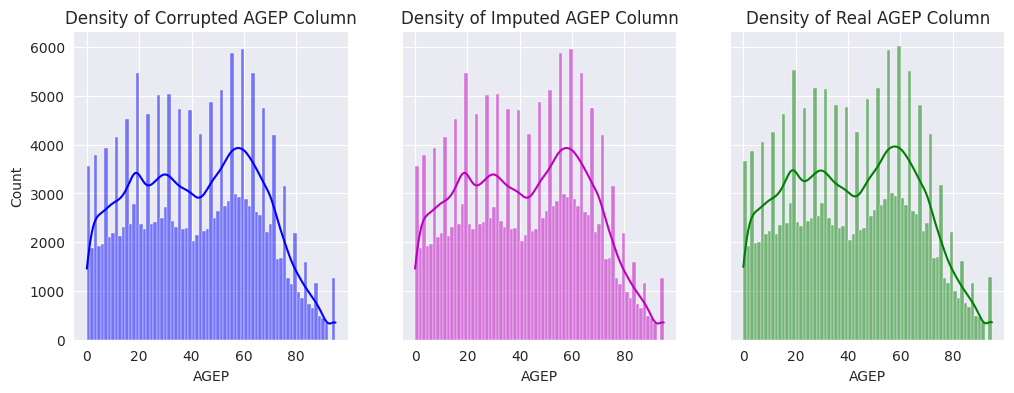





 ###############  Impute AGEP column with predict-by-sklearn technique  ###############
Number of nulls in AGEP column in the corrupted dataframe:  2937
Number of nulls in AGEP column in the imputed dataframe:  0


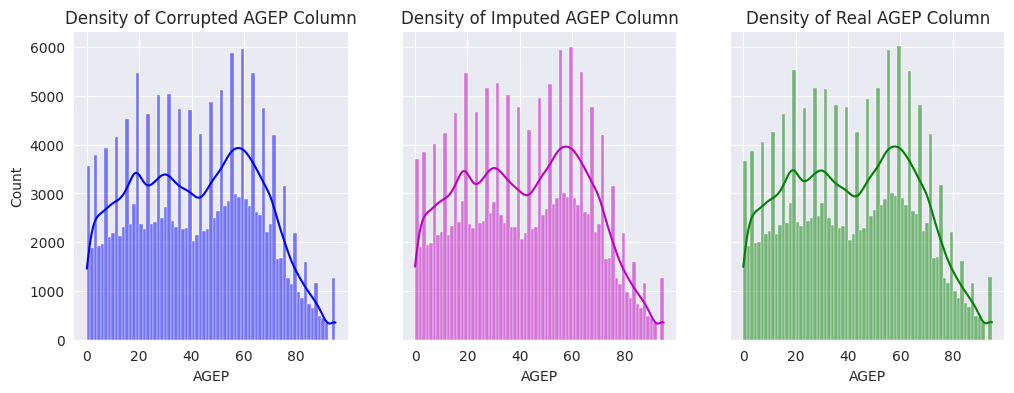





 ###############  Impute AGEP column with impute-by-mean technique  ###############
Impute values:  {'AGEP': 42.0}
Number of nulls in AGEP column in the corrupted dataframe:  2937
Number of nulls in AGEP column in the imputed dataframe:  0


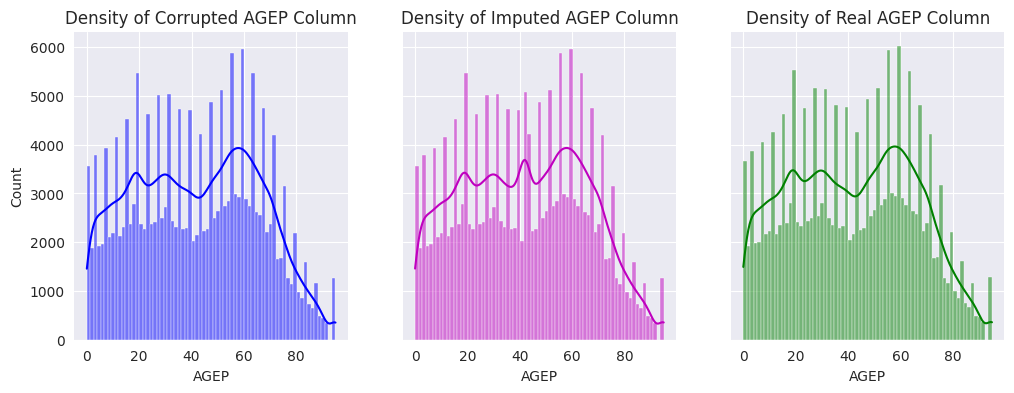





 ###############  Impute AGEP column with impute-by-mean-trimmed technique  ###############
Impute values:  {'AGEP': 42.0}
Number of nulls in AGEP column in the corrupted dataframe:  2937
Number of nulls in AGEP column in the imputed dataframe:  0


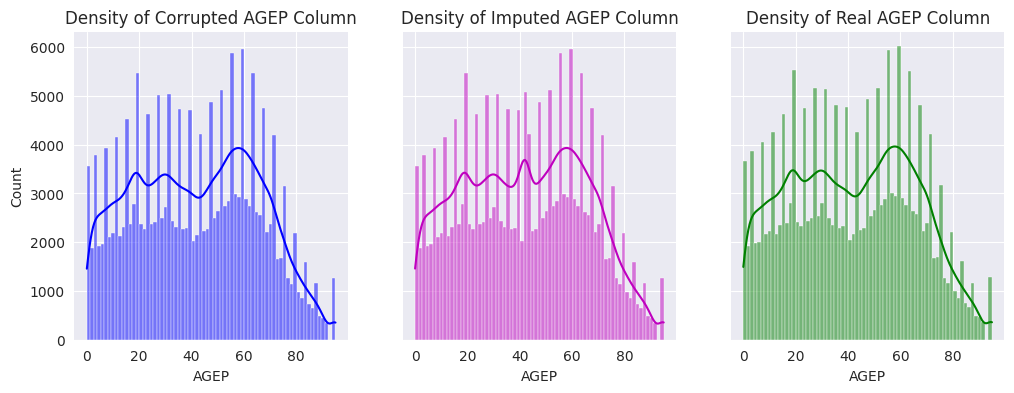





 ###############  Impute AGEP column with impute-by-mean-conditional technique  ###############
Impute AGEP with value 41.0, where SEX == 1
Impute AGEP with value 43.0, where SEX == 2
Impute AGEP with value 44.0, where RAC1P == 1
Impute AGEP with value 40.0, where RAC1P == 2
Impute AGEP with value 35.0, where RAC1P == 8
Impute AGEP with value 39.0, where RAC1P == 6
Impute AGEP with value 29.0, where RAC1P == 9
Impute AGEP with value 33.0, where RAC1P == 7
Impute AGEP with value 39.0, where RAC1P == 3
Impute AGEP with value 37.0, where RAC1P == 5
Impute AGEP with value 44.0, where RAC1P == 4
Number of nulls in AGEP column in the corrupted dataframe:  2937
Number of nulls in AGEP column in the imputed dataframe:  0


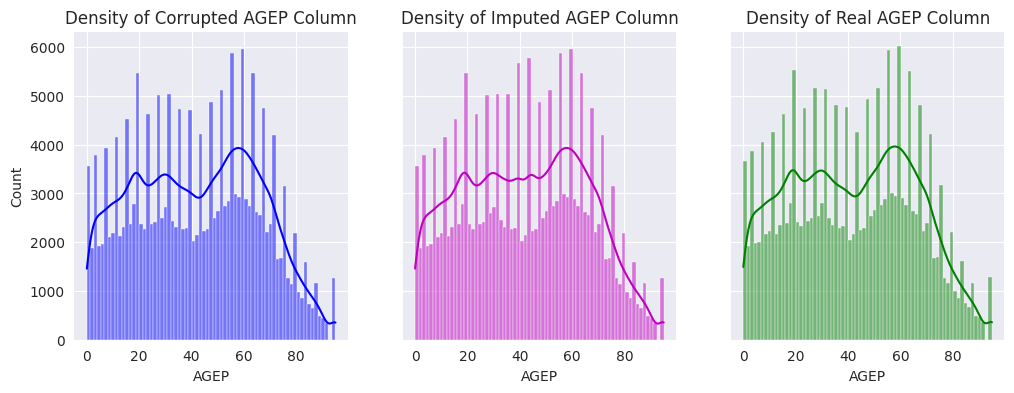





 ###############  Impute AGEP column with impute-by-median technique  ###############
Impute values:  {'AGEP': 42.0}
Number of nulls in AGEP column in the corrupted dataframe:  2937
Number of nulls in AGEP column in the imputed dataframe:  0


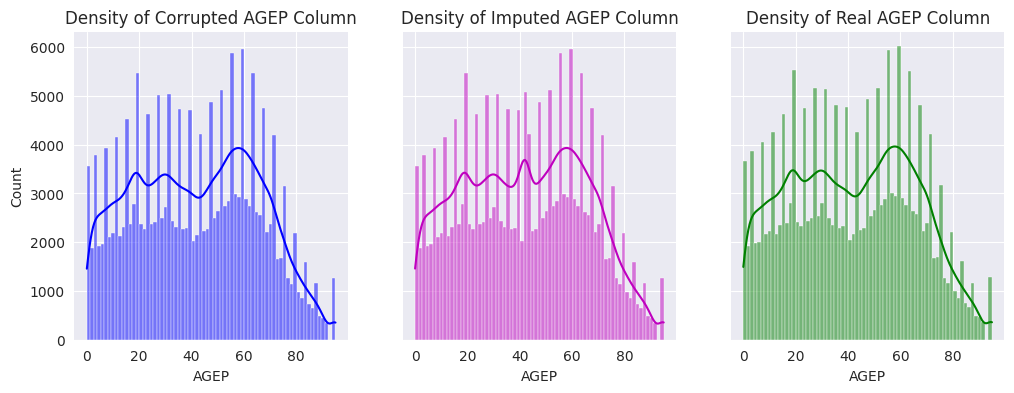





 ###############  Impute AGEP column with impute-by-median-trimmed technique  ###############
Impute values:  {'AGEP': 42.0}
Number of nulls in AGEP column in the corrupted dataframe:  2937
Number of nulls in AGEP column in the imputed dataframe:  0


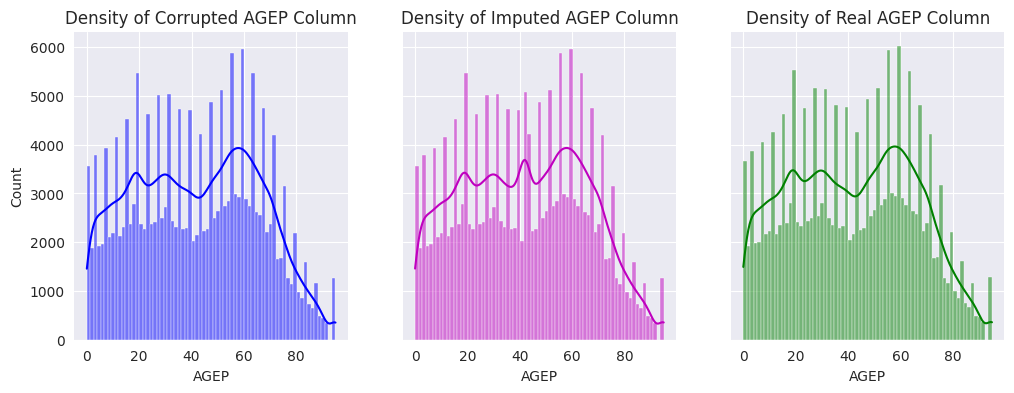





 ###############  Impute AGEP column with impute-by-median-conditional technique  ###############
Impute AGEP with value 41.0, where SEX == 1
Impute AGEP with value 44.0, where SEX == 2
Impute AGEP with value 46.0, where RAC1P == 1
Impute AGEP with value 39.0, where RAC1P == 2
Impute AGEP with value 33.0, where RAC1P == 8
Impute AGEP with value 38.0, where RAC1P == 6
Impute AGEP with value 24.0, where RAC1P == 9
Impute AGEP with value 30.0, where RAC1P == 7
Impute AGEP with value 39.0, where RAC1P == 3
Impute AGEP with value 34.0, where RAC1P == 5
Impute AGEP with value 49.0, where RAC1P == 4
Number of nulls in AGEP column in the corrupted dataframe:  2937
Number of nulls in AGEP column in the imputed dataframe:  0


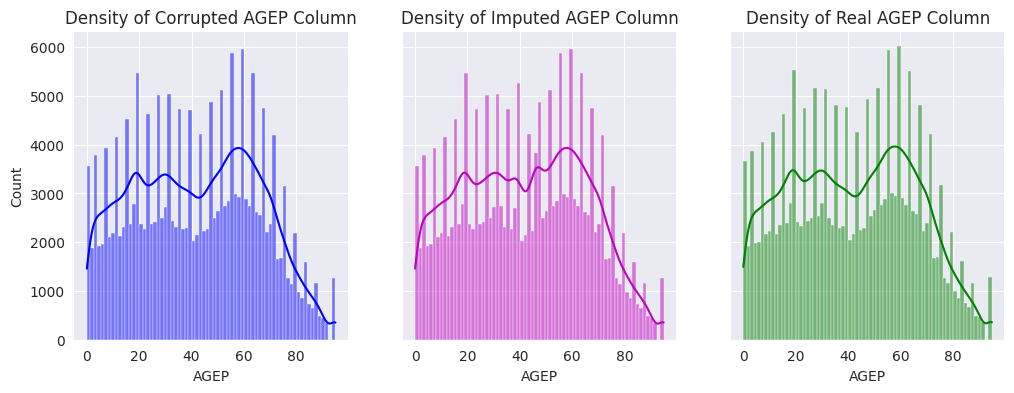

In [16]:
# TODO: use enable_plots=True just for one pipeline, but for others set False
imputed_data_dict = impute_df_with_all_techniques(X_data, corrupted_data, TARGET_COLUMN, COLUMN_TYPE, enable_plots=True)
imputed_data_dict['baseline'] = X_data

## Quantifying uncertainty using posterior predictive distribution

In [17]:
matplotlib.rcParams.update({'font.size': 14})
imputation_techniques = list(imputed_data_dict.keys())
imputation_techniques

['drop-column',
 'drop-rows',
 'predict-by-sklearn',
 'impute-by-mean',
 'impute-by-mean-trimmed',
 'impute-by-mean-conditional_SEX',
 'impute-by-mean-conditional_RAC1P',
 'impute-by-median',
 'impute-by-median-trimmed',
 'impute-by-median-conditional_SEX',
 'impute-by-median-conditional_RAC1P',
 'baseline']

### Baseline technique

X_train_imputed.shape:  (118179, 74)
X_val_imputed.shape:  (39394, 74)
X_test_imputed.shape:  (39394, 74)


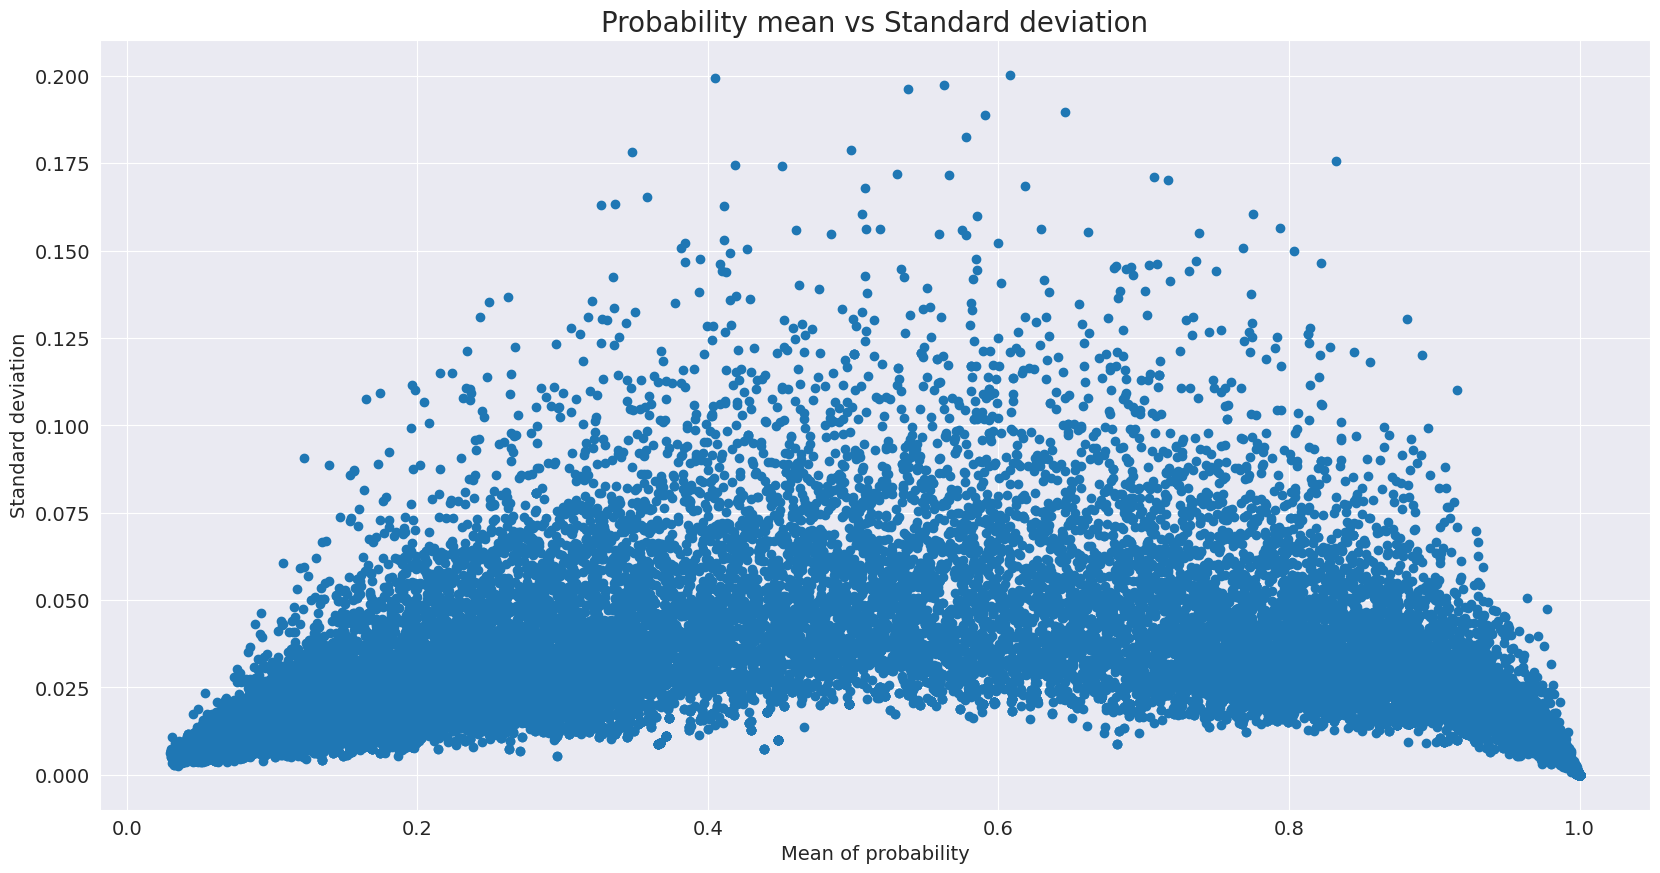

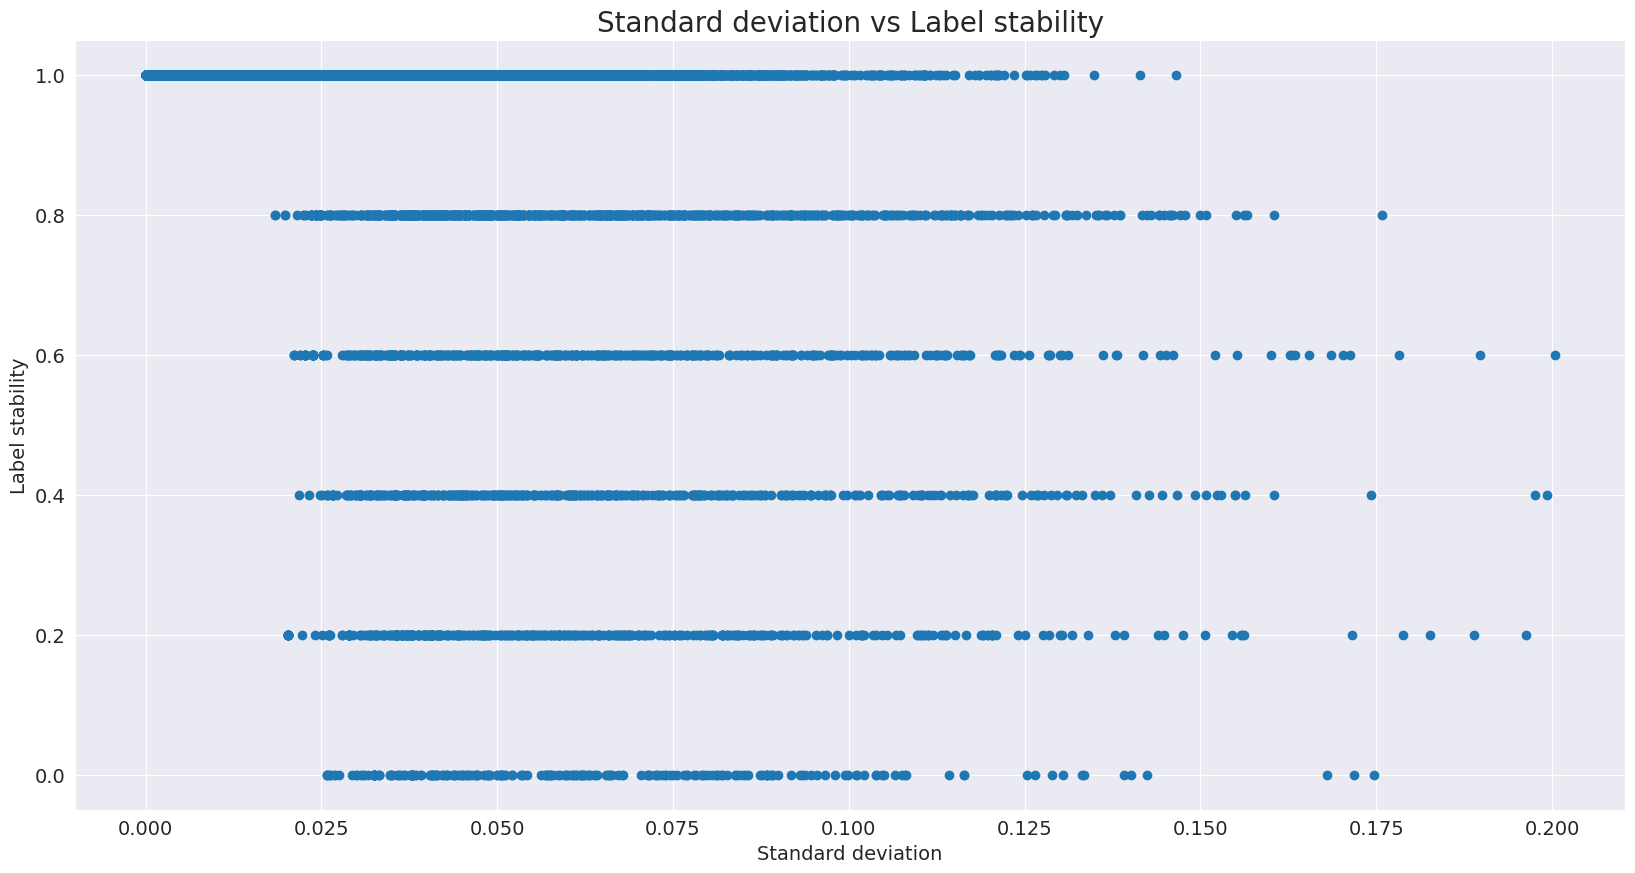

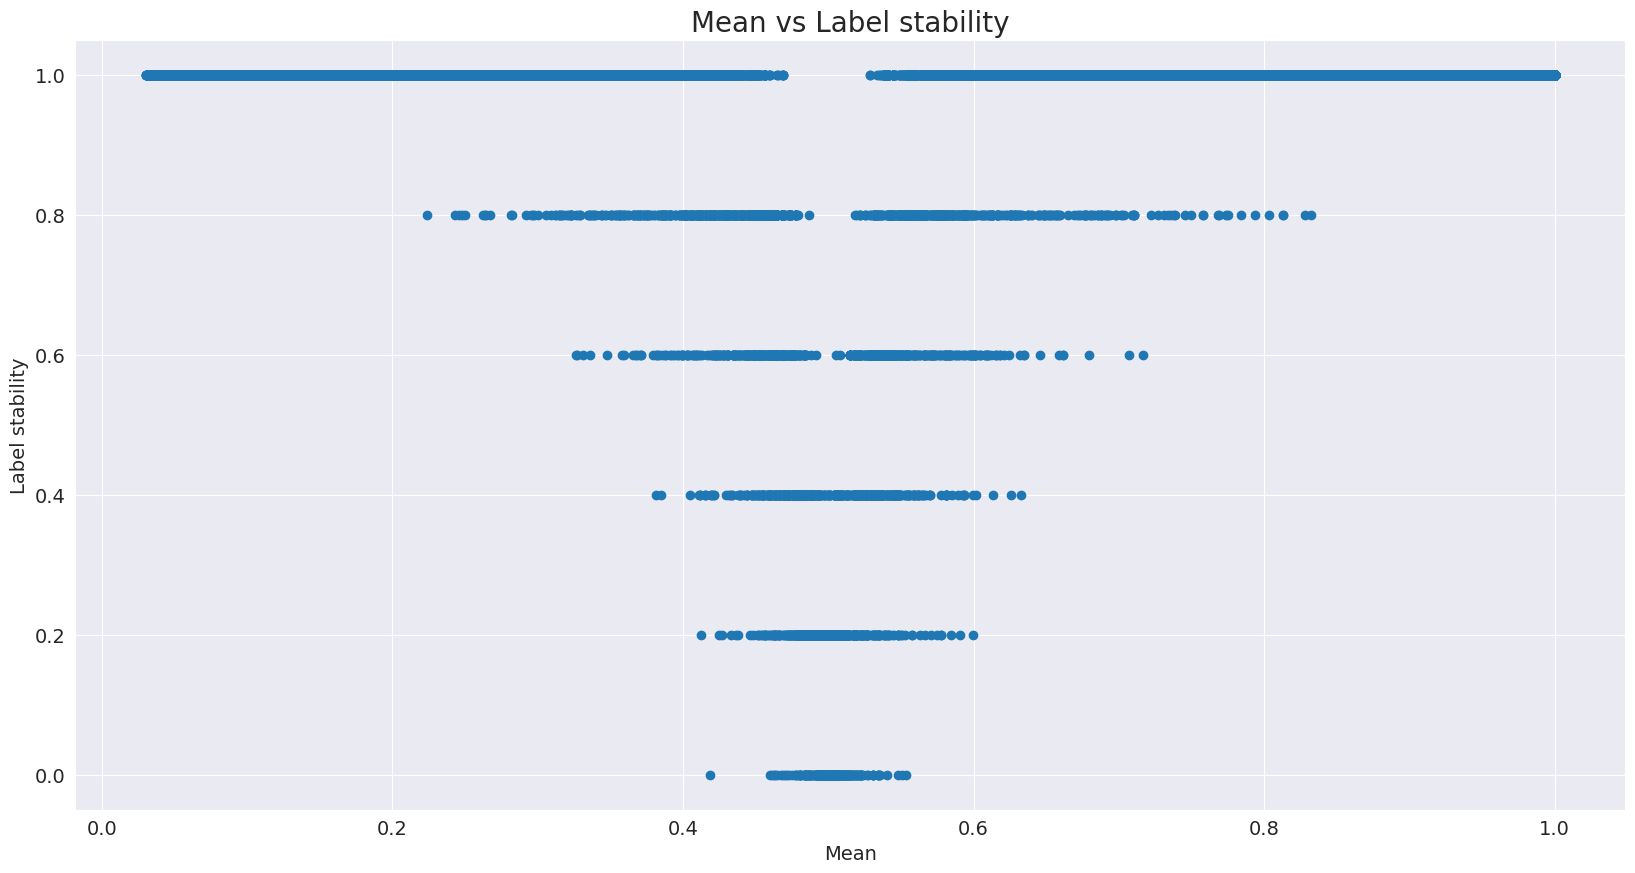

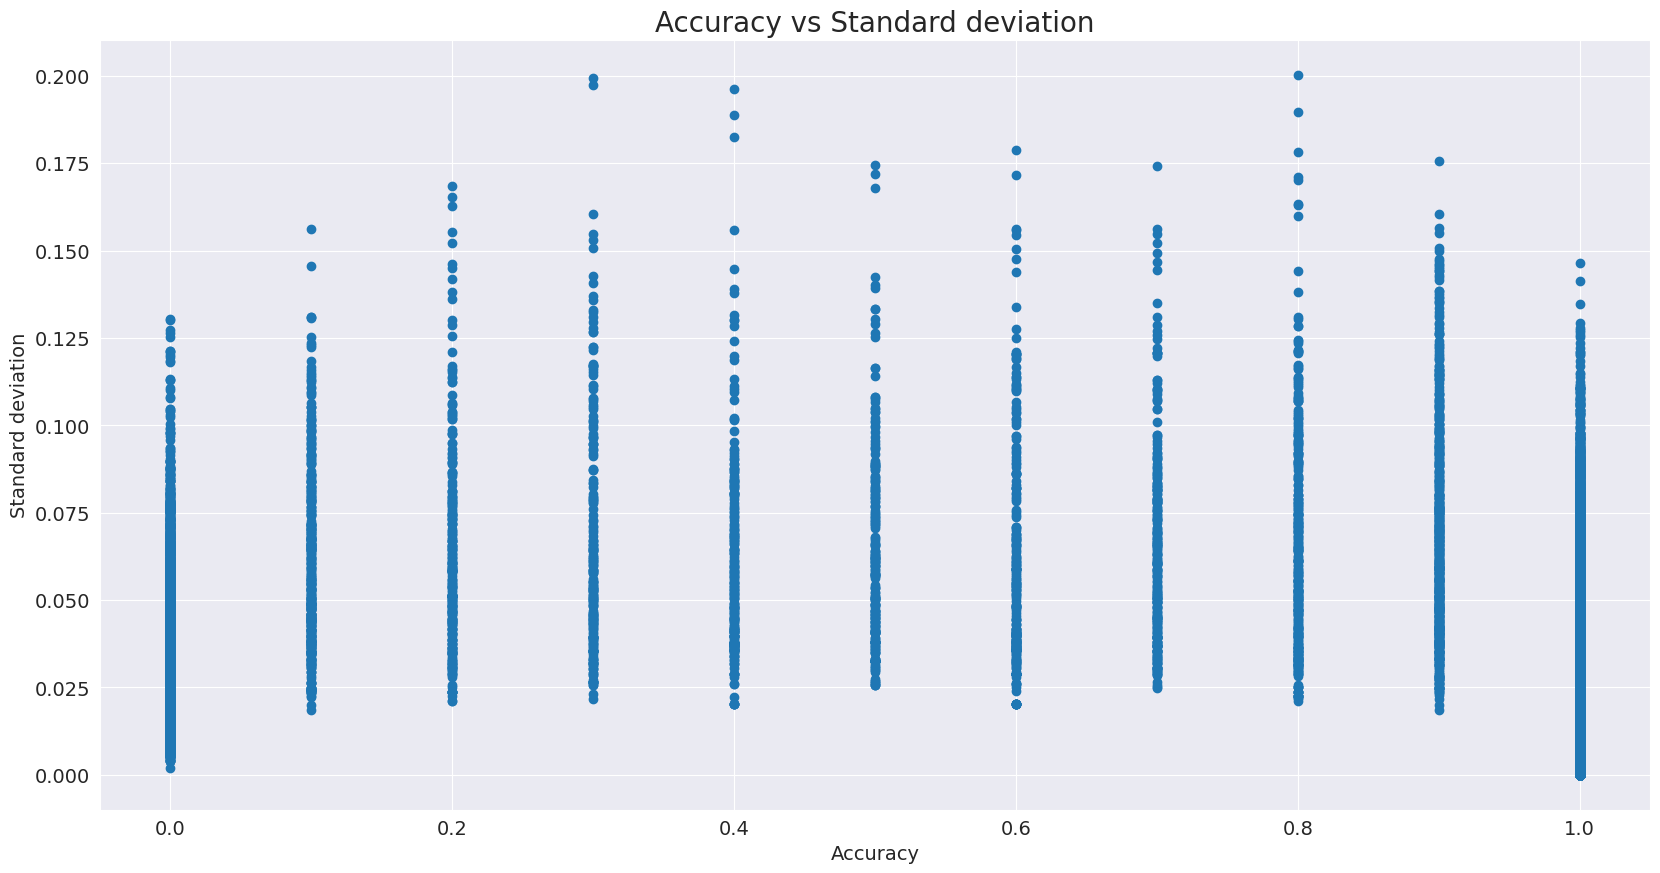

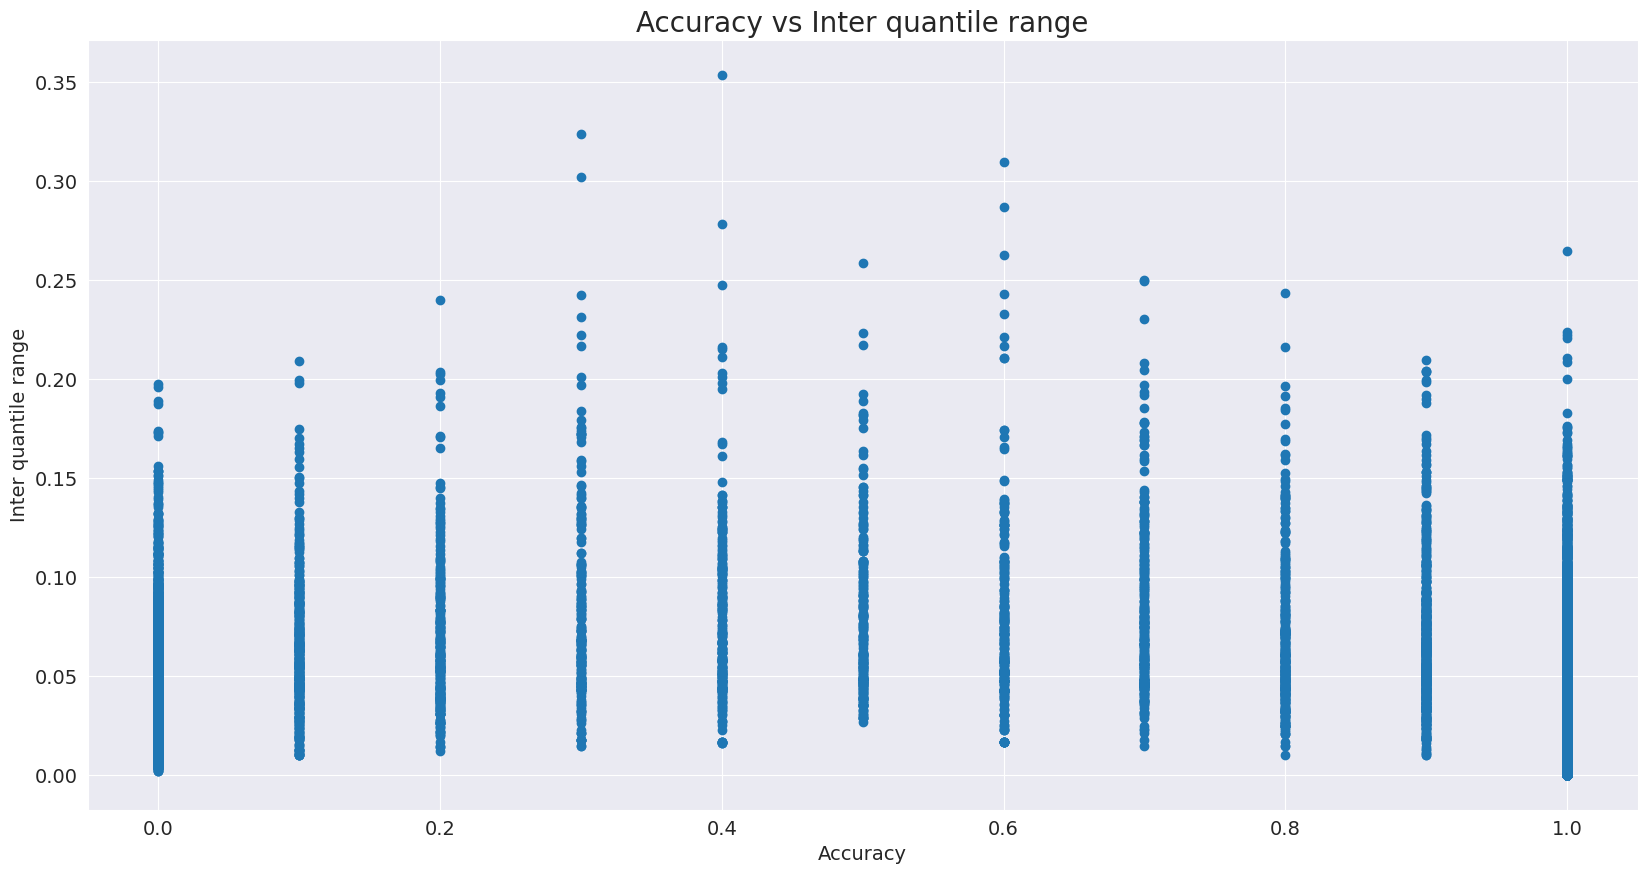

############################## Fairness metrics ##############################

#################### Accuracy ####################
              Race       Sex  Race_Sex
adv       0.830464  0.847820  0.846222
disadv    0.825566  0.809773  0.805668
Accuracy  0.004898  0.038047  0.040554

#################### Disparate_Impact ####################
                      Race       Sex  Race_Sex
adv               0.510397  0.516947  0.528104
disadv            0.466866  0.496303  0.495547
Disparate_Impact  0.914712  0.960066  0.938350

#################### Equal_Opportunity ####################
                       Race      Sex  Race_Sex
adv                0.859179  0.87454  0.871663
disadv             0.844758  0.84494  0.838182
Equal_Opportunity  0.014421  0.02960  0.033481

#################### Statistical_Parity_Difference ####################
                                   Race       Sex  Race_Sex
adv                            1.075652  1.061593  1.048695
disadv                 

In [18]:
quantify_uncertainty(TARGET_COLUMN, y_data, imputed_data_dict, imputation_technique='baseline')

### Drop-column technique

X_train_imputed.shape:  (118179, 73)
X_val_imputed.shape:  (39394, 73)
X_test_imputed.shape:  (39394, 73)


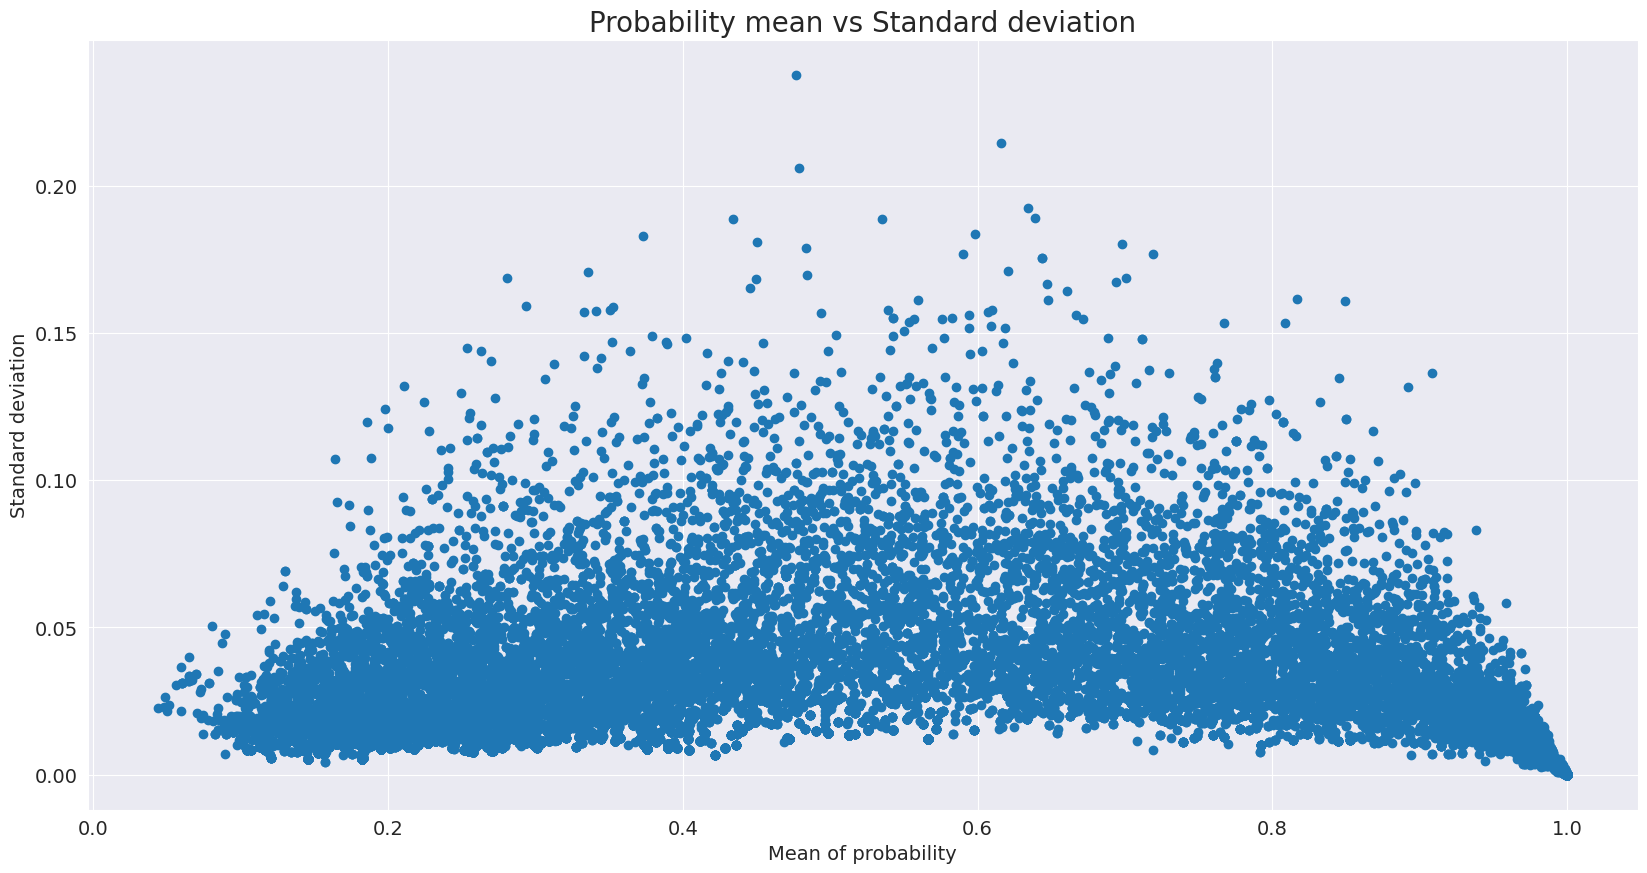

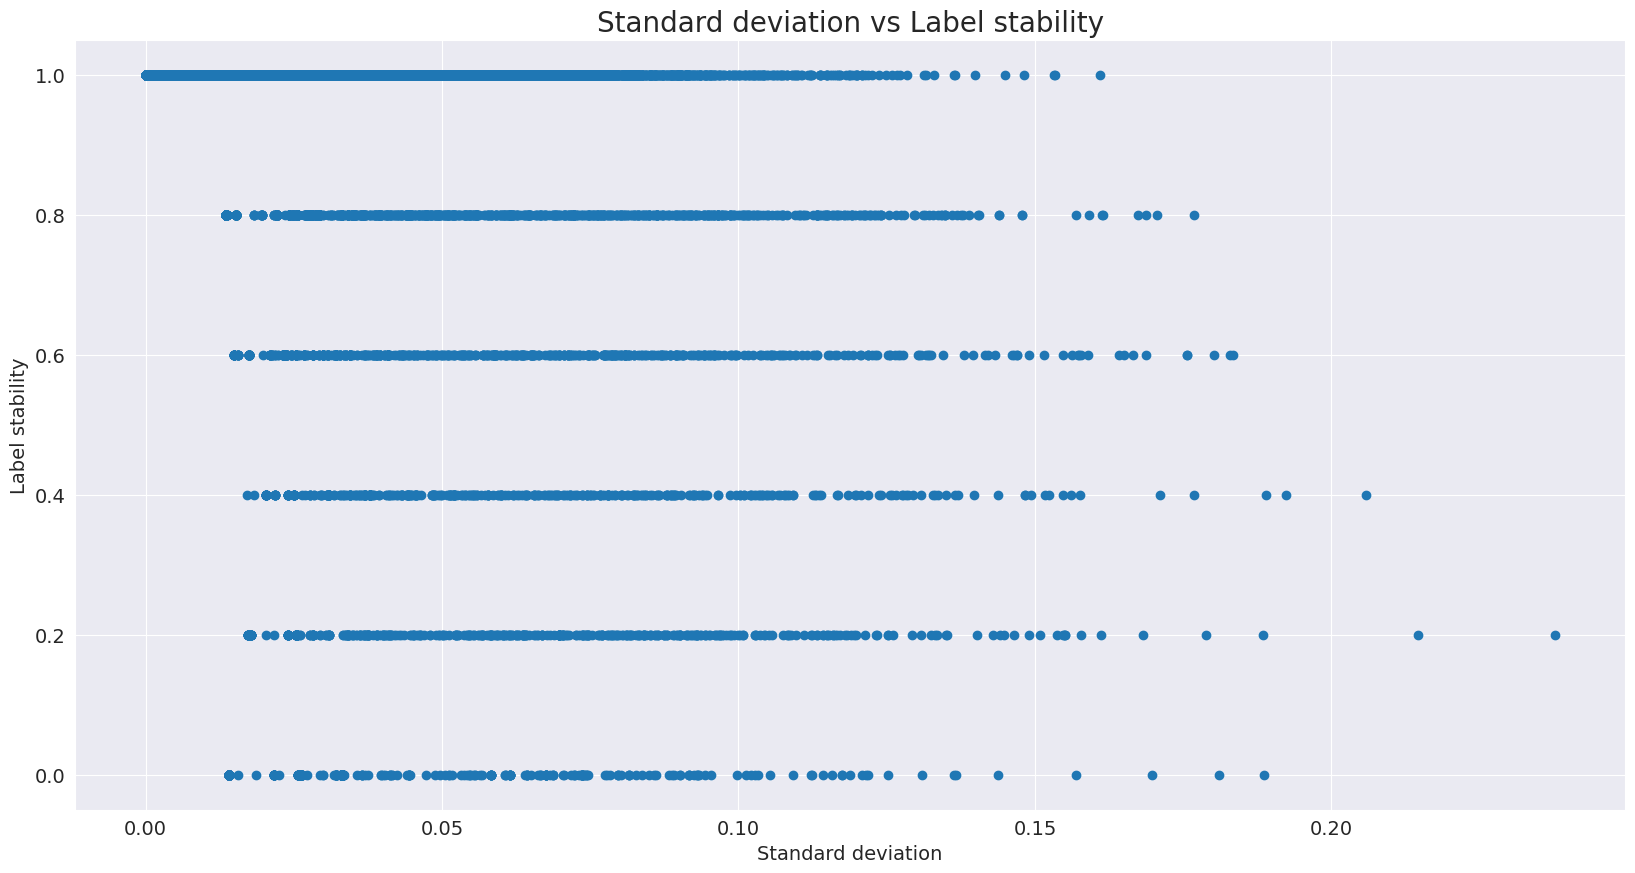

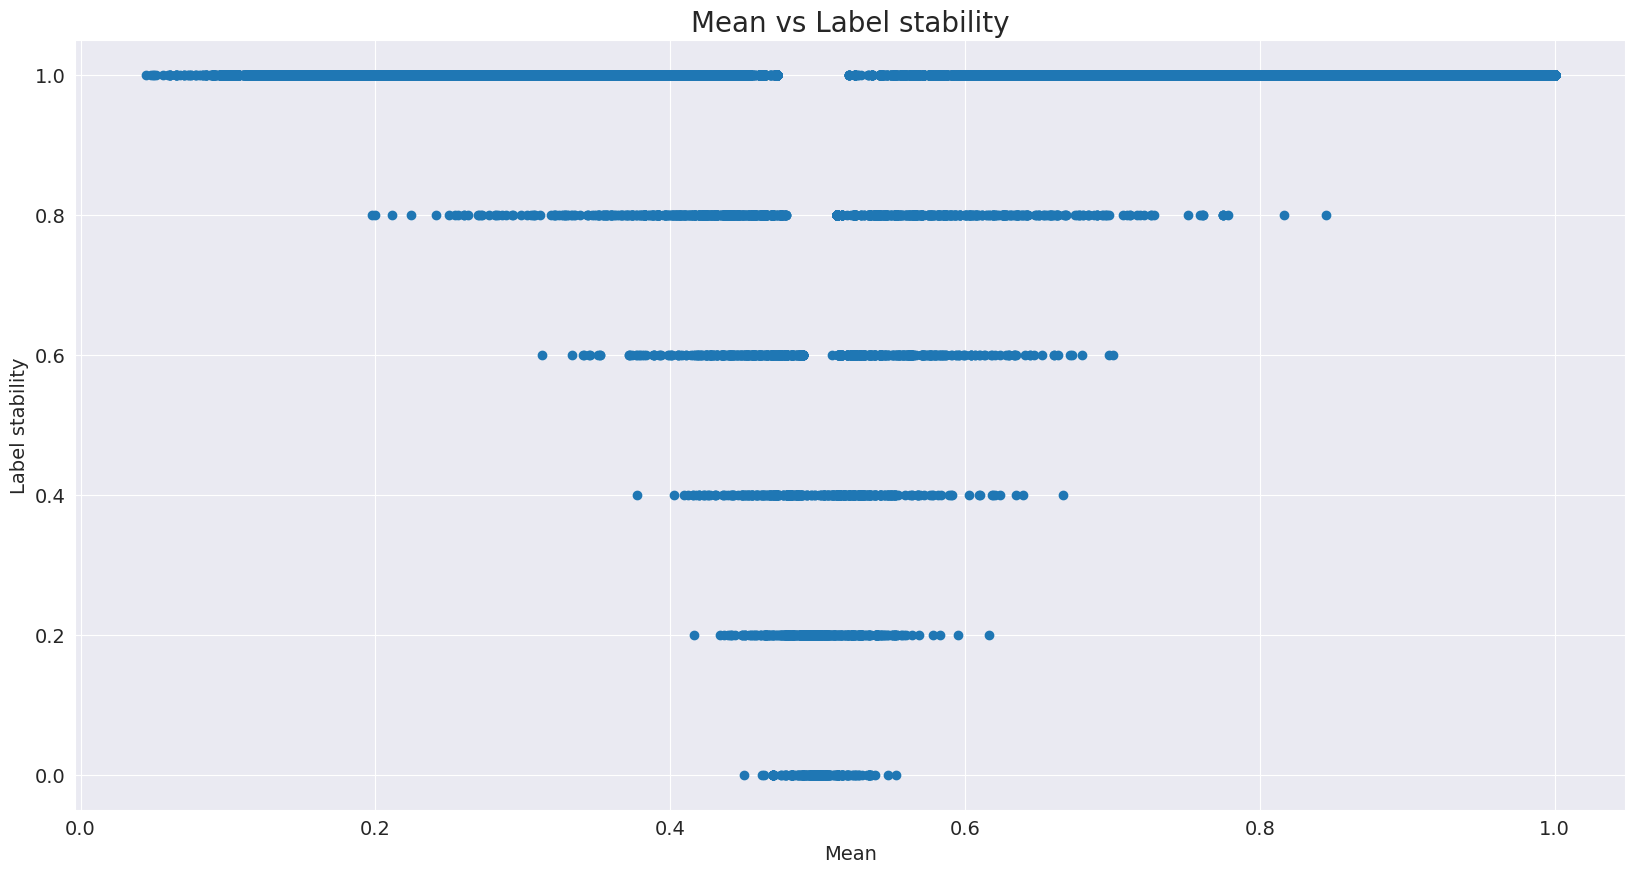

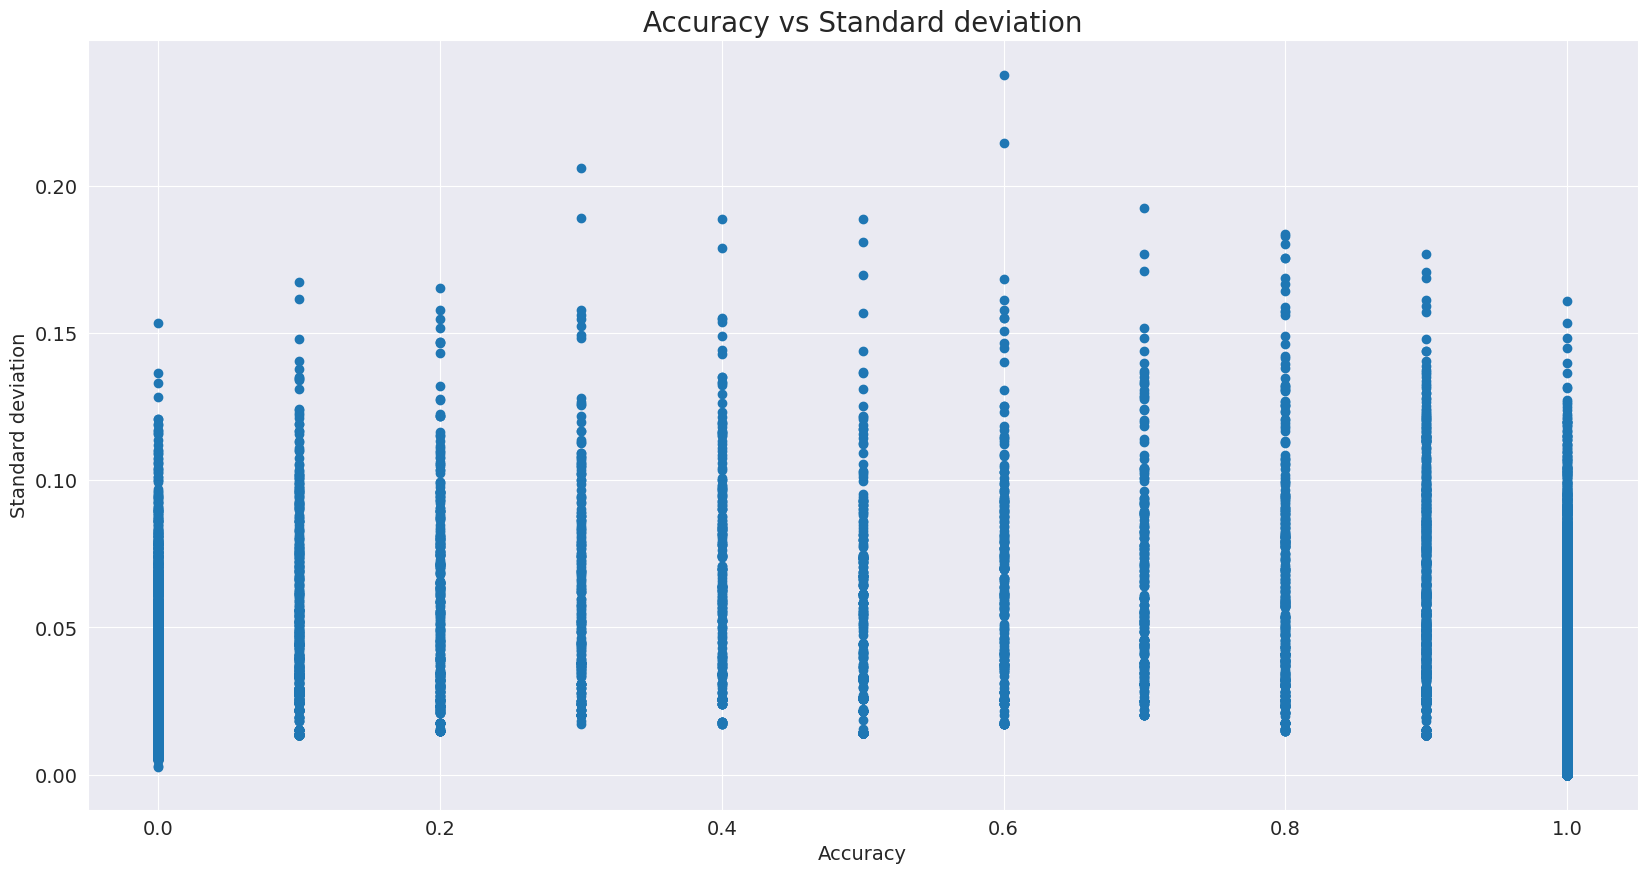

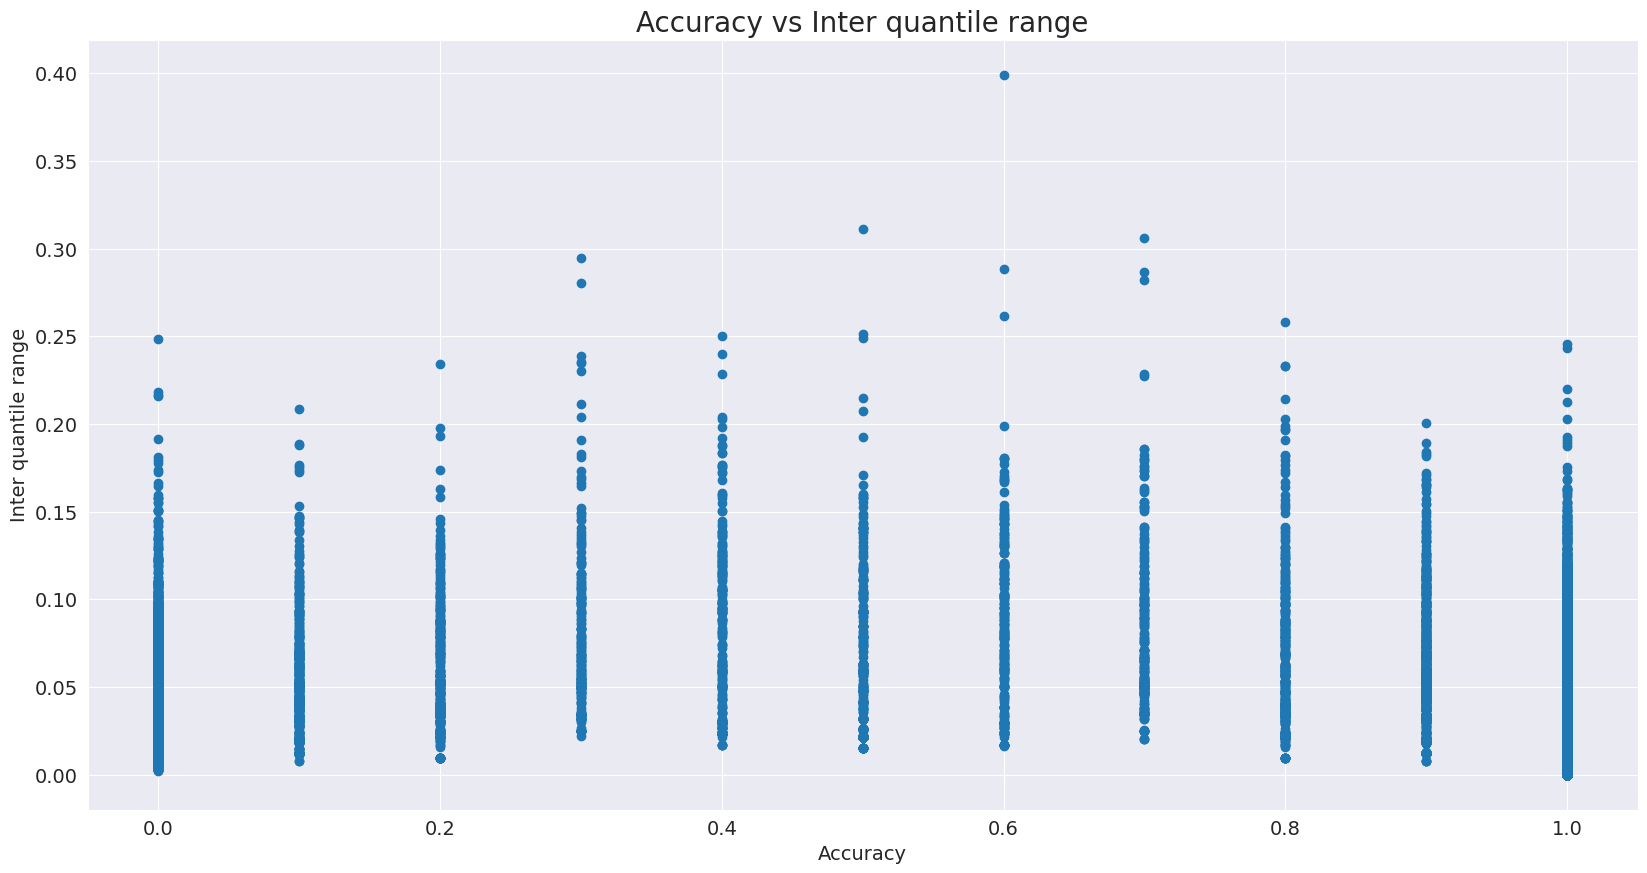

############################## Fairness metrics ##############################

#################### Accuracy ####################
              Race       Sex  Race_Sex
adv       0.770912  0.801114  0.799246
disadv    0.778397  0.751253  0.779661
Accuracy -0.007486  0.049861  0.019585

#################### Disparate_Impact ####################
                      Race       Sex  Race_Sex
adv               0.563133  0.577695  0.587631
disadv            0.513218  0.530995  0.515023
Disparate_Impact  0.911361  0.919162  0.876439

#################### Equal_Opportunity ####################
                       Race       Sex  Race_Sex
adv                0.854108  0.888314  0.884661
disadv             0.851244  0.821149  0.837599
Equal_Opportunity  0.002864  0.067165  0.047061

#################### Statistical_Parity_Difference ####################
                                   Race       Sex  Race_Sex
adv                            1.193910  1.184383  1.168528
disadv             

In [19]:
quantify_uncertainty(TARGET_COLUMN, y_data, imputed_data_dict, imputation_technique='drop-column')

### Drop-rows technique

X_train_imputed.shape:  (116418, 74)
X_val_imputed.shape:  (38806, 74)
X_test_imputed.shape:  (38806, 74)


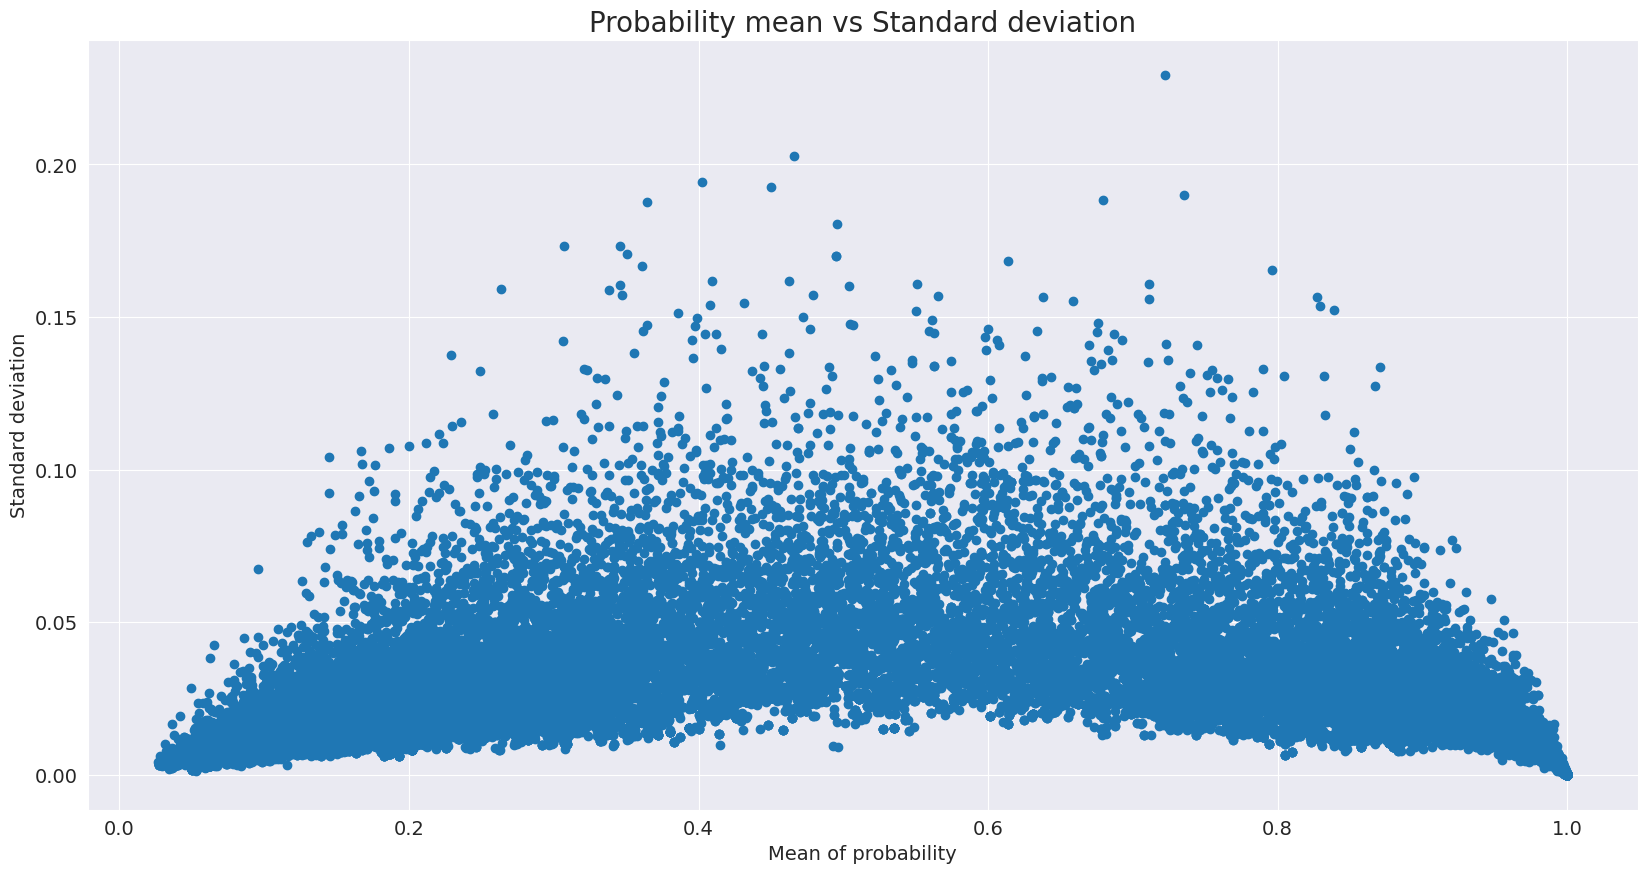

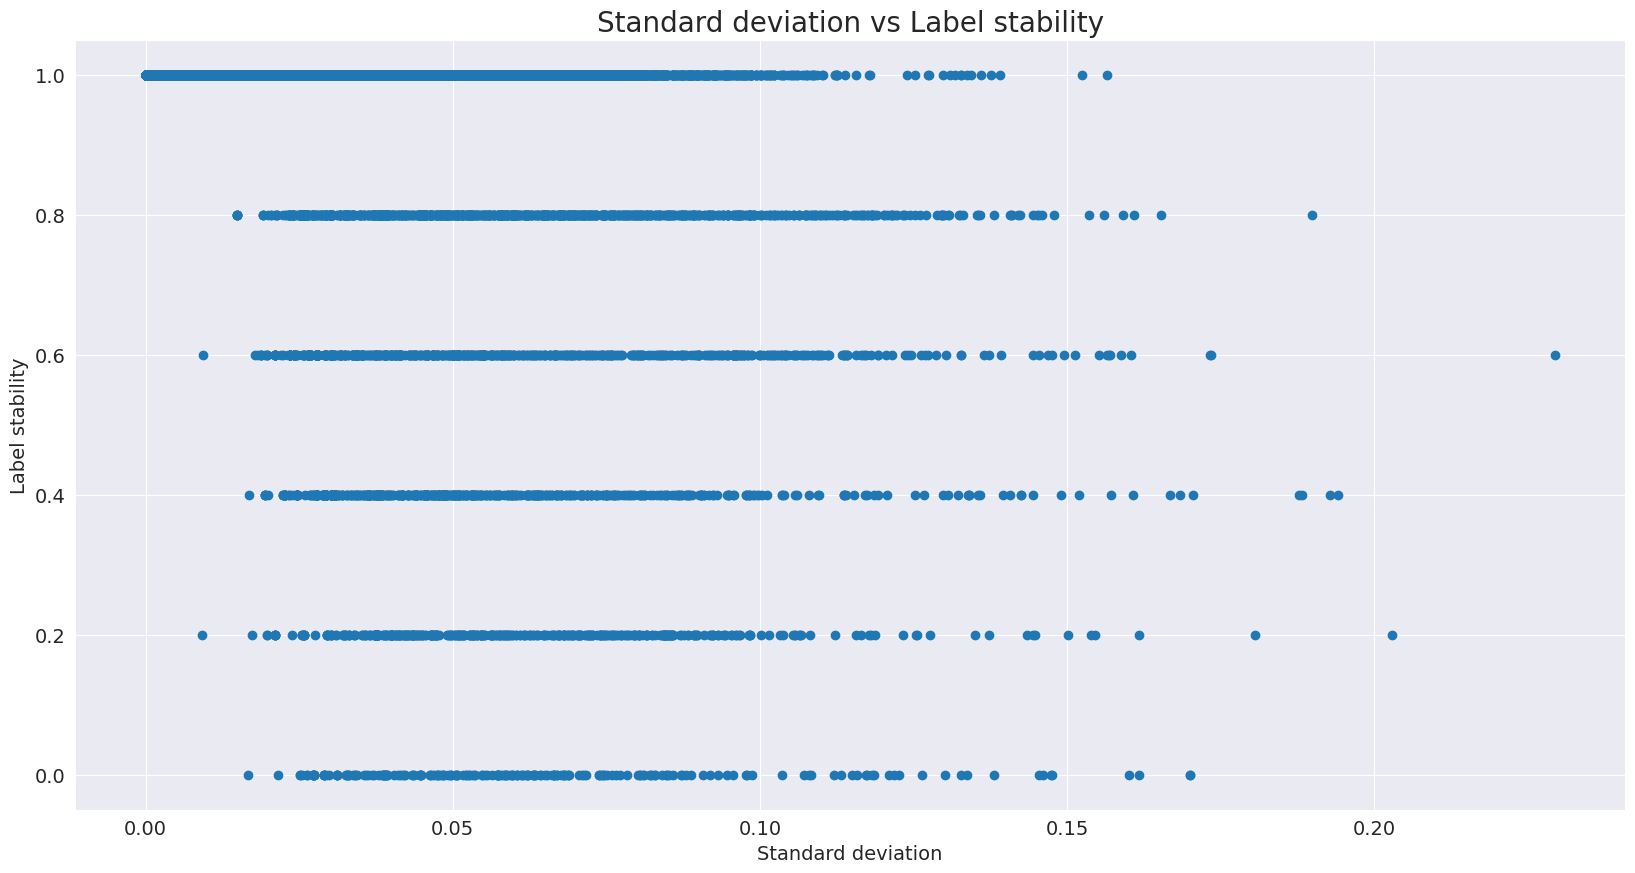

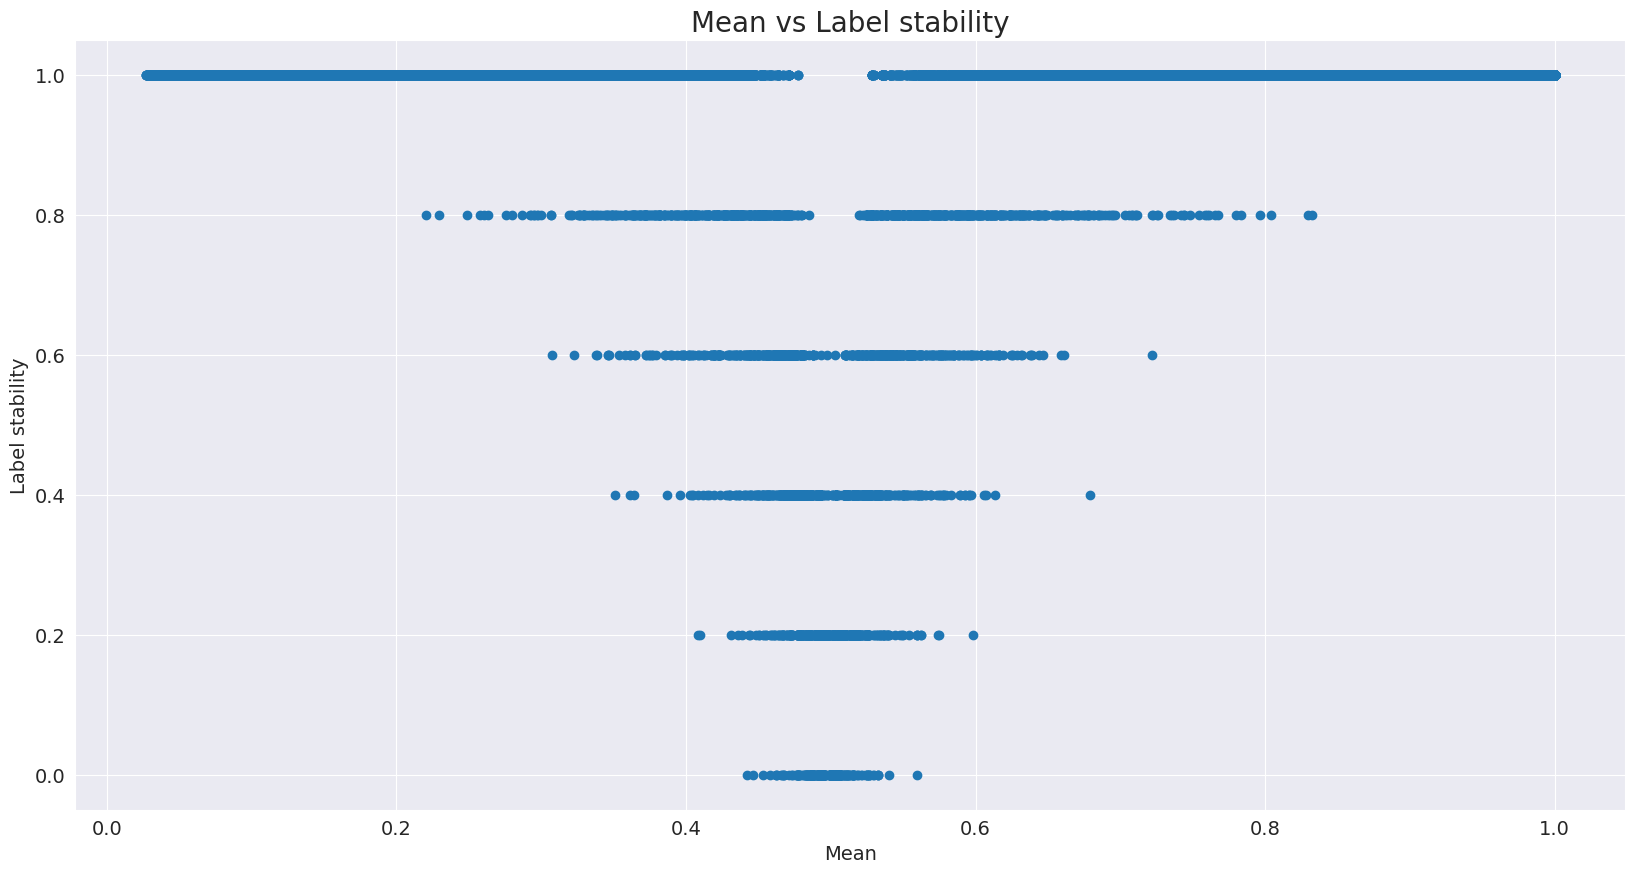

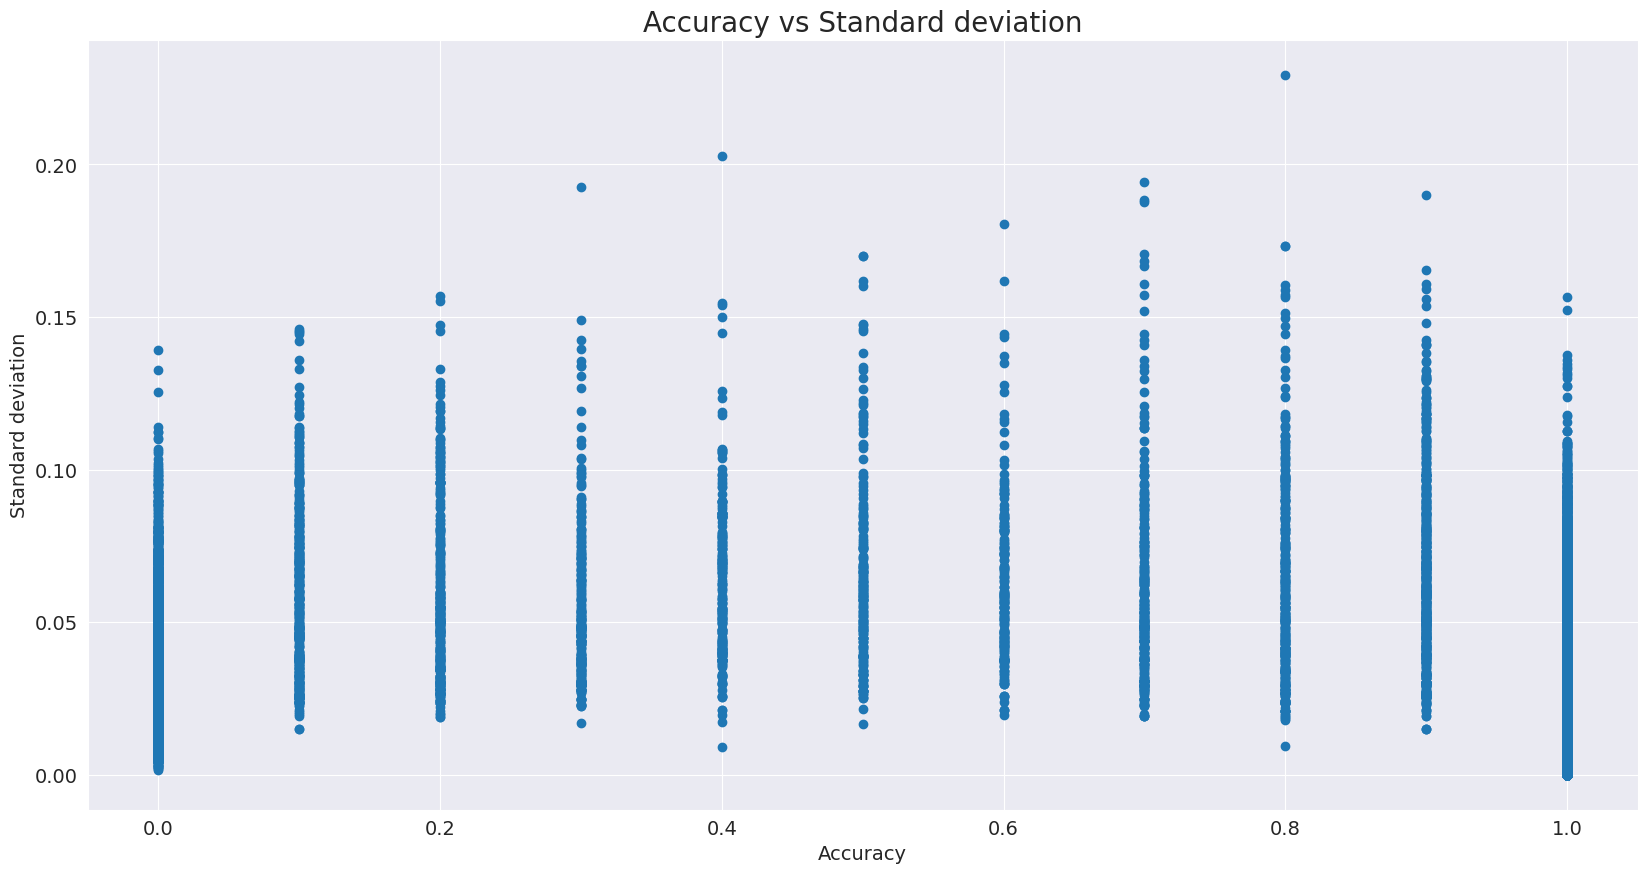

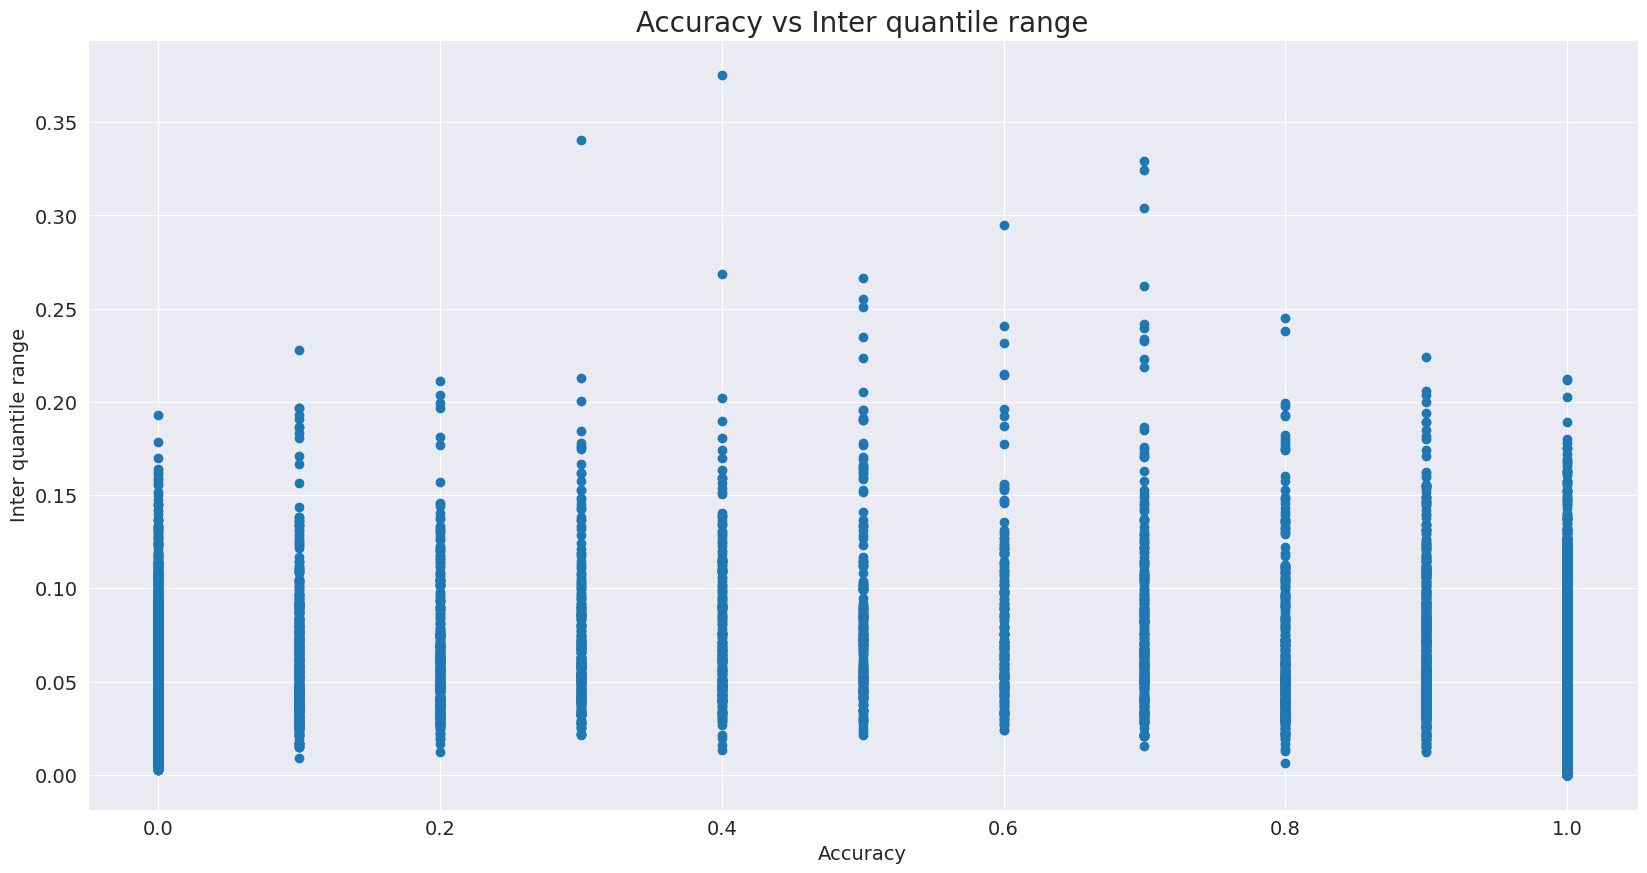

############################## Fairness metrics ##############################

#################### Accuracy ####################
              Race       Sex  Race_Sex
adv       0.831751  0.847955  0.848122
disadv    0.822179  0.810294  0.810338
Accuracy  0.009572  0.037661  0.037784

#################### Disparate_Impact ####################
                      Race       Sex  Race_Sex
adv               0.508188  0.520499  0.526635
disadv            0.476067  0.491090  0.483101
Disparate_Impact  0.936793  0.943498  0.917337

#################### Equal_Opportunity ####################
                       Race       Sex  Race_Sex
adv                0.859089  0.878704  0.874085
disadv             0.848608  0.839218  0.832432
Equal_Opportunity  0.010482  0.039487  0.041653

#################### Statistical_Parity_Difference ####################
                                   Race       Sex  Race_Sex
adv                            1.073632  1.069957  1.051382
disadv             

In [20]:
quantify_uncertainty(TARGET_COLUMN, y_data, imputed_data_dict, imputation_technique='drop-rows')

### Predict-by-sklearn technique

X_train_imputed.shape:  (118179, 74)
X_val_imputed.shape:  (39394, 74)
X_test_imputed.shape:  (39394, 74)


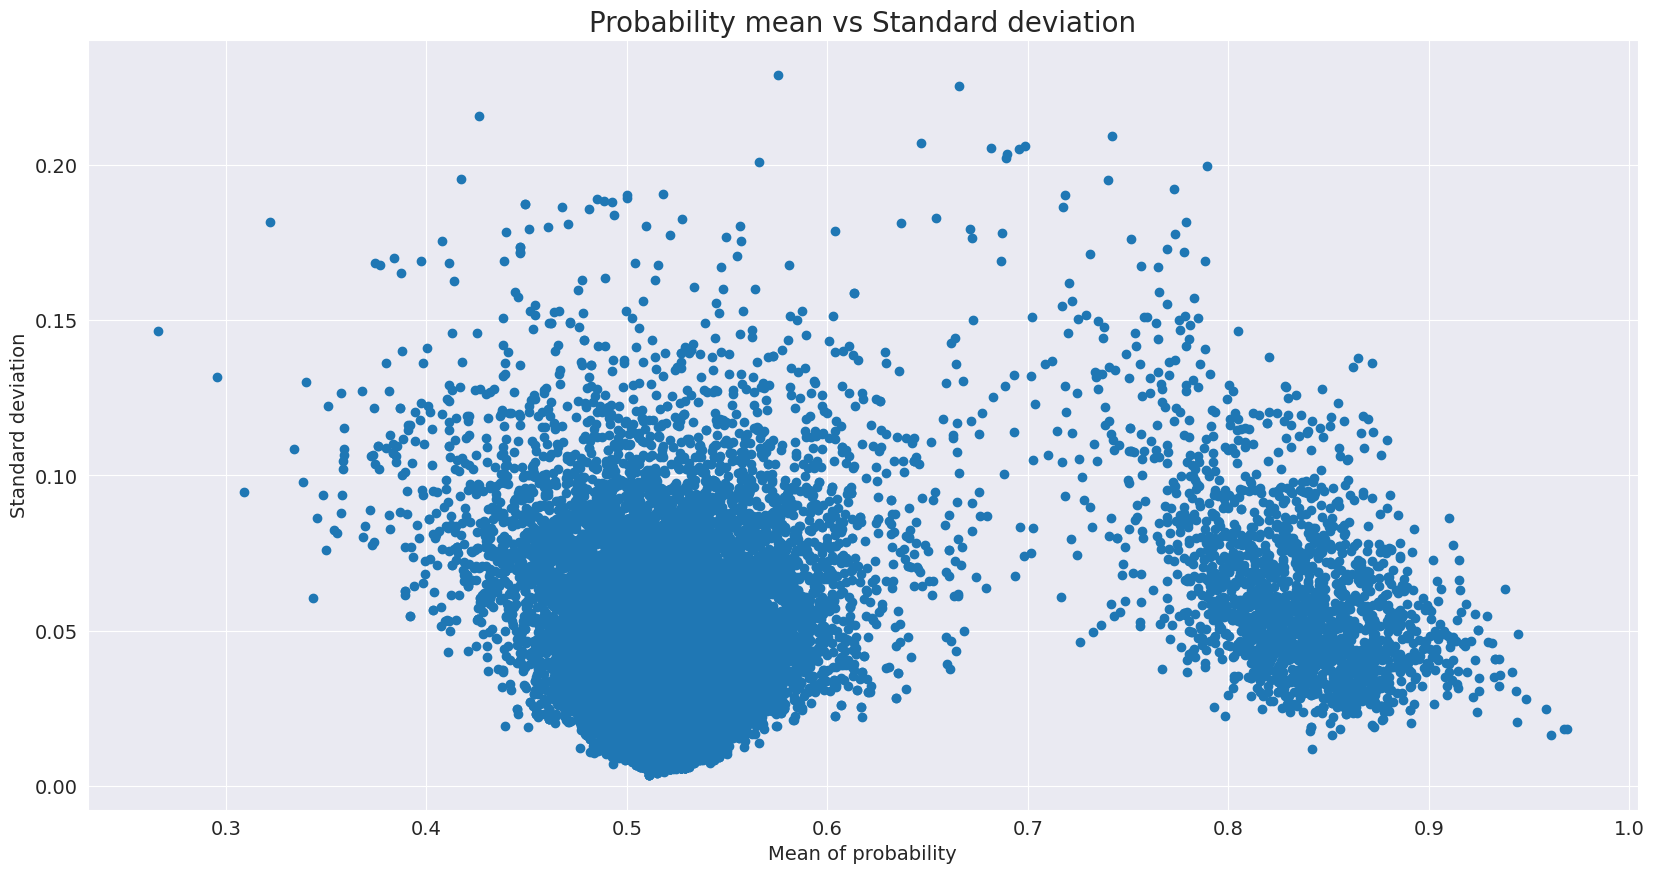

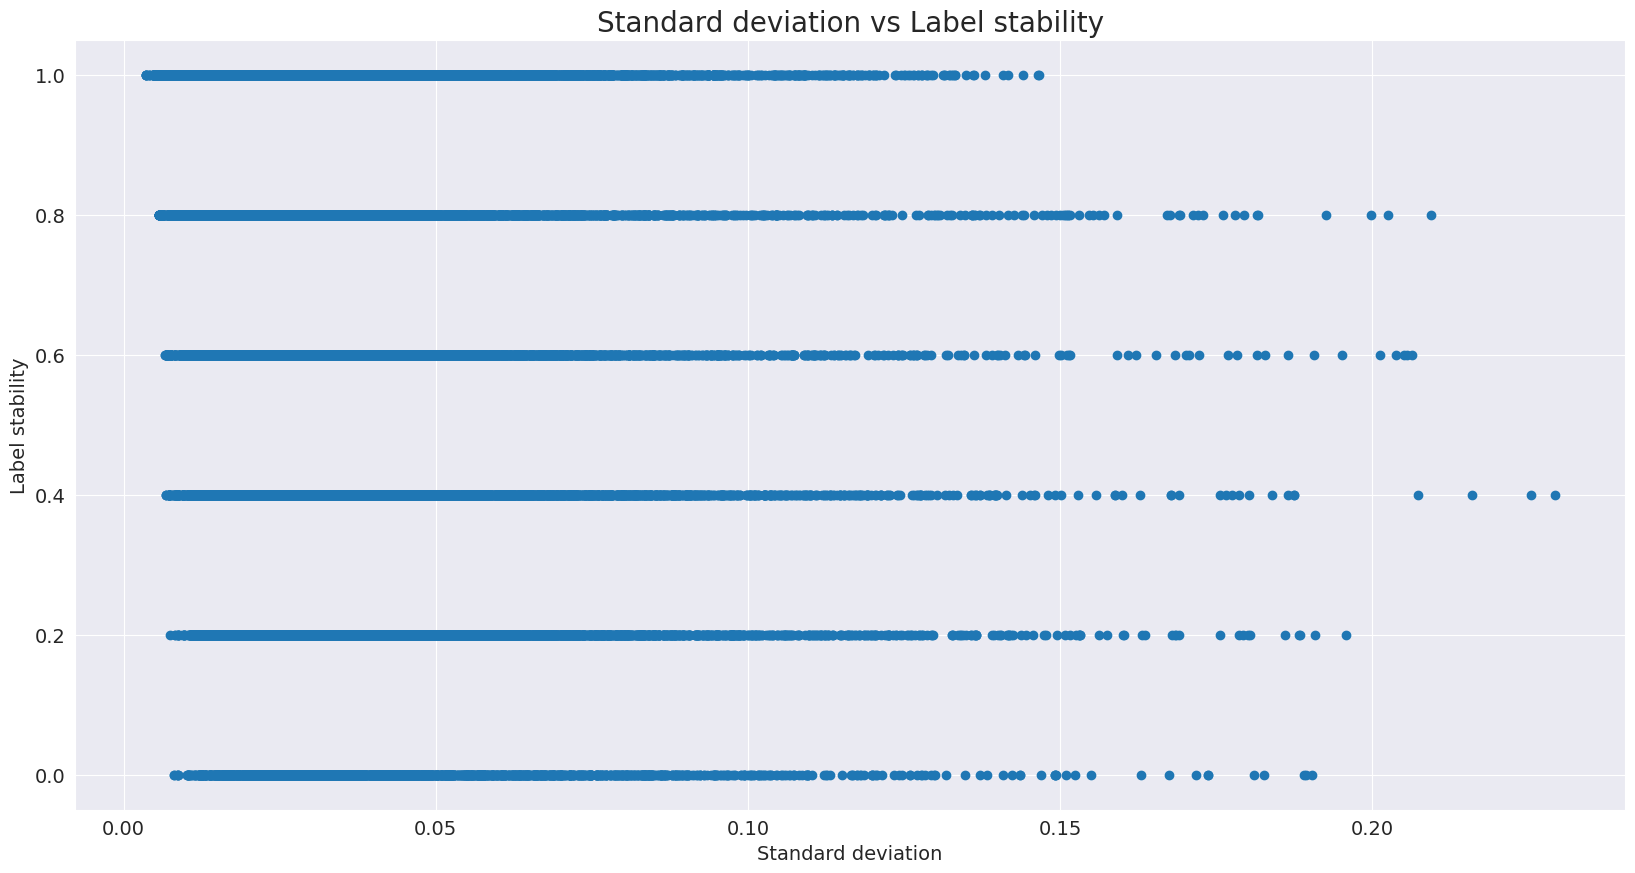

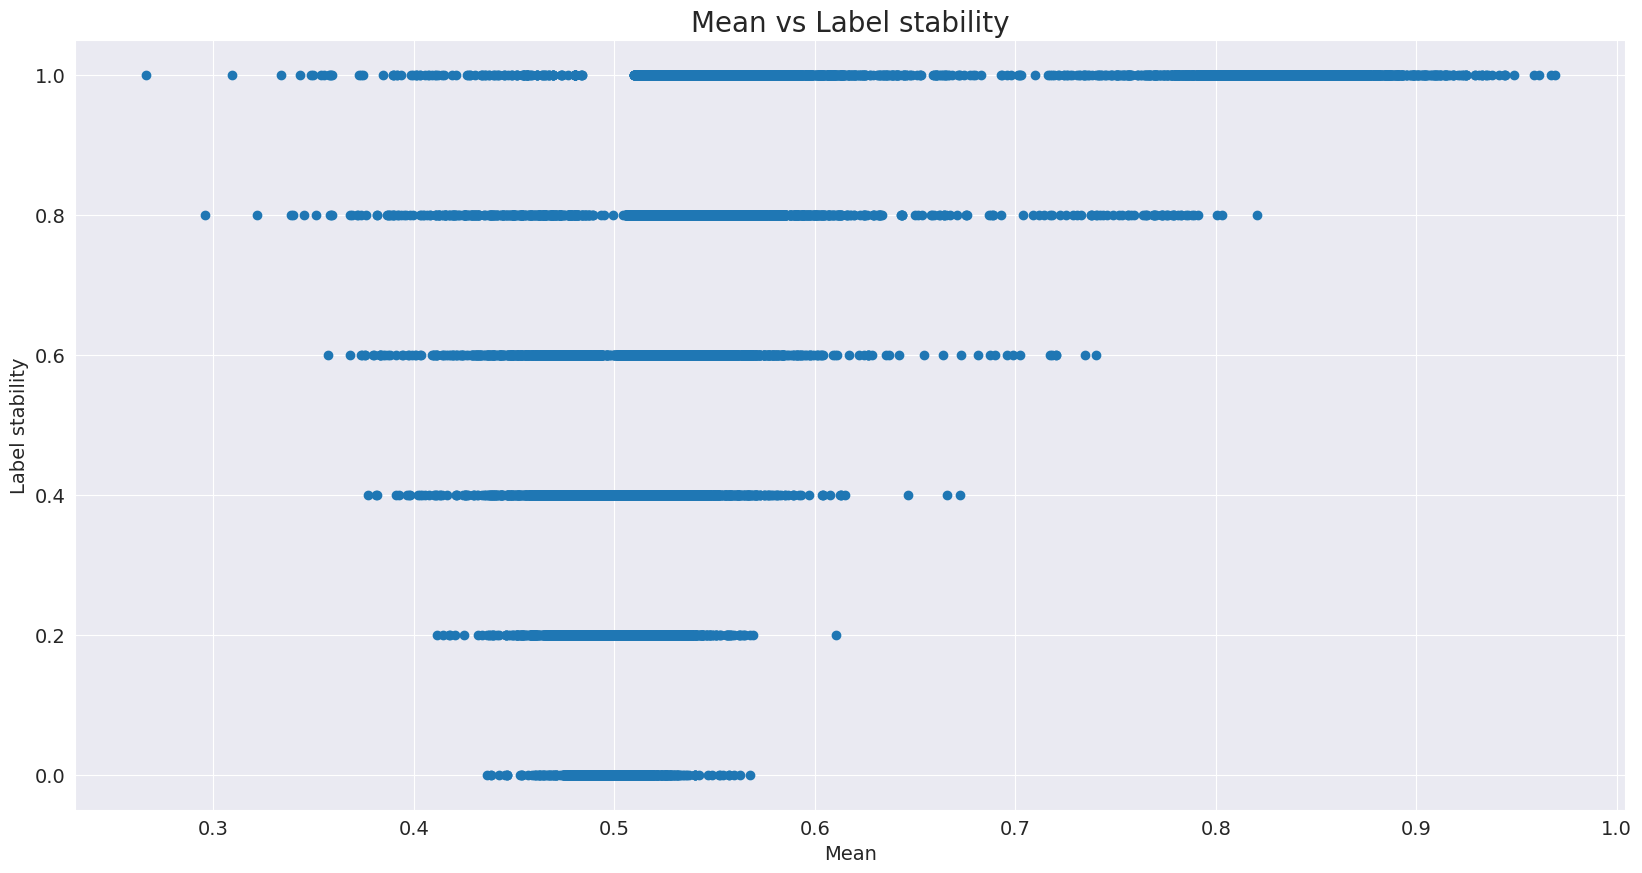

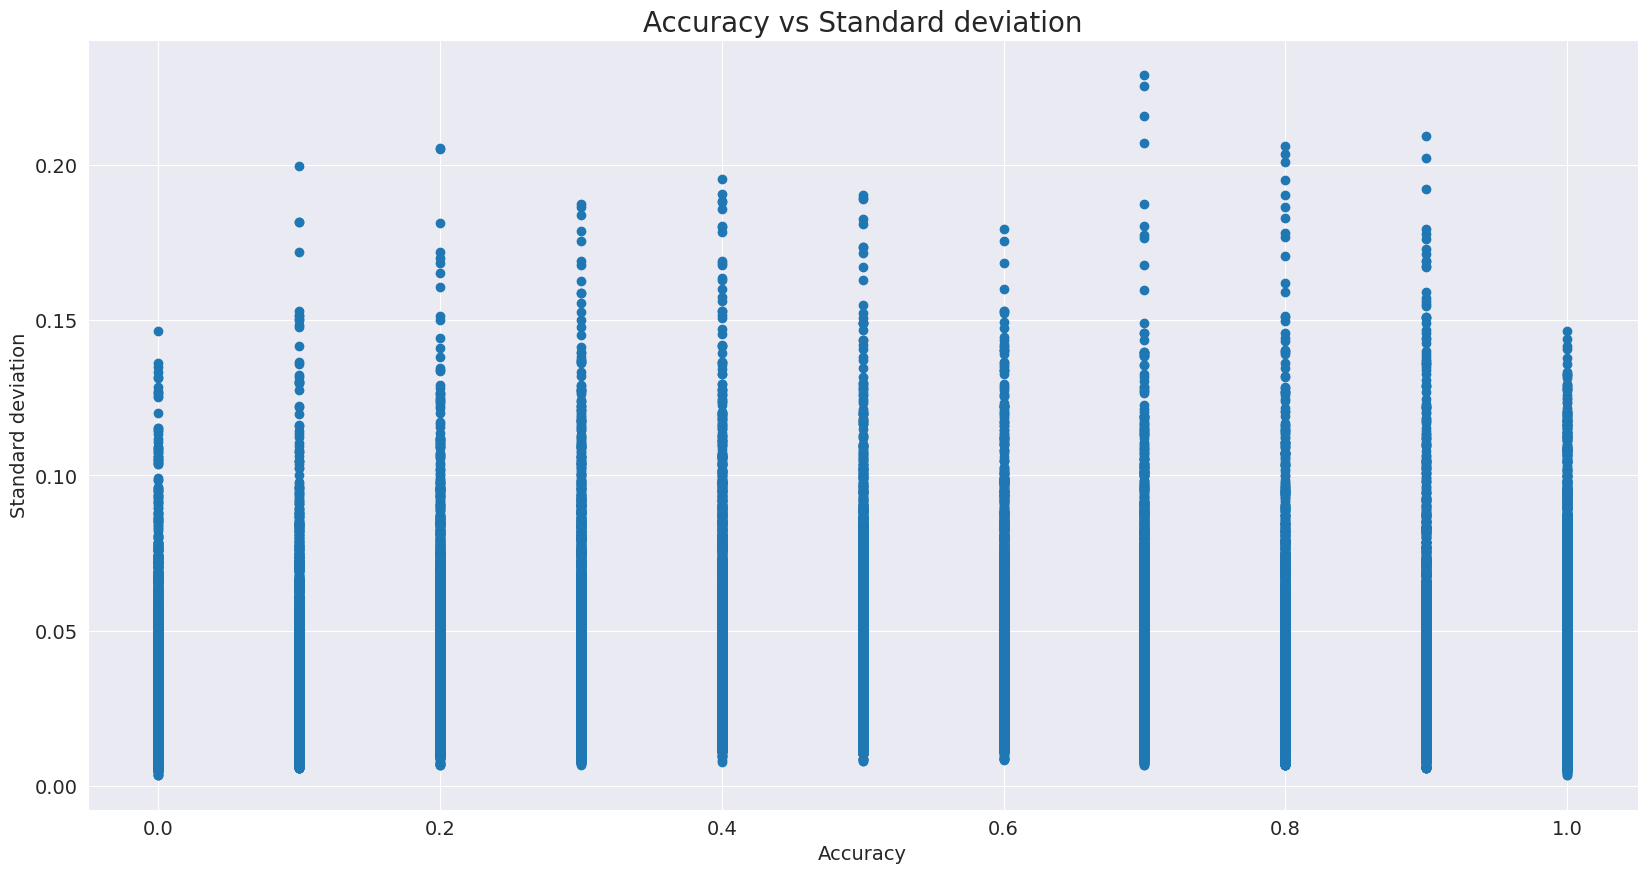

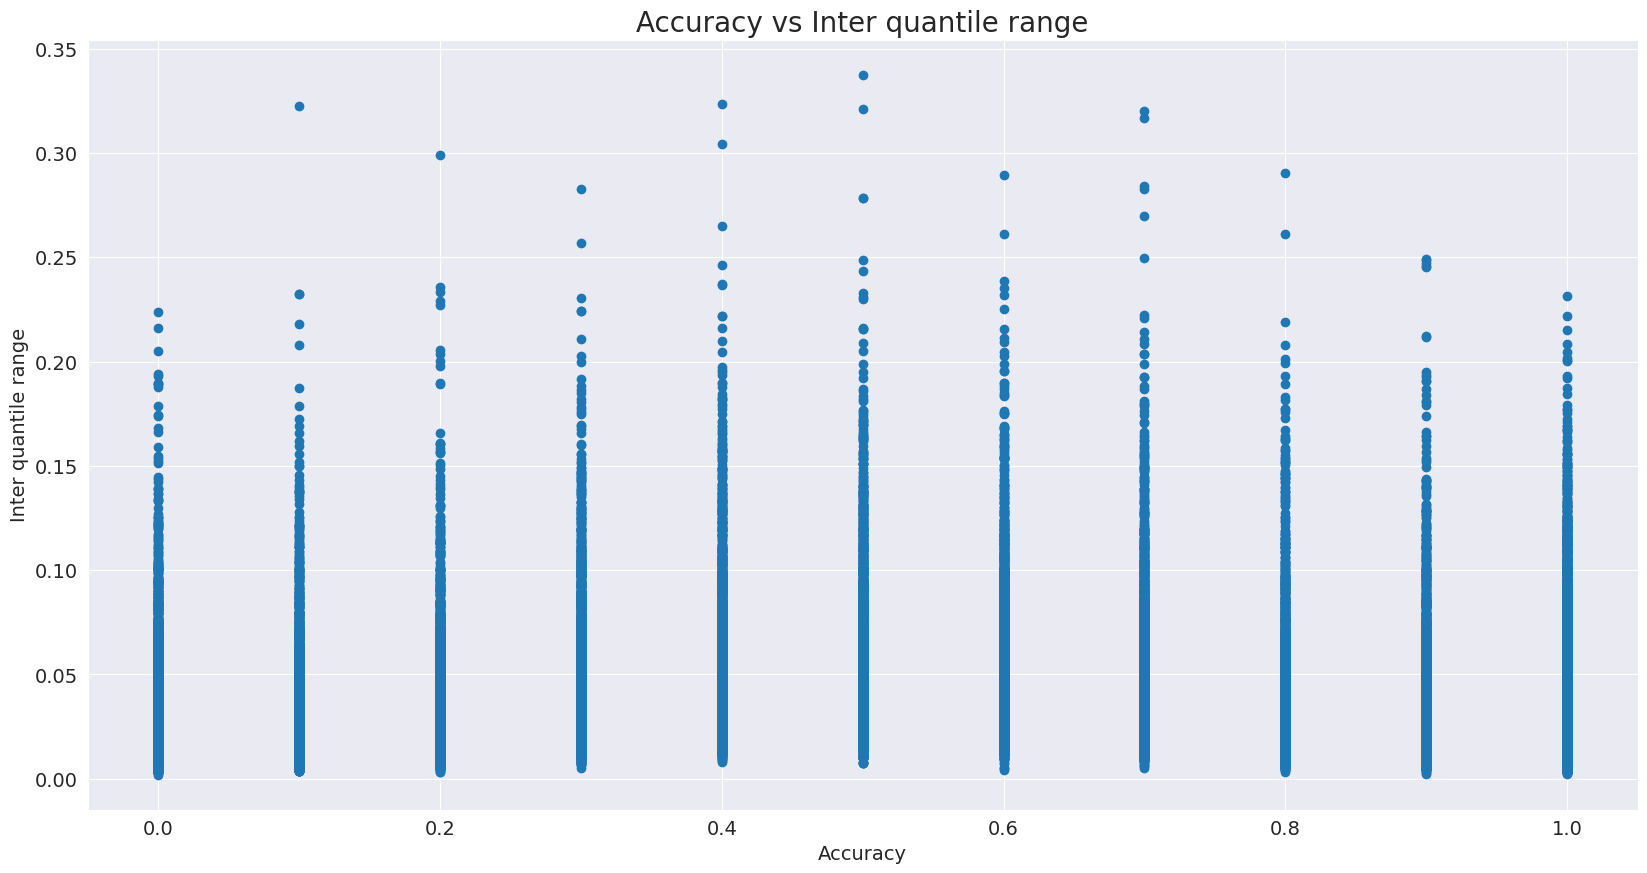

############################## Fairness metrics ##############################

#################### Accuracy ####################
              Race       Sex  Race_Sex
adv       0.525109  0.528998       NaN
disadv    0.537588  0.528048       NaN
Accuracy -0.012479  0.000950       NaN

#################### Disparate_Impact ####################
                      Race       Sex  Race_Sex
adv               0.122829  0.112734       NaN
disadv            0.089219  0.147510       NaN
Disparate_Impact  0.726369  1.308477       NaN

#################### Equal_Opportunity ####################
                       Race       Sex  Race_Sex
adv                0.123209  0.115298       NaN
disadv             0.089505  0.149974       NaN
Equal_Opportunity  0.033704 -0.034676       NaN

#################### Statistical_Parity_Difference ####################
                                   Race       Sex  Race_Sex
adv                            0.262913  0.242103       NaN
disadv             

In [21]:
quantify_uncertainty(TARGET_COLUMN, y_data, imputed_data_dict, imputation_technique='predict-by-sklearn')

### Impute-by-mean technique

X_train_imputed.shape:  (118179, 74)
X_val_imputed.shape:  (39394, 74)
X_test_imputed.shape:  (39394, 74)


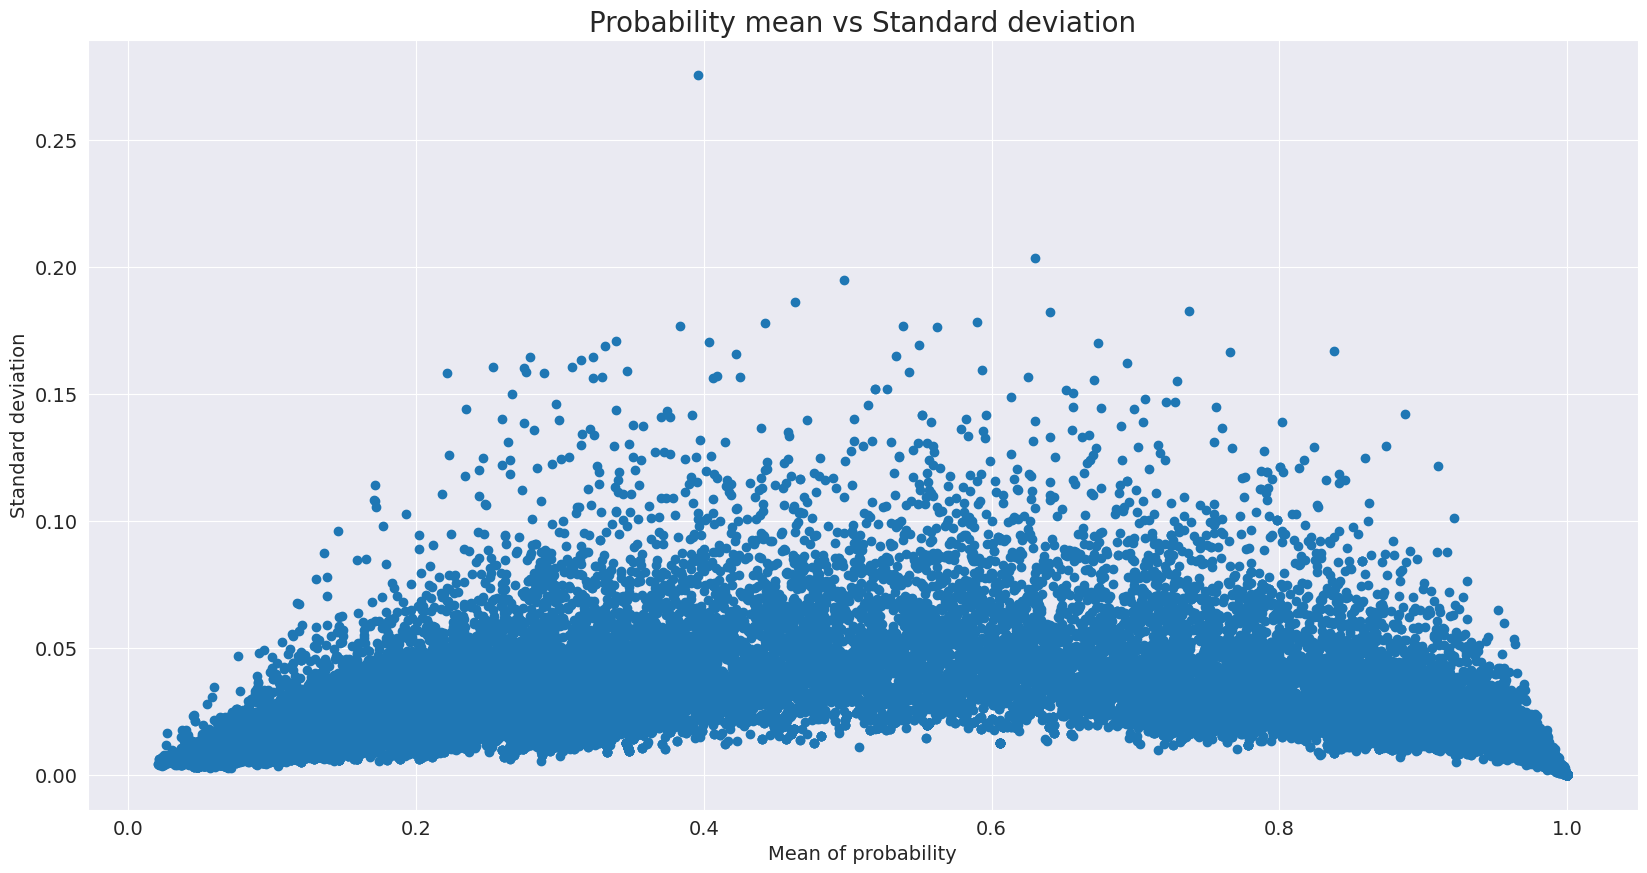

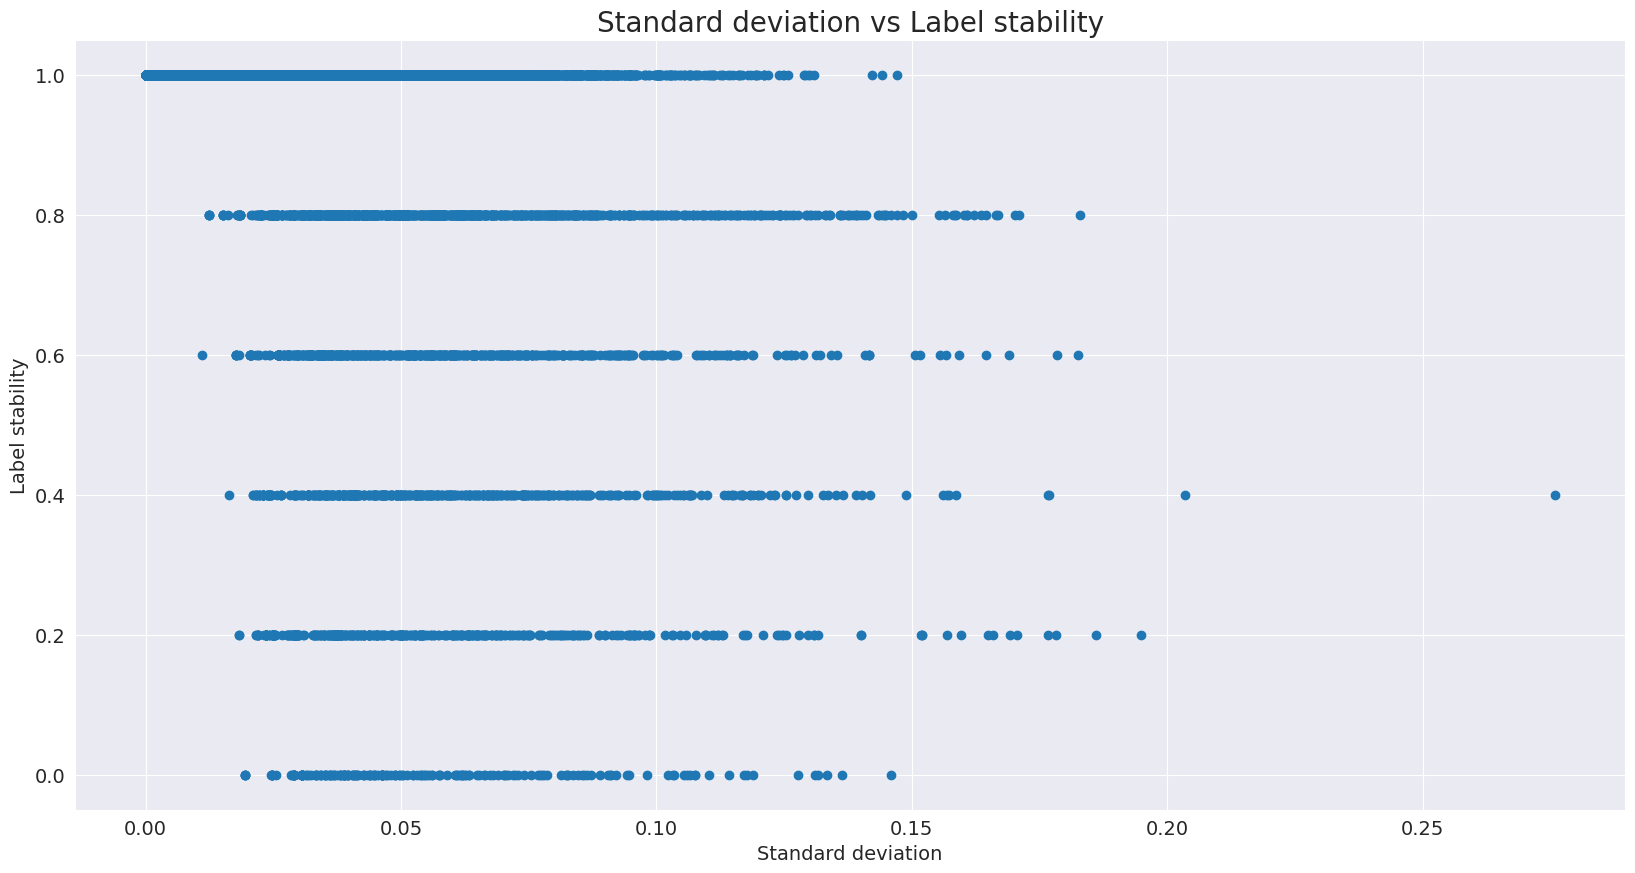

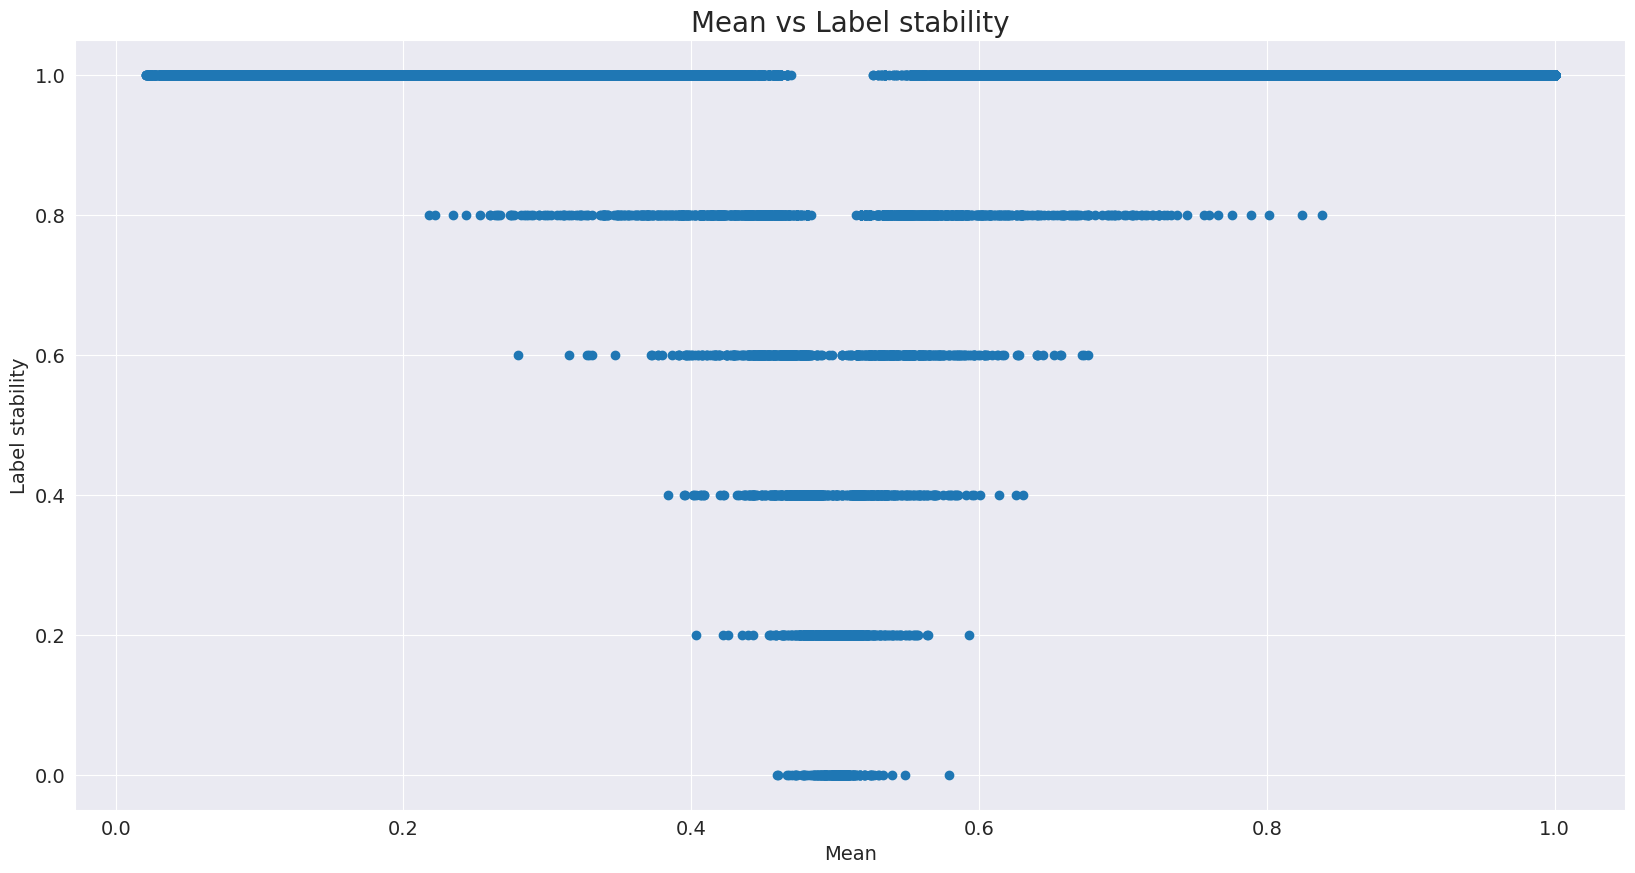

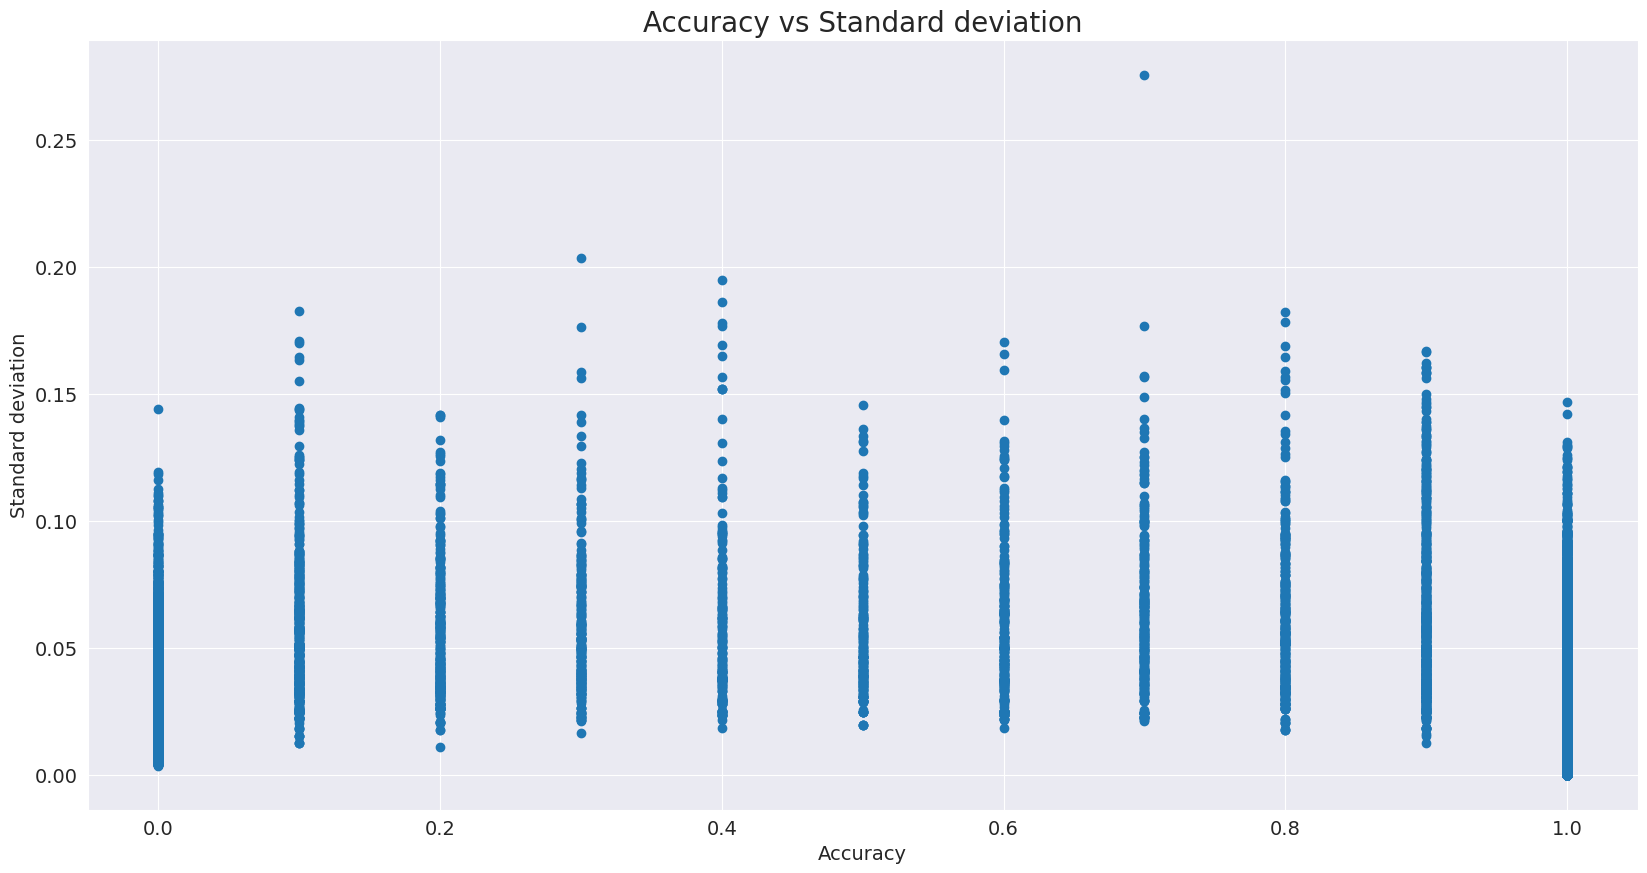

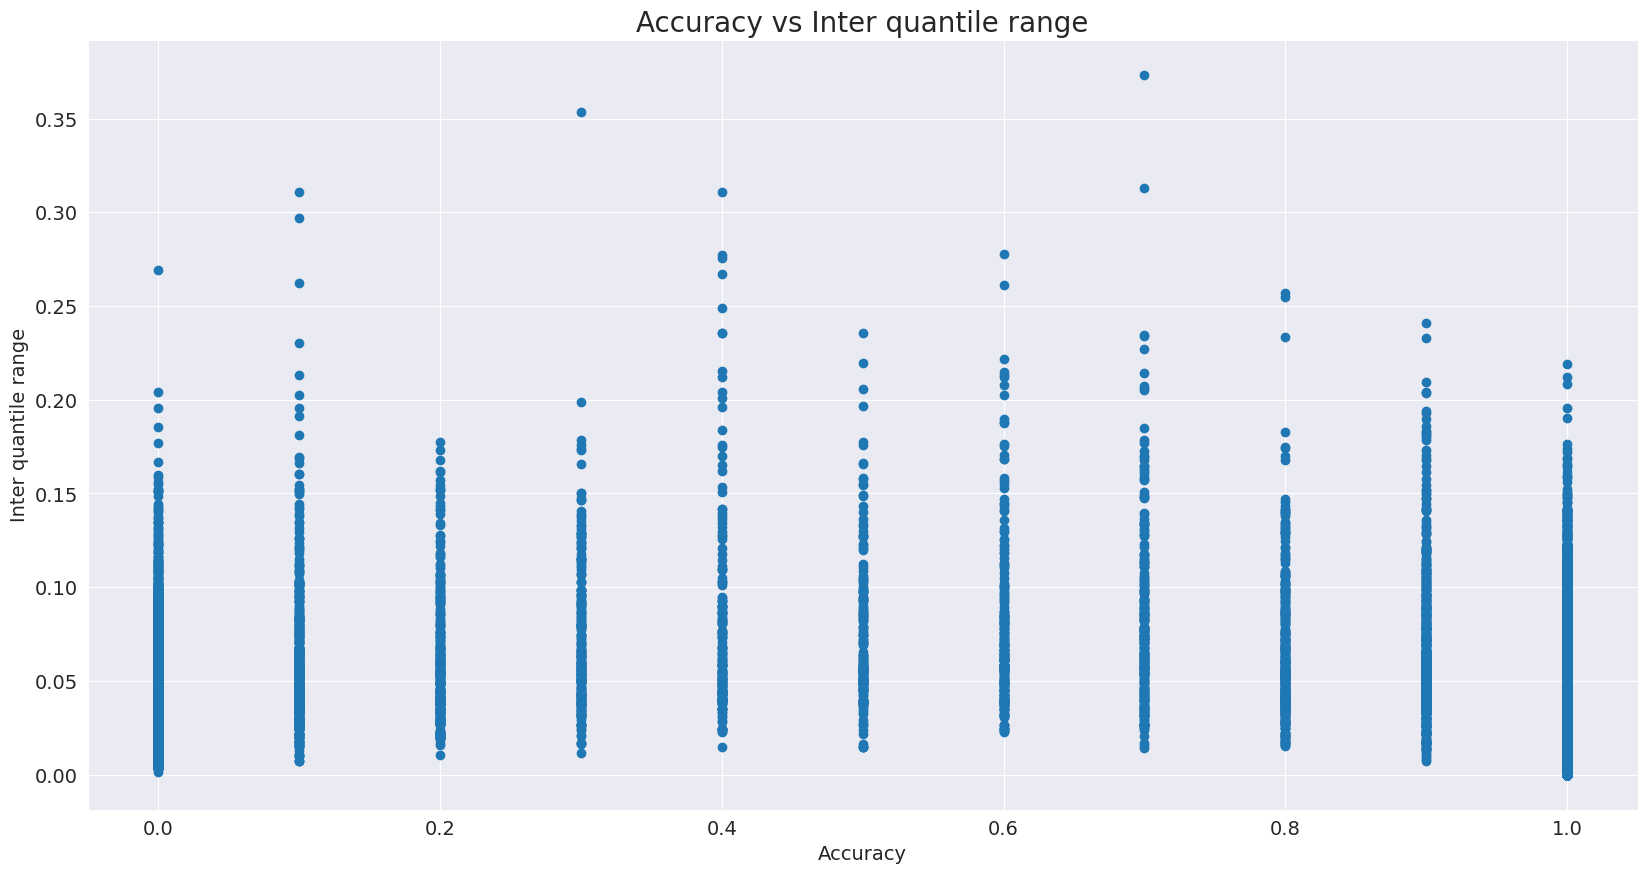

############################## Fairness metrics ##############################

#################### Accuracy ####################
              Race       Sex  Race_Sex
adv       0.829161  0.850126  0.851707
disadv    0.823833  0.808773  0.826271
Accuracy  0.005328  0.041353  0.025436

#################### Disparate_Impact ####################
                      Race       Sex  Race_Sex
adv               0.512771  0.518912  0.531033
disadv            0.455390  0.494498  0.469954
Disparate_Impact  0.888096  0.952953  0.884980

#################### Equal_Opportunity ####################
                       Race       Sex  Race_Sex
adv                0.862468  0.878298  0.880547
disadv             0.836318  0.845070  0.839365
Equal_Opportunity  0.026150  0.033228  0.041182

#################### Statistical_Parity_Difference ####################
                                   Race       Sex  Race_Sex
adv                            1.087137  1.063866  1.055980
disadv             

In [22]:
quantify_uncertainty(TARGET_COLUMN, y_data, imputed_data_dict, imputation_technique='impute-by-mean')

### Impute-by-mean-trimmed technique

X_train_imputed.shape:  (118179, 74)
X_val_imputed.shape:  (39394, 74)
X_test_imputed.shape:  (39394, 74)


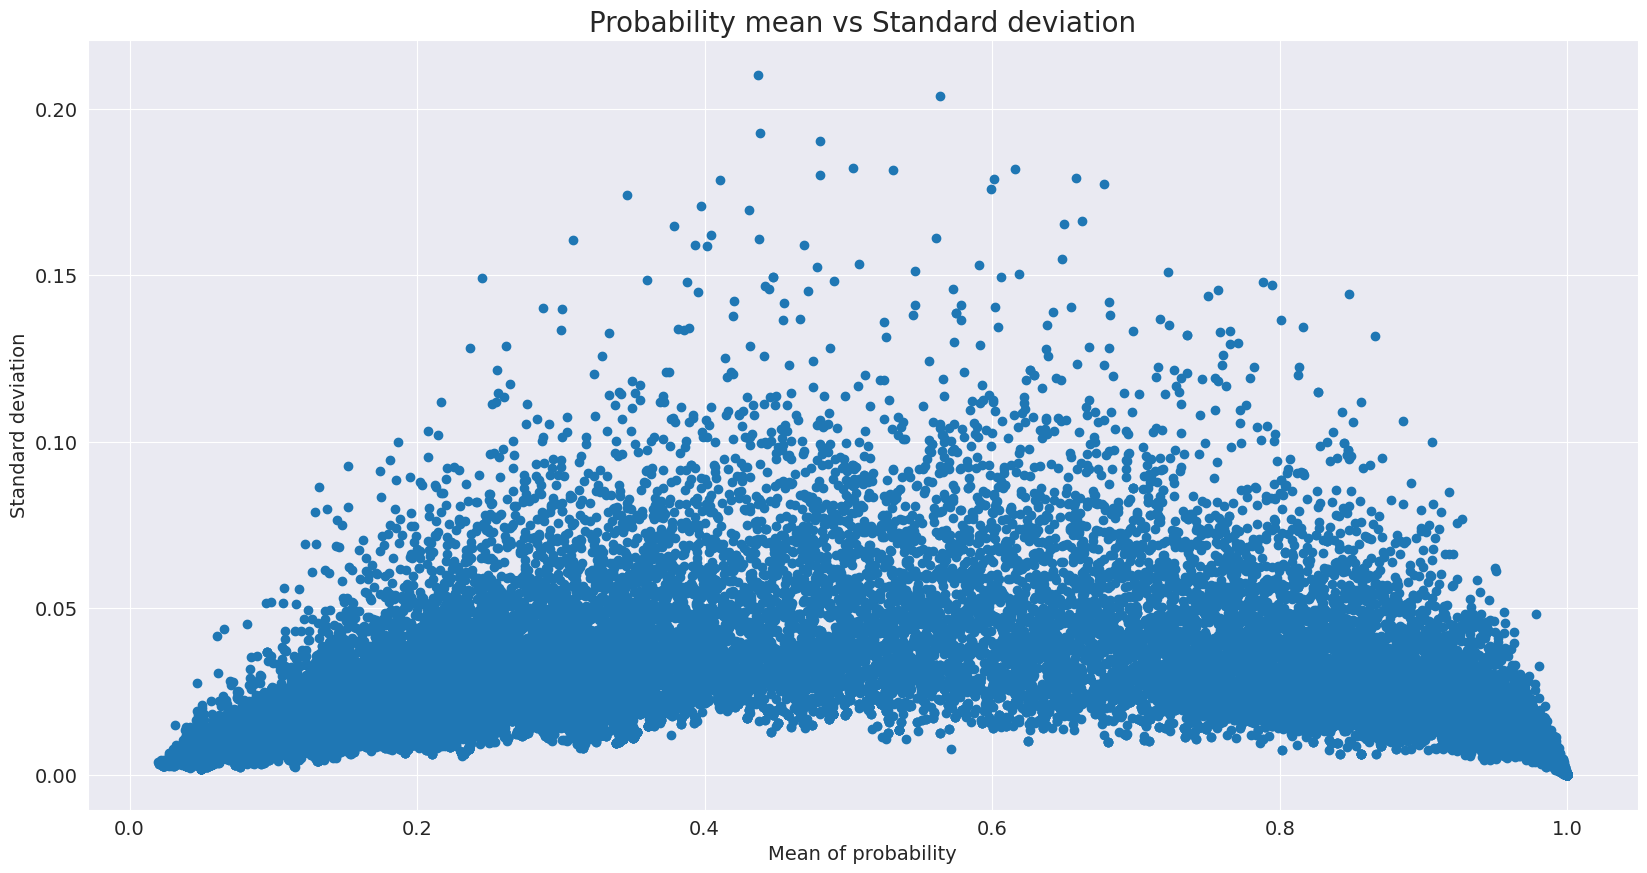

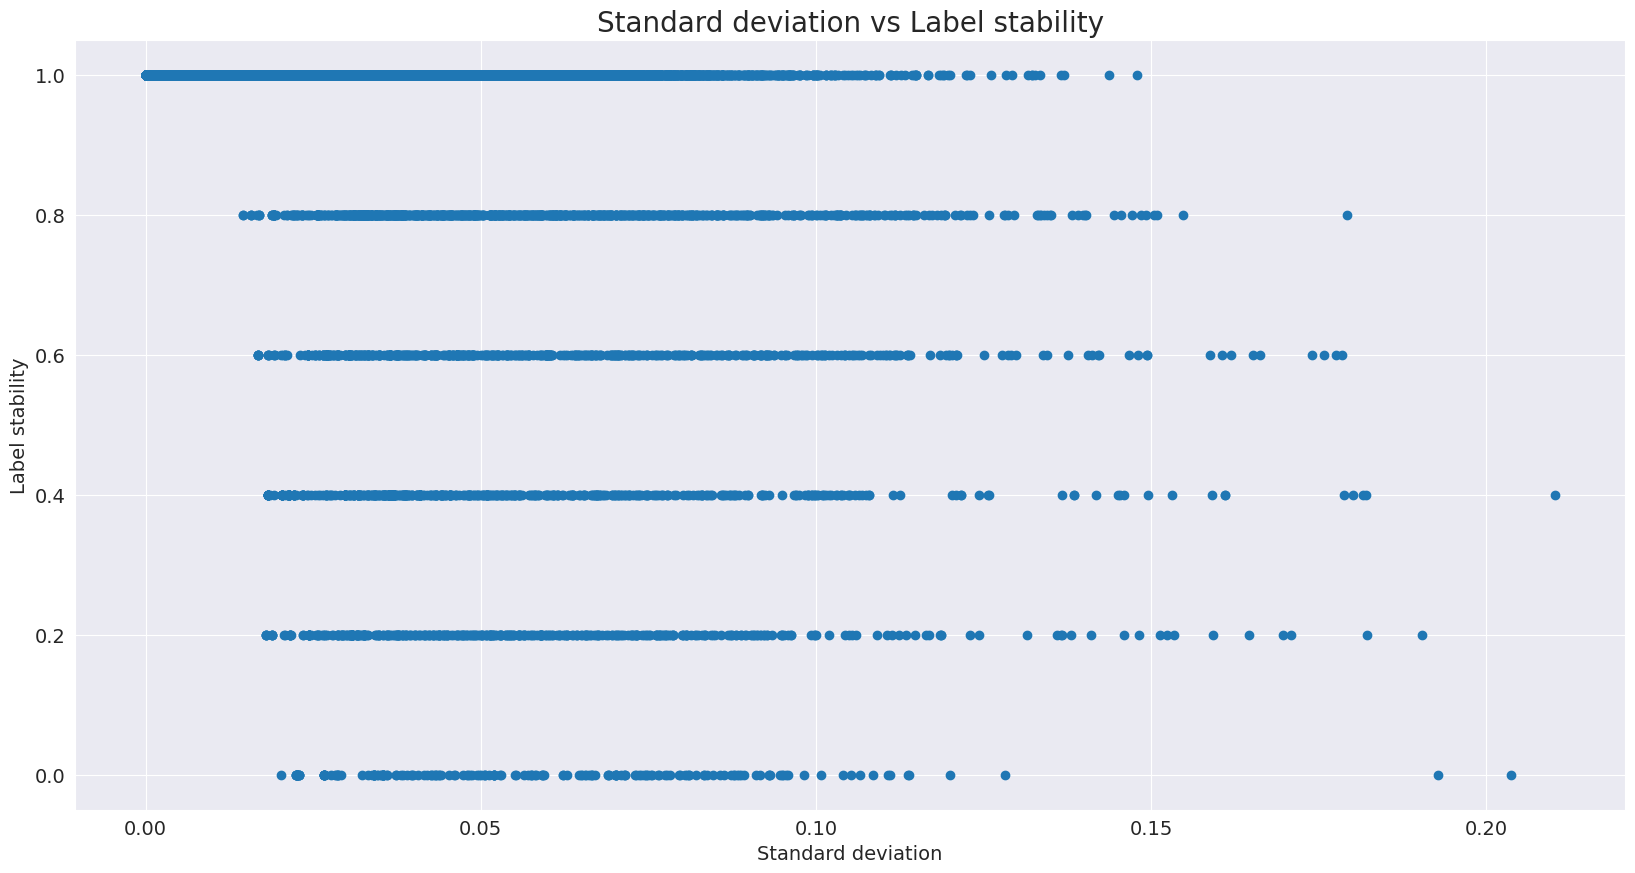

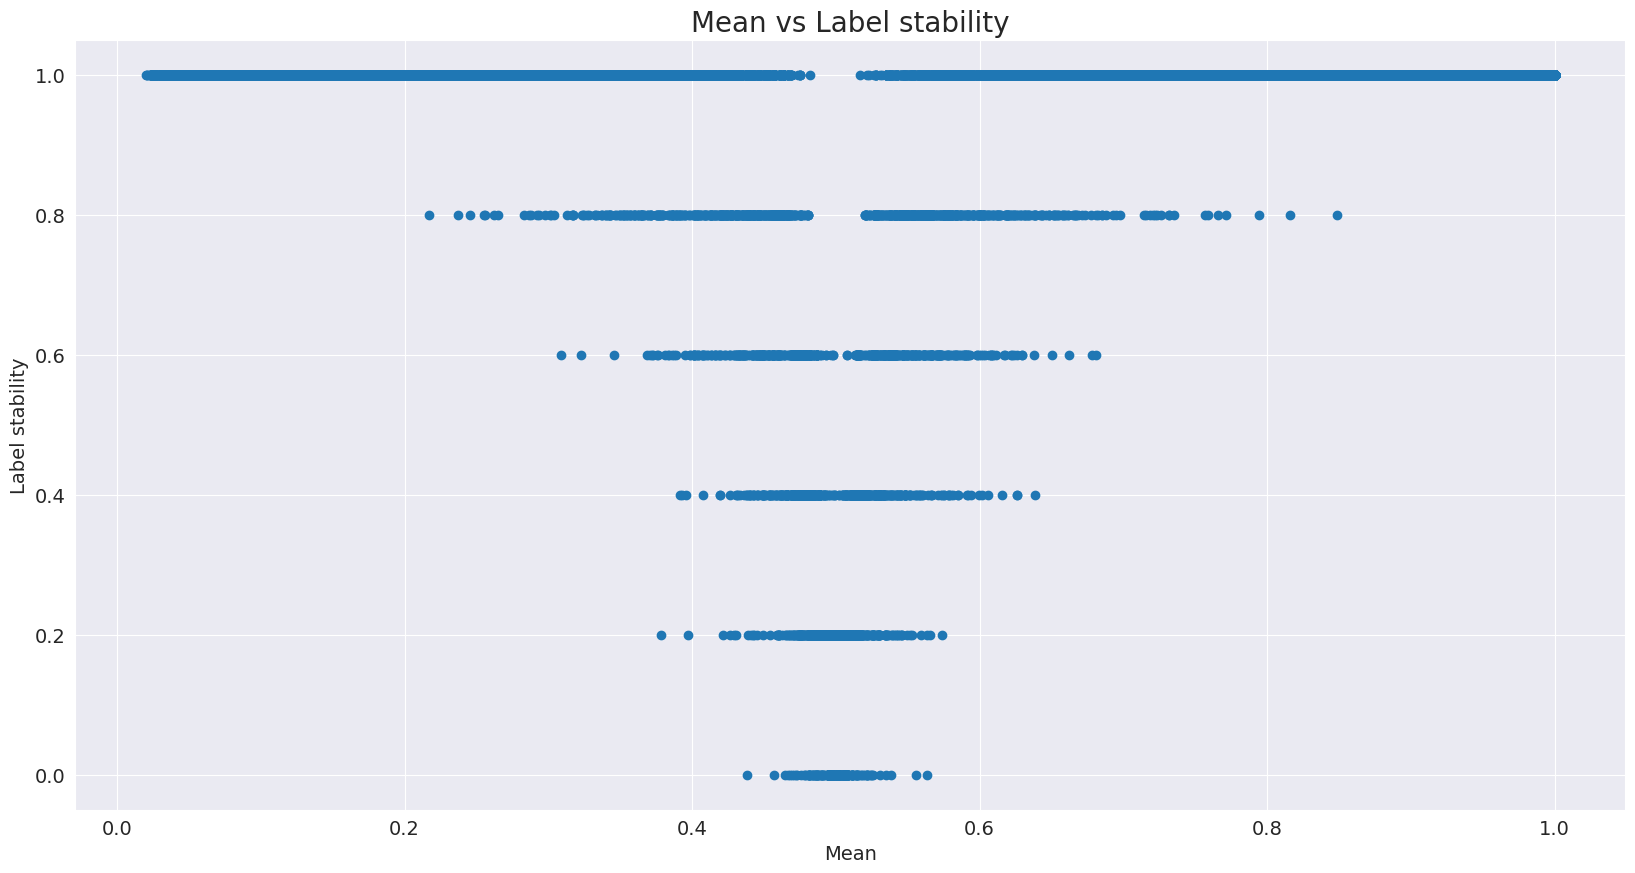

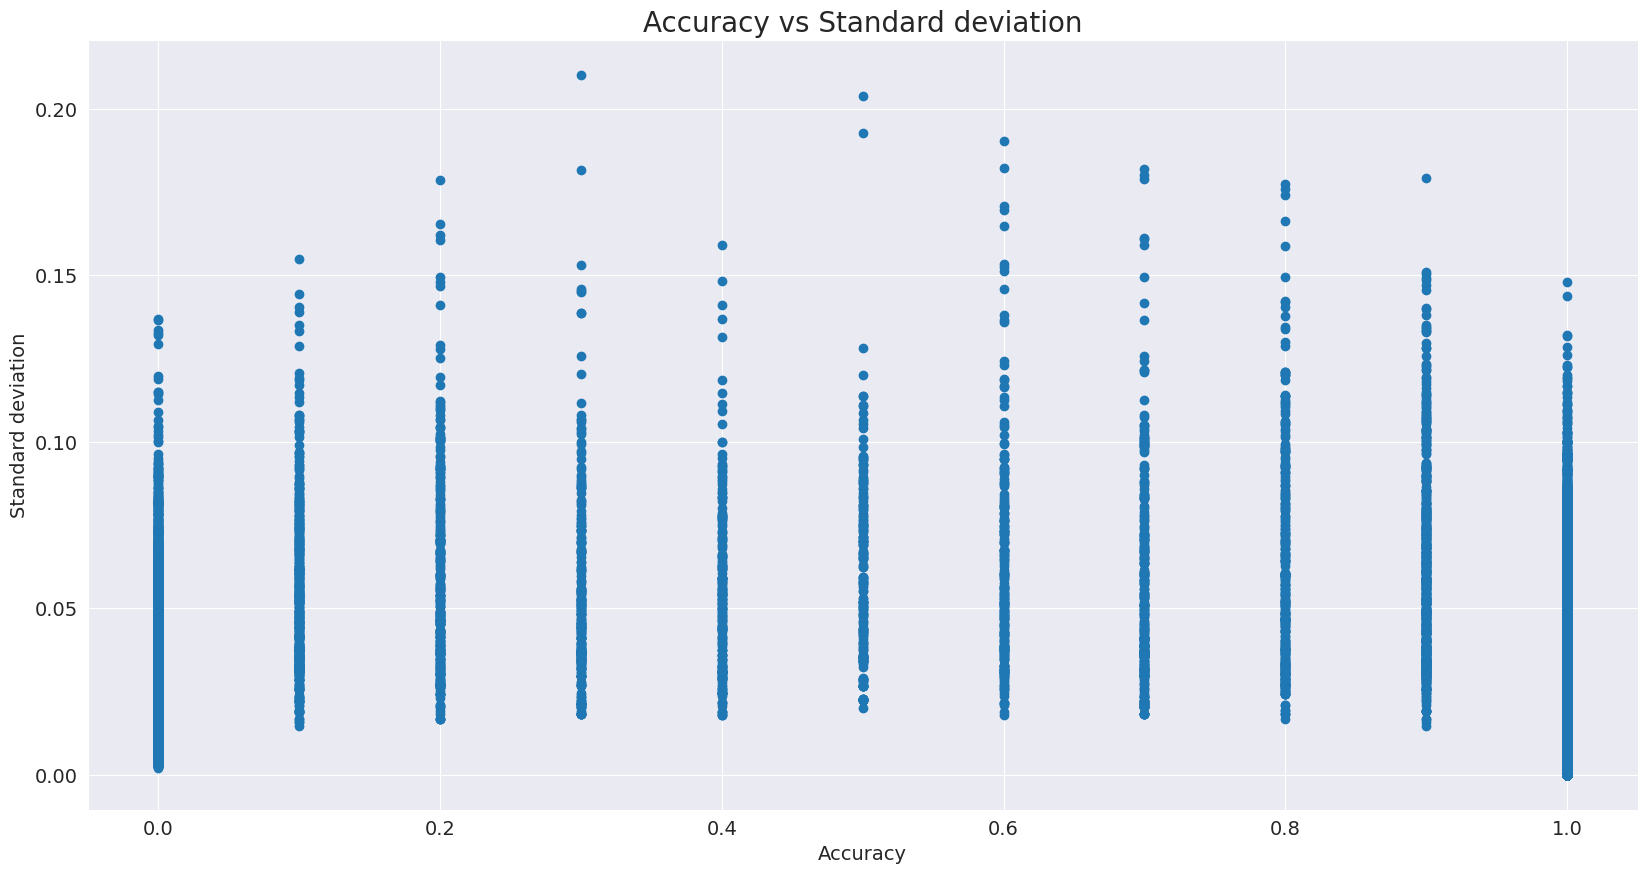

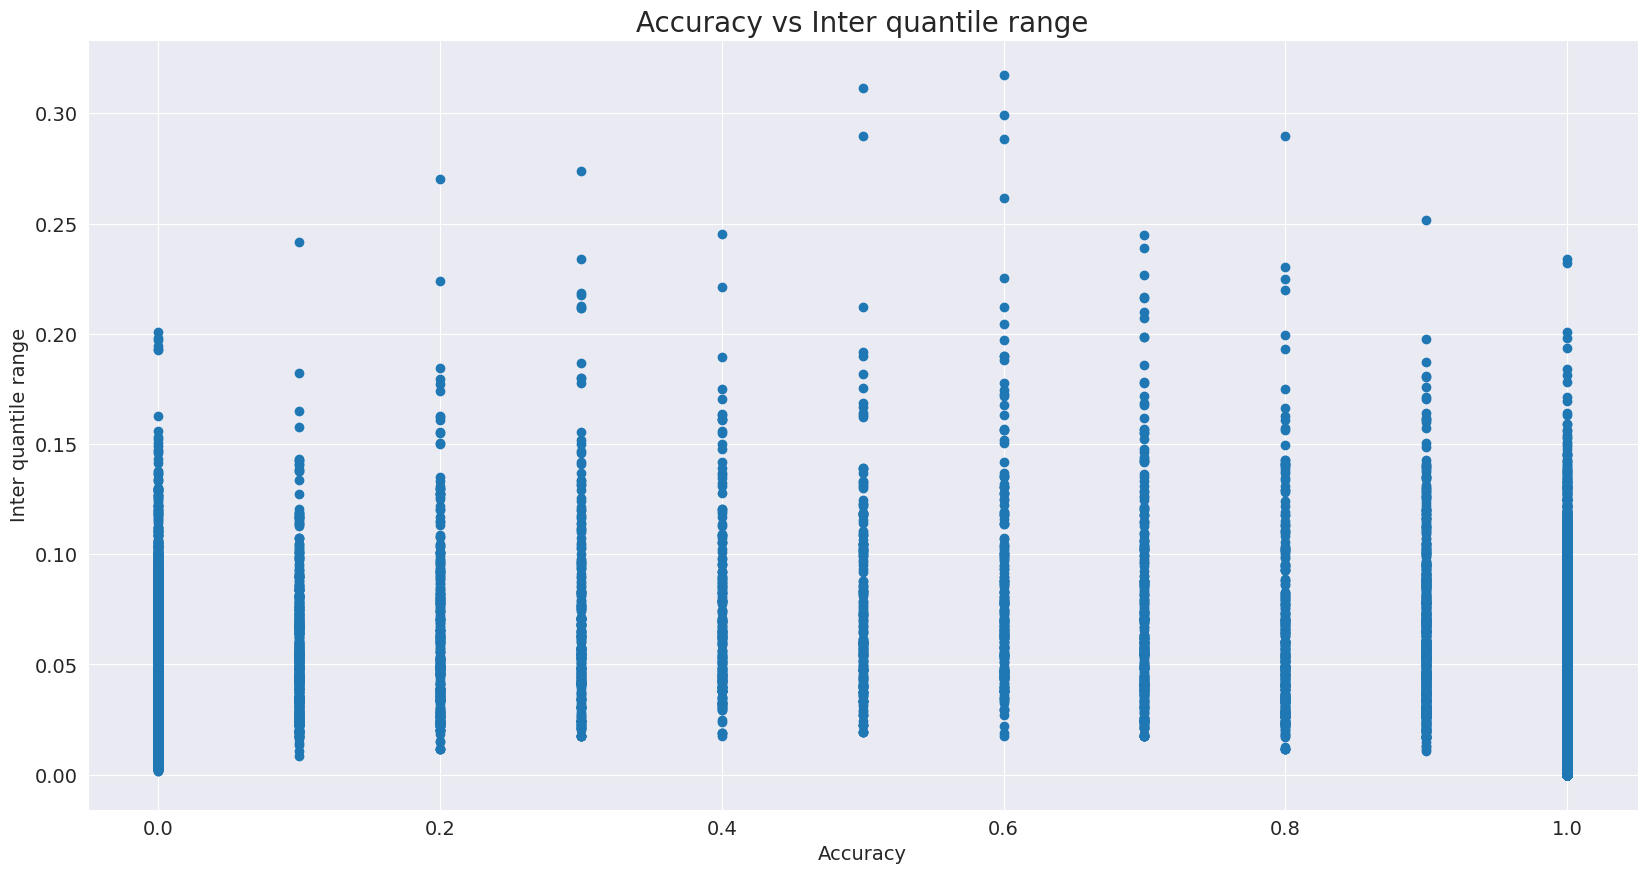

############################## Fairness metrics ##############################

#################### Accuracy ####################
              Race       Sex  Race_Sex
adv       0.828907  0.849811  0.851855
disadv    0.824246  0.808233  0.826271
Accuracy  0.004661  0.041578  0.025583

#################### Disparate_Impact ####################
                      Race       Sex  Race_Sex
adv               0.513965  0.519647  0.531181
disadv            0.457456  0.496218  0.471495
Disparate_Impact  0.890052  0.954913  0.887635

#################### Equal_Opportunity ####################
                       Race       Sex  Race_Sex
adv                0.863466  0.878729  0.880840
disadv             0.839303  0.846412  0.841130
Equal_Opportunity  0.024162  0.032317  0.039711

#################### Statistical_Parity_Difference ####################
                                   Race       Sex  Race_Sex
adv                            1.089668  1.065374  1.056274
disadv             

In [23]:
quantify_uncertainty(TARGET_COLUMN, y_data, imputed_data_dict, imputation_technique='impute-by-mean-trimmed')

### Impute-by-mean-conditional_SEX technique

X_train_imputed.shape:  (118179, 74)
X_val_imputed.shape:  (39394, 74)
X_test_imputed.shape:  (39394, 74)


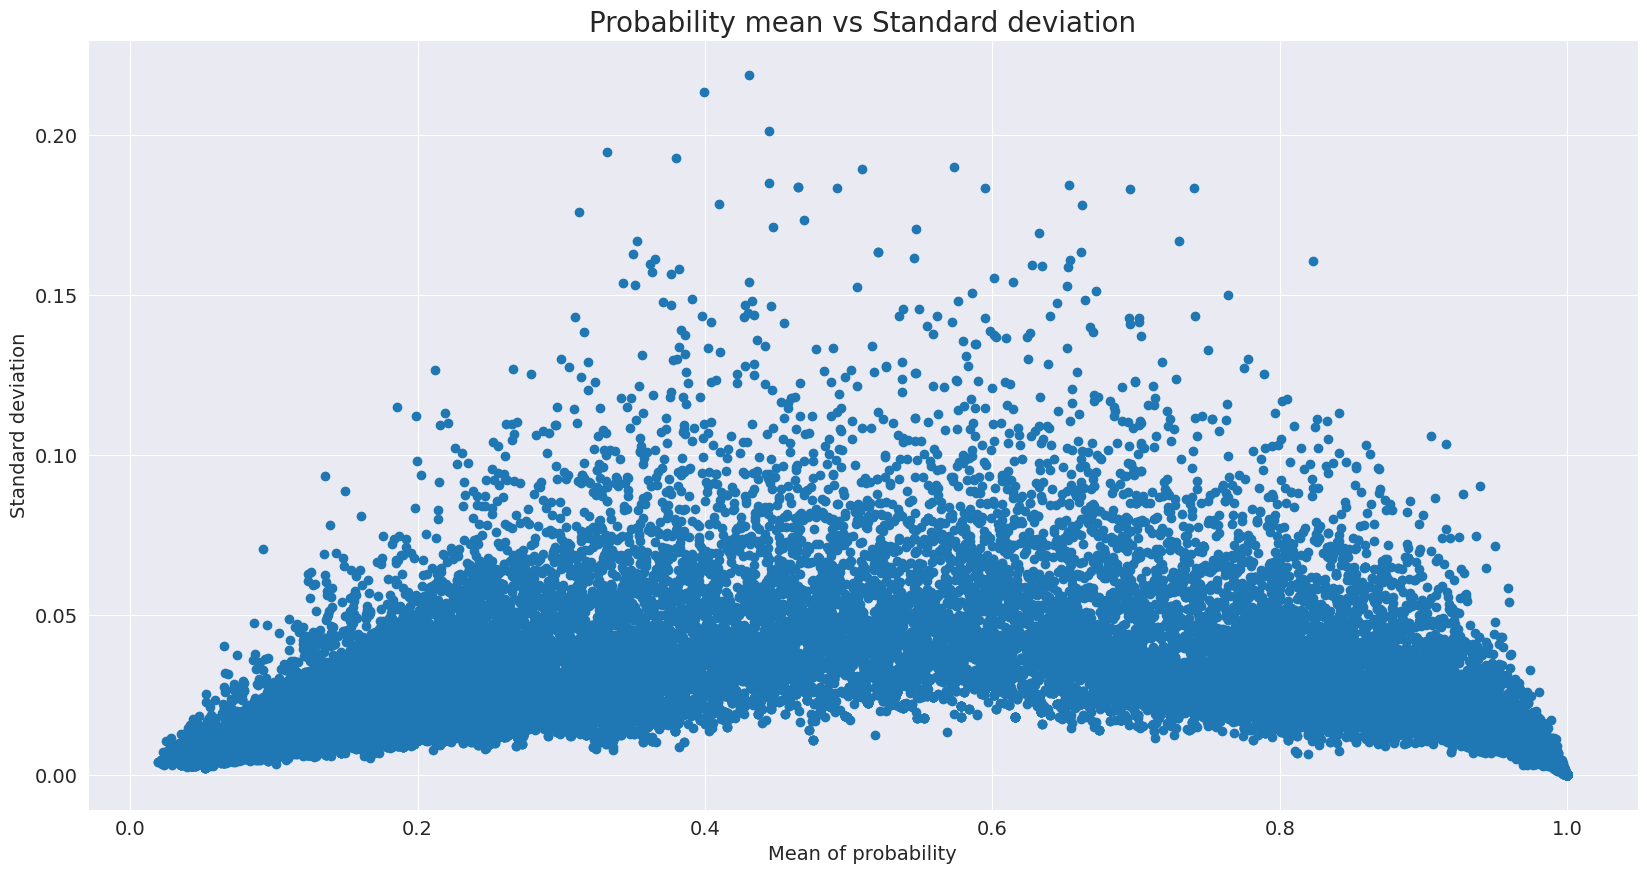

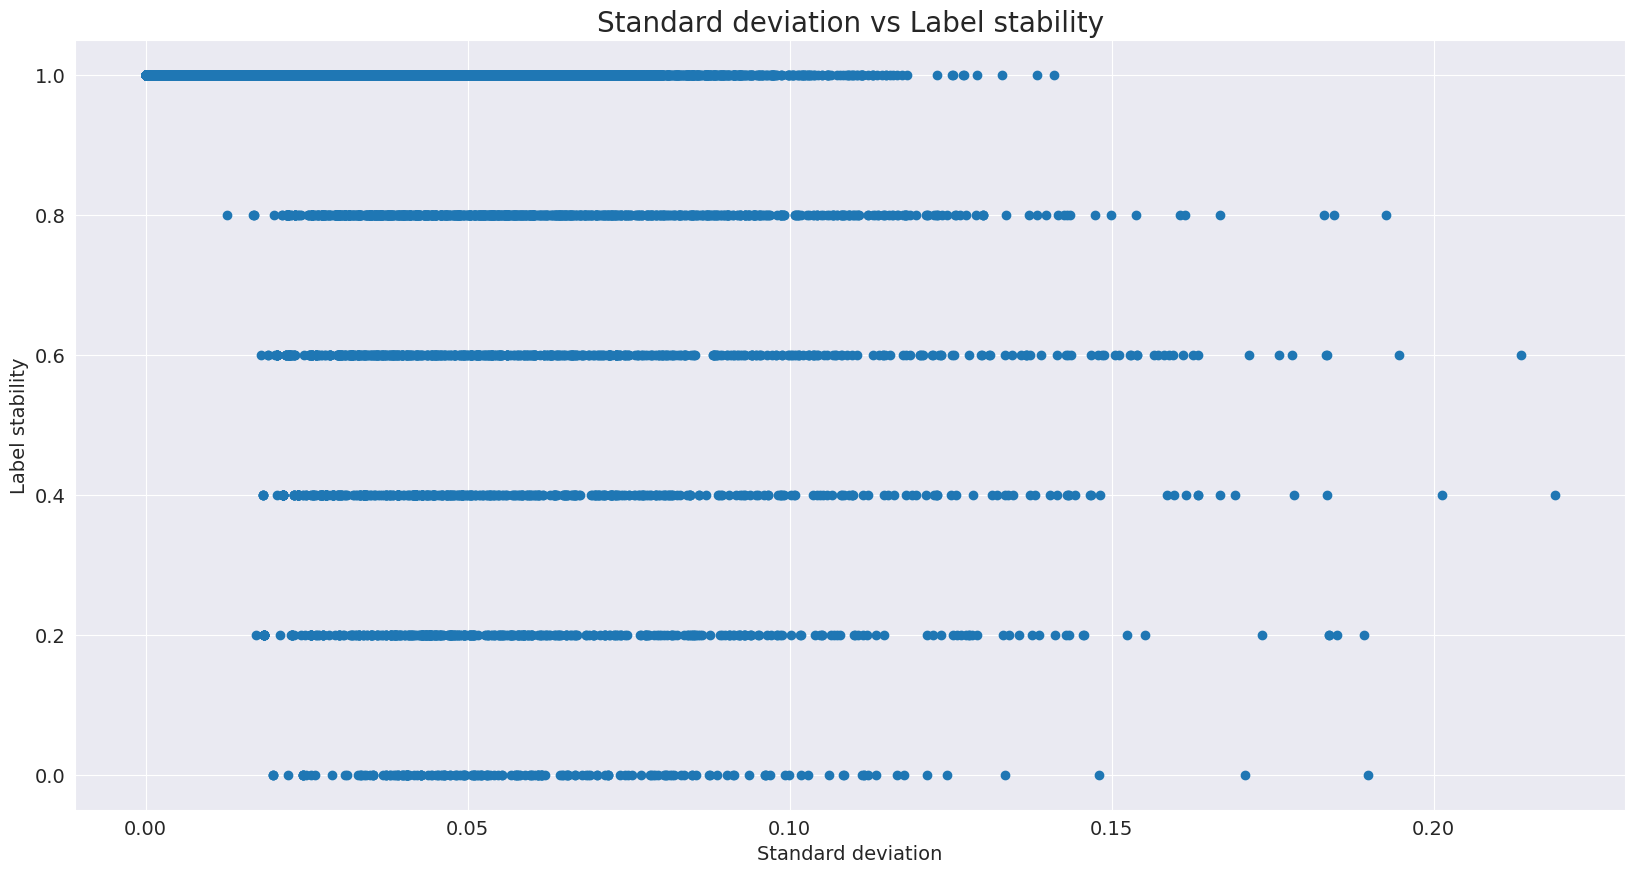

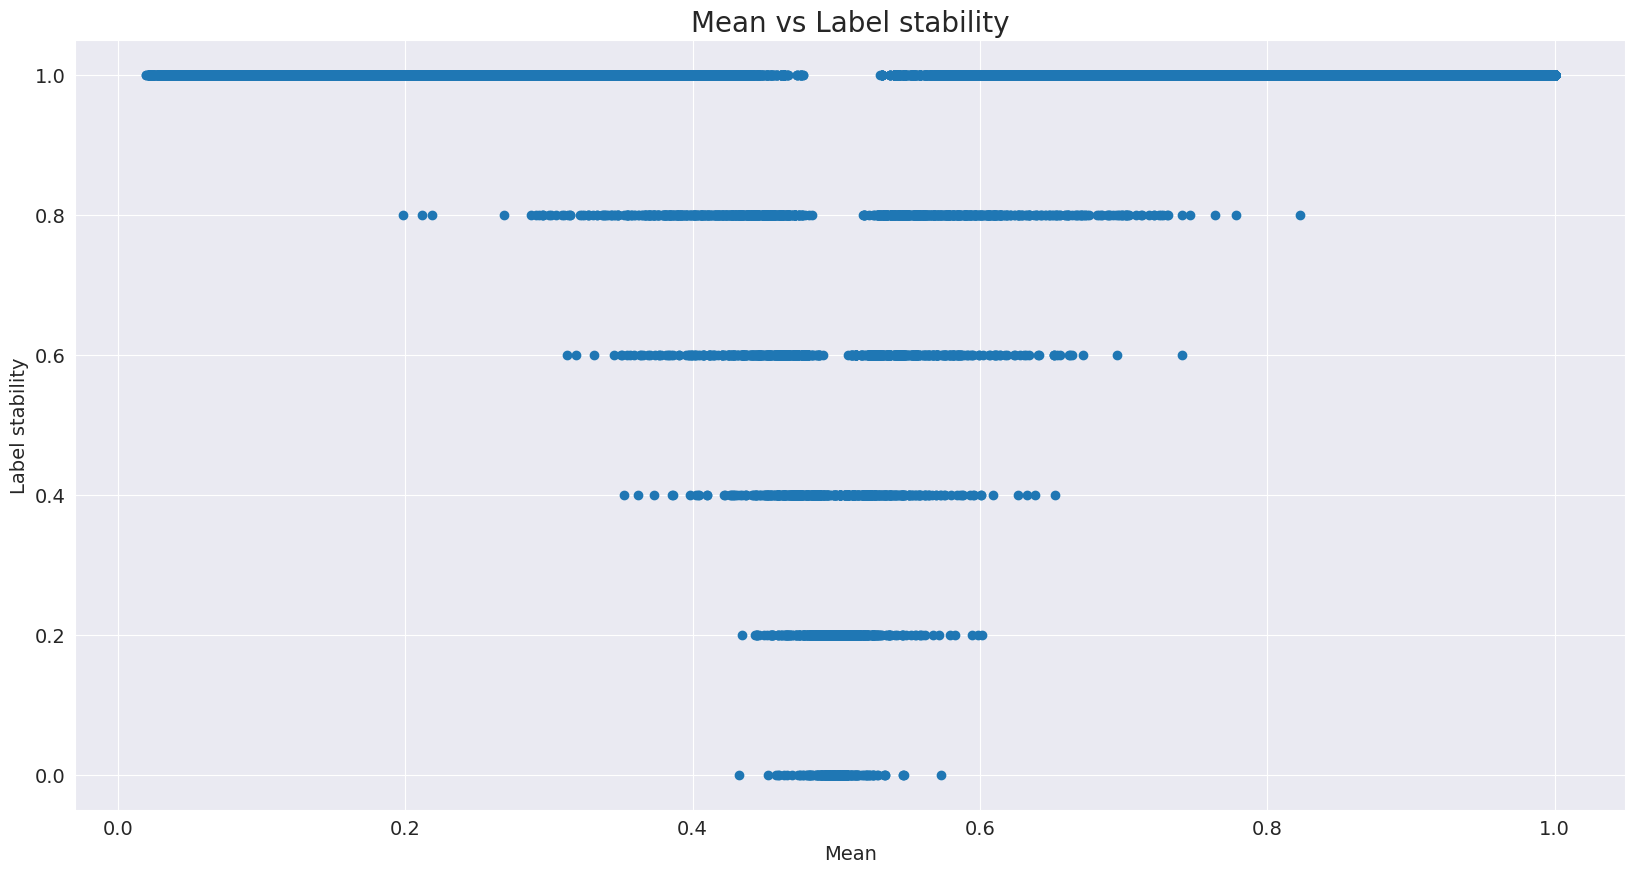

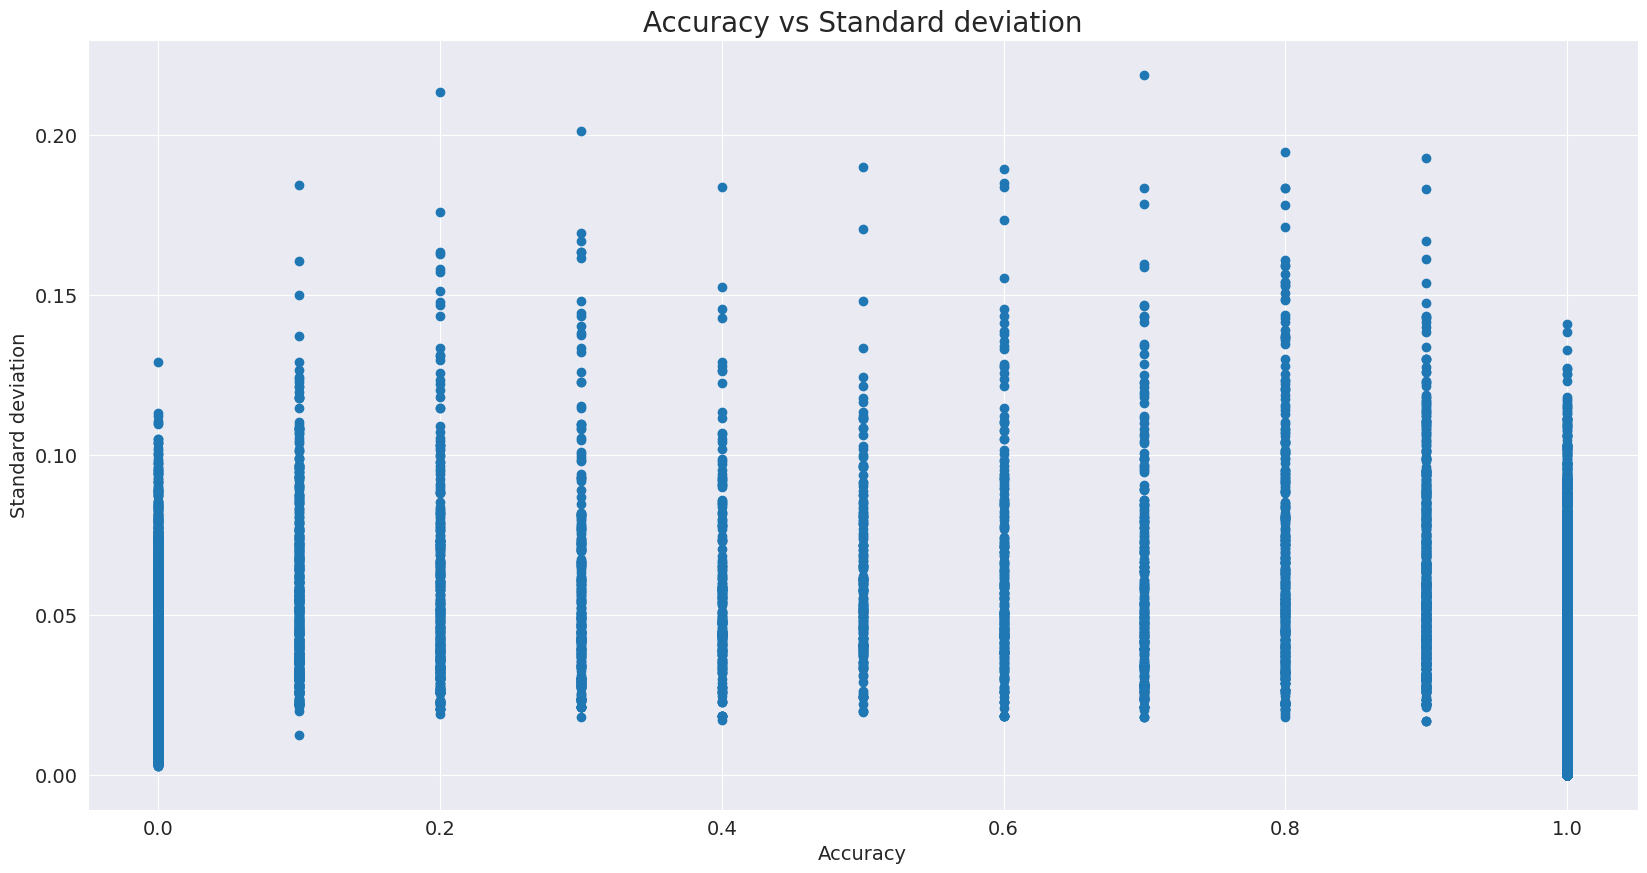

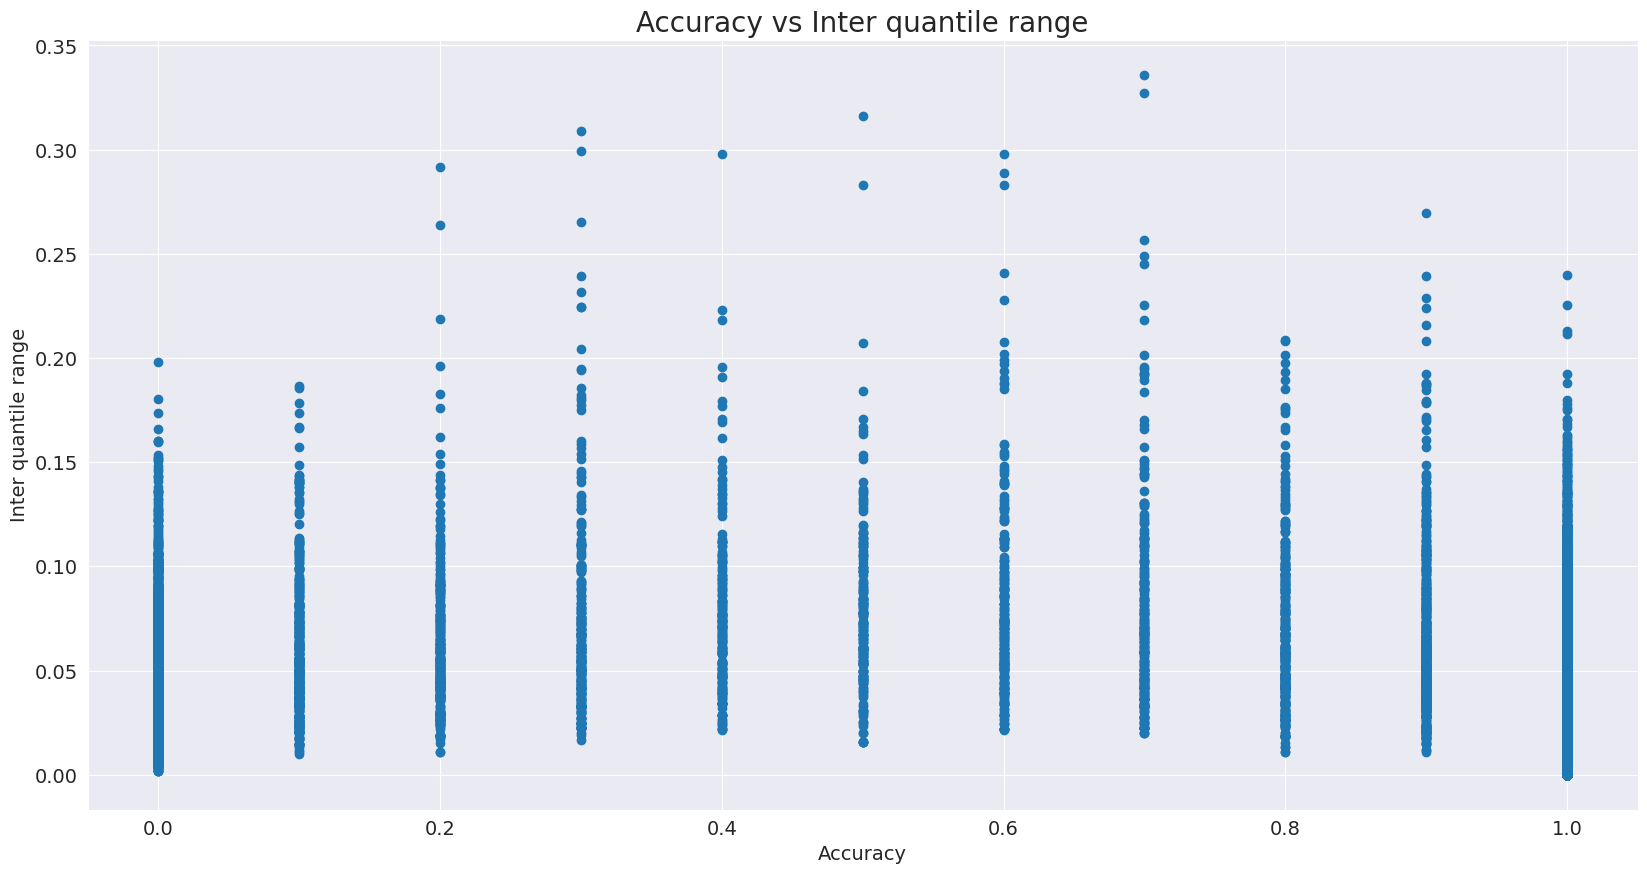

############################## Fairness metrics ##############################

#################### Accuracy ####################
              Race       Sex  Race_Sex
adv       0.828980  0.849968  0.851707
disadv    0.823833  0.808675  0.825116
Accuracy  0.005147  0.041294  0.026591

#################### Disparate_Impact ####################
                      Race       Sex  Race_Sex
adv               0.512518  0.518124  0.529703
disadv            0.455390  0.494204  0.469569
Disparate_Impact  0.888535  0.953834  0.886475

#################### Equal_Opportunity ####################
                       Race       Sex  Race_Sex
adv                0.862008  0.877329  0.879224
disadv             0.836318  0.844623  0.837599
Equal_Opportunity  0.025690  0.032706  0.041625

#################### Statistical_Parity_Difference ####################
                                   Race       Sex  Race_Sex
adv                            1.086600  1.062251  1.053335
disadv             

In [24]:
quantify_uncertainty(TARGET_COLUMN, y_data, imputed_data_dict, imputation_technique='impute-by-mean-conditional_SEX')

### Impute-by-mean-conditional_RAC1P technique

X_train_imputed.shape:  (118179, 74)
X_val_imputed.shape:  (39394, 74)
X_test_imputed.shape:  (39394, 74)


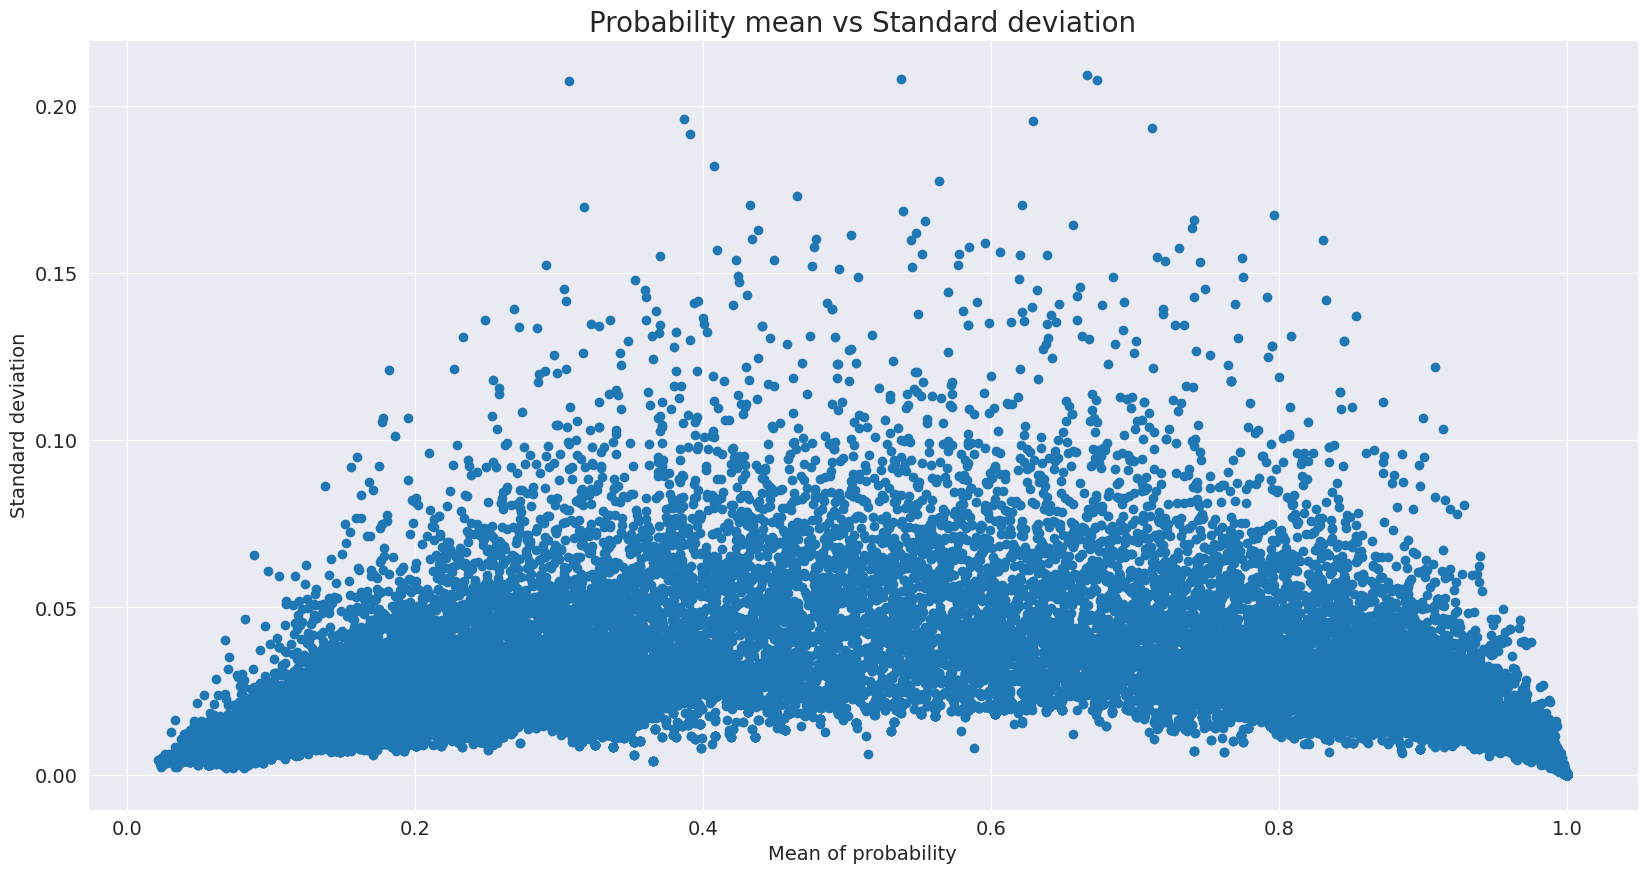

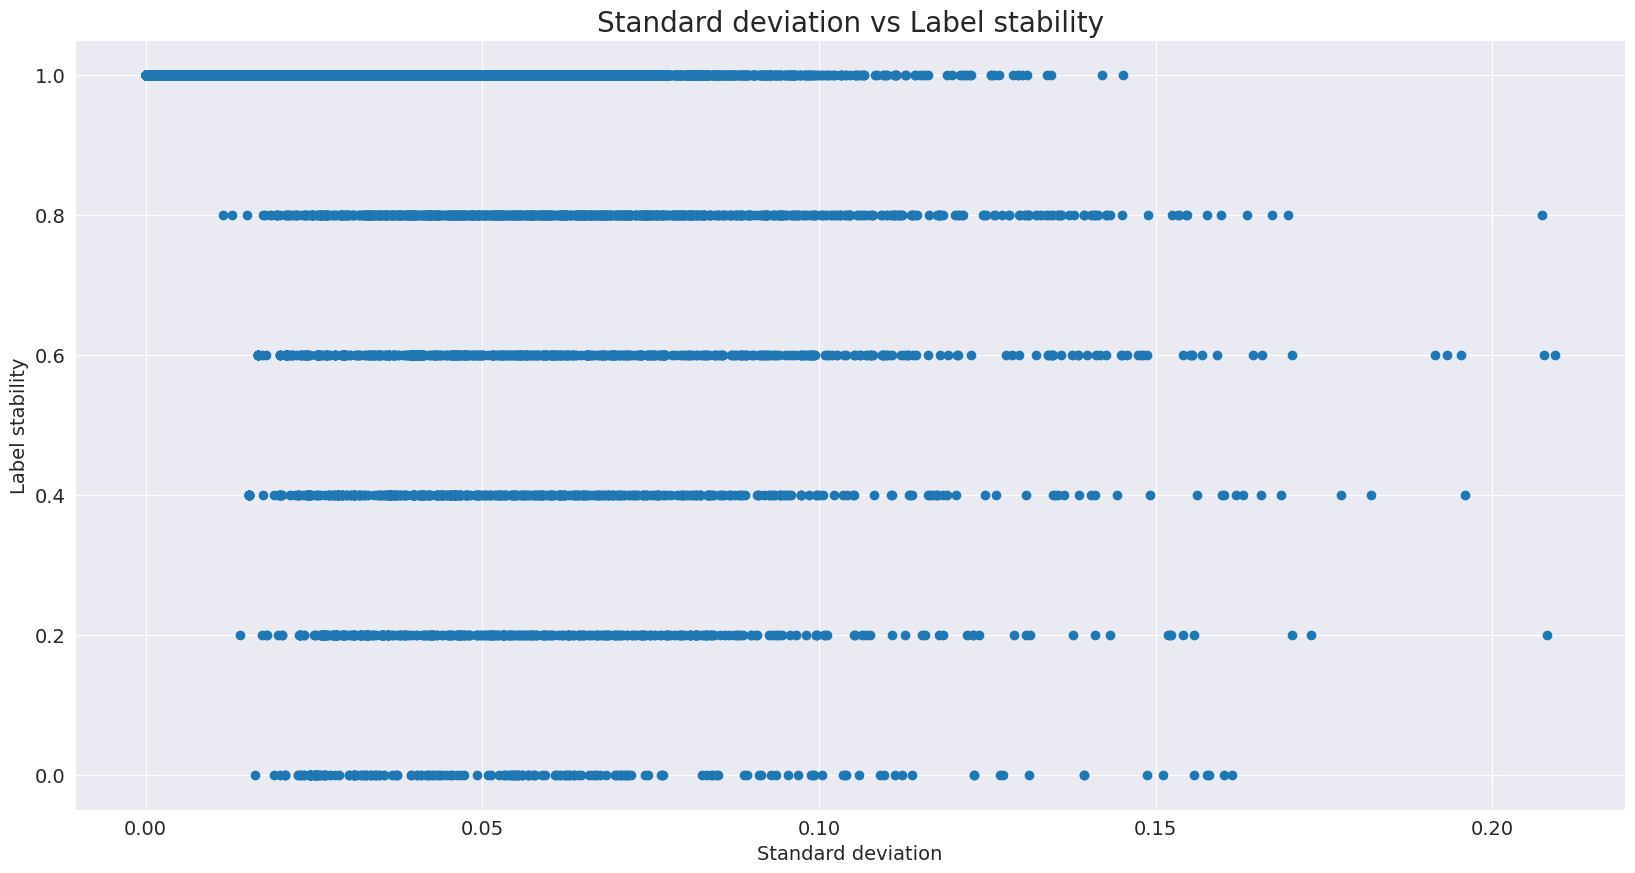

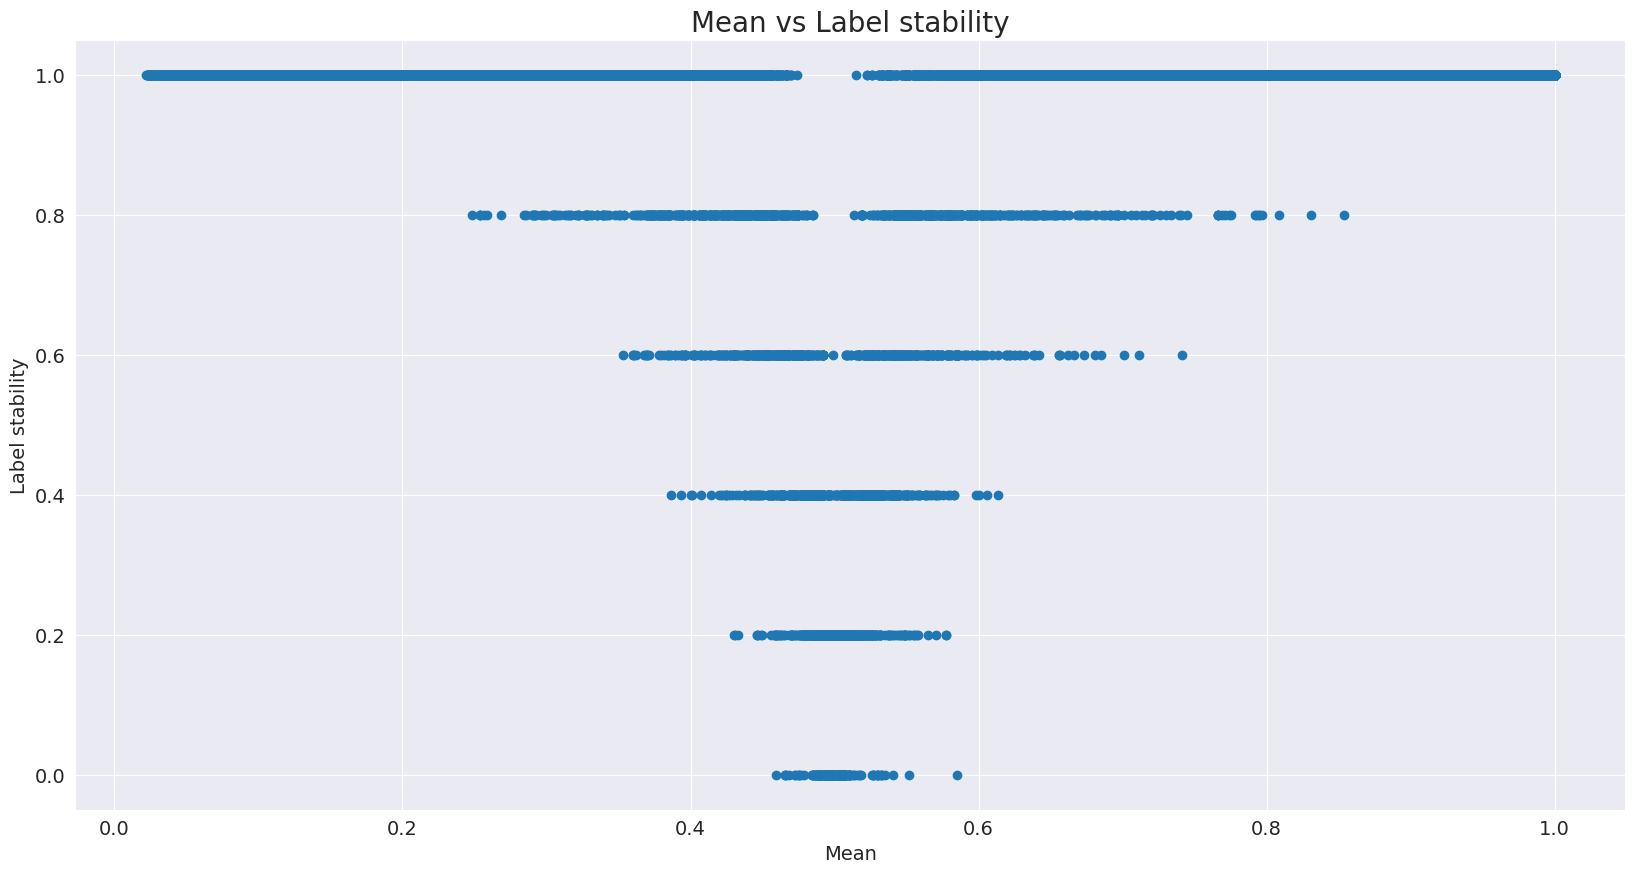

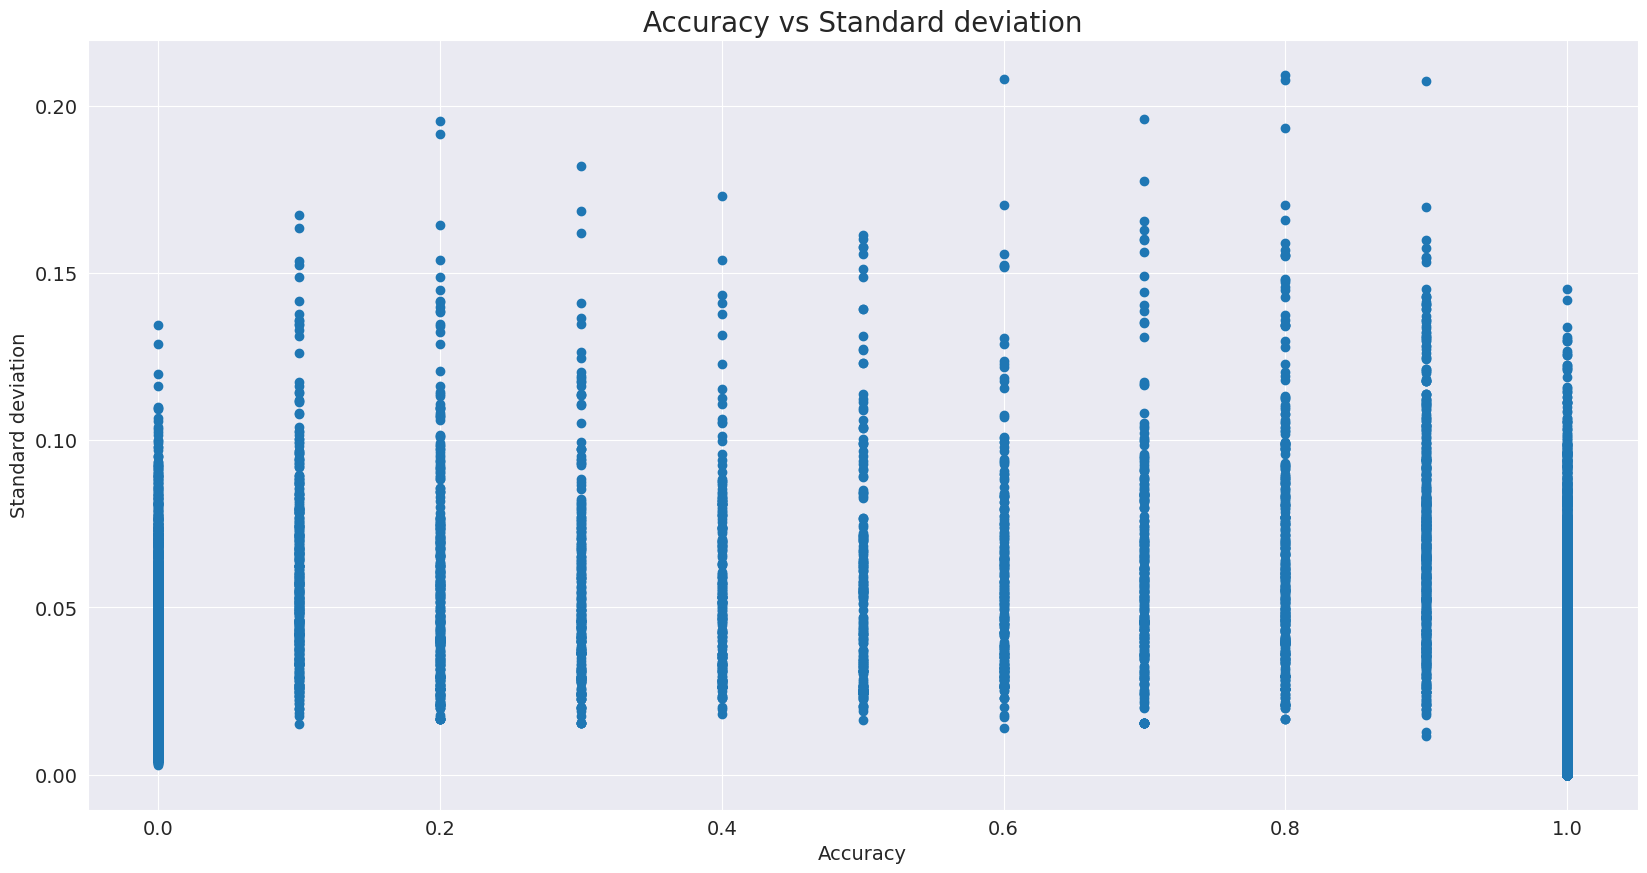

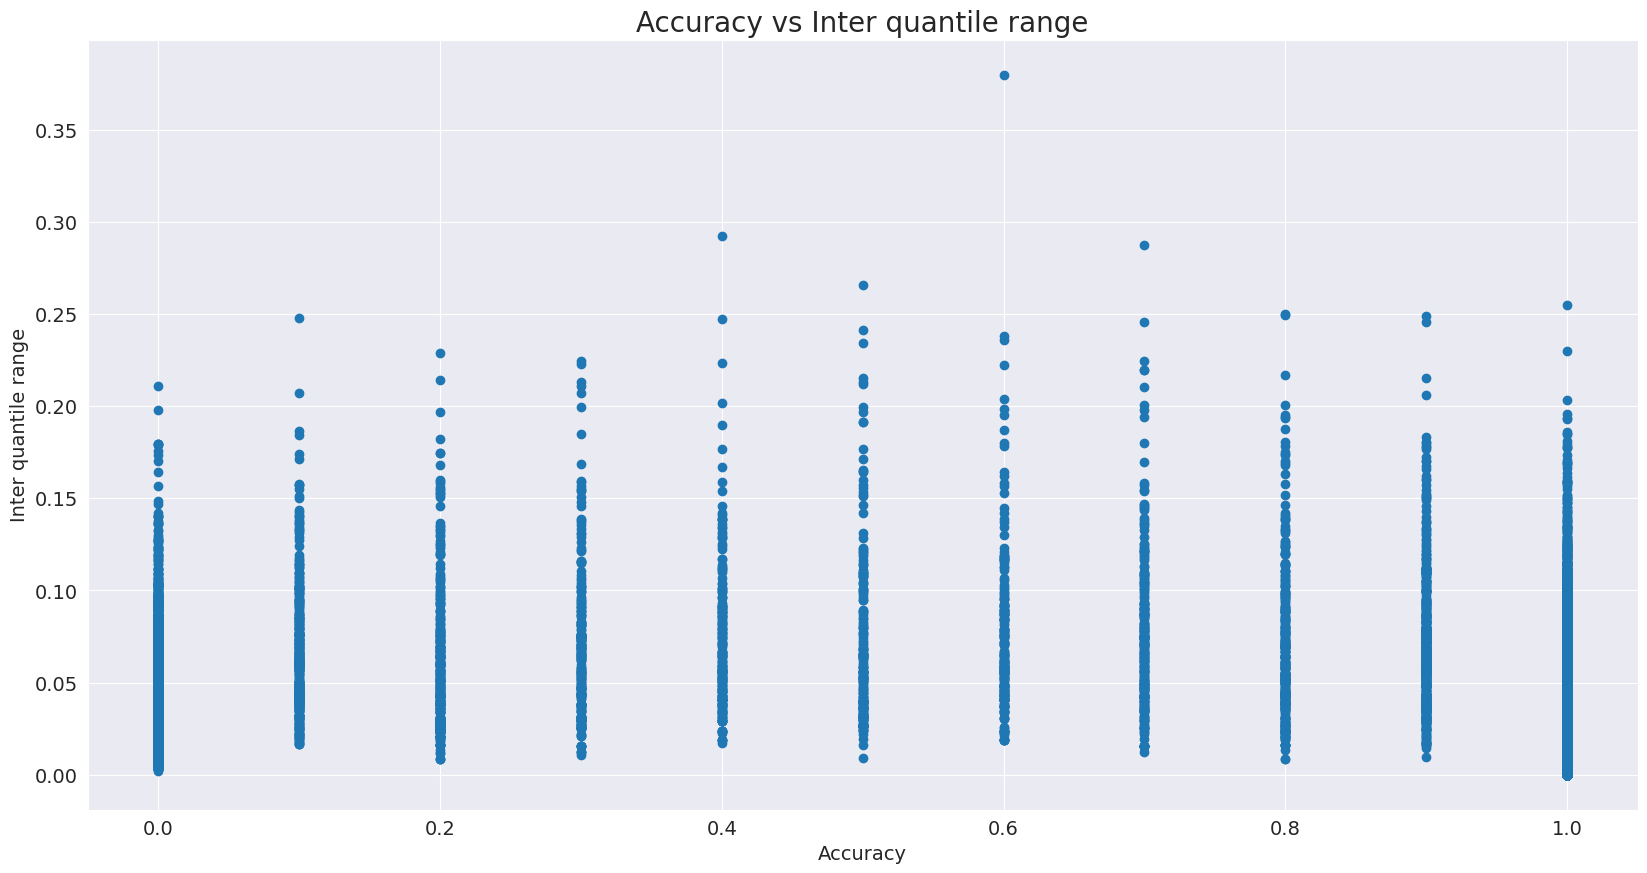

############################## Fairness metrics ##############################

#################### Accuracy ####################
              Race       Sex  Race_Sex
adv       0.828220  0.850179  0.851559
disadv    0.821561  0.807152  0.823190
Accuracy  0.006659  0.043027  0.028370

#################### Disparate_Impact ####################
                      Race       Sex  Race_Sex
adv               0.514653  0.520120  0.532511
disadv            0.455597  0.495530  0.469183
Disparate_Impact  0.885251  0.952723  0.881078

#################### Equal_Opportunity ####################
                       Race       Sex  Race_Sex
adv                0.863466  0.879591  0.881869
disadv             0.833831  0.844400  0.834951
Equal_Opportunity  0.029635  0.035191  0.046917

#################### Statistical_Parity_Difference ####################
                                   Race       Sex  Race_Sex
adv                            1.091125  1.066344  1.058919
disadv             

In [25]:
quantify_uncertainty(TARGET_COLUMN, y_data, imputed_data_dict, imputation_technique='impute-by-mean-conditional_RAC1P')

### Impute-by-median technique

X_train_imputed.shape:  (118179, 74)
X_val_imputed.shape:  (39394, 74)
X_test_imputed.shape:  (39394, 74)


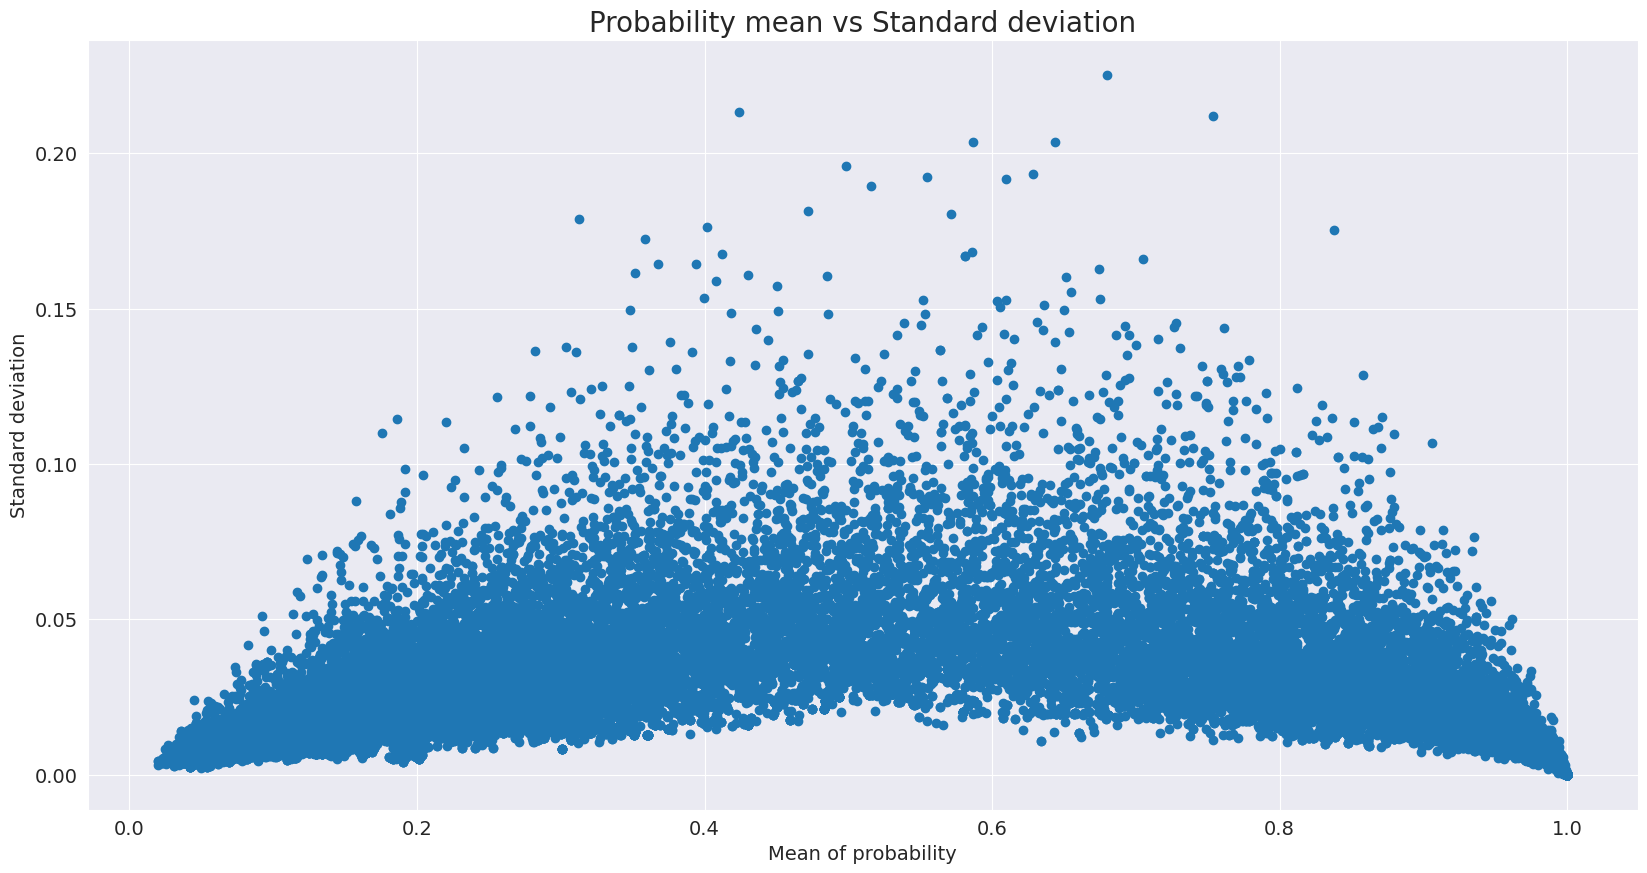

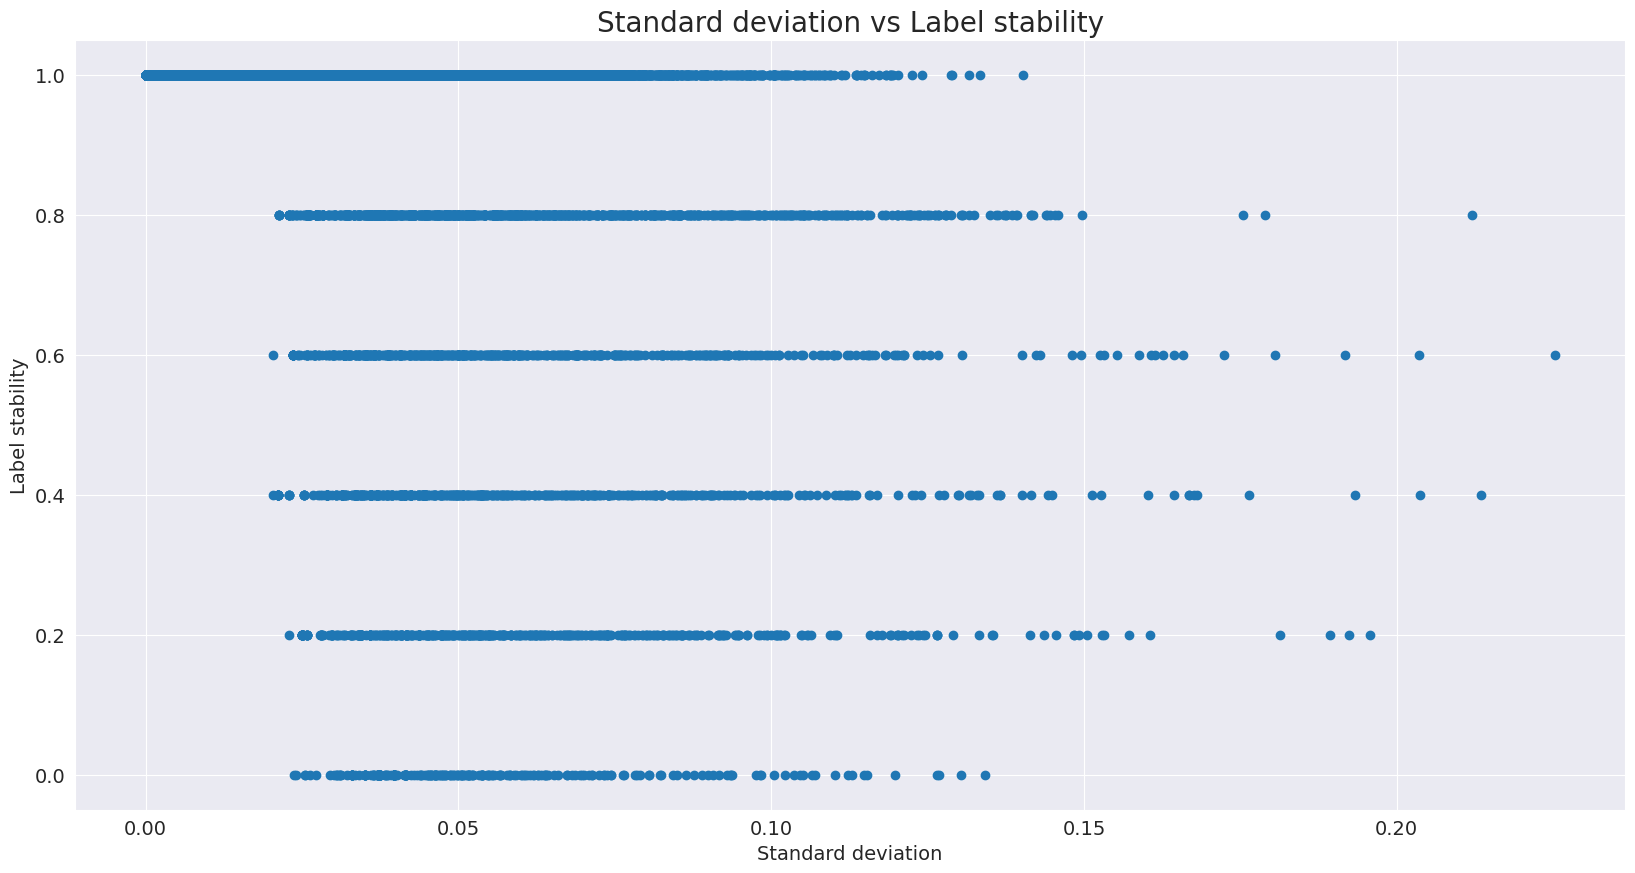

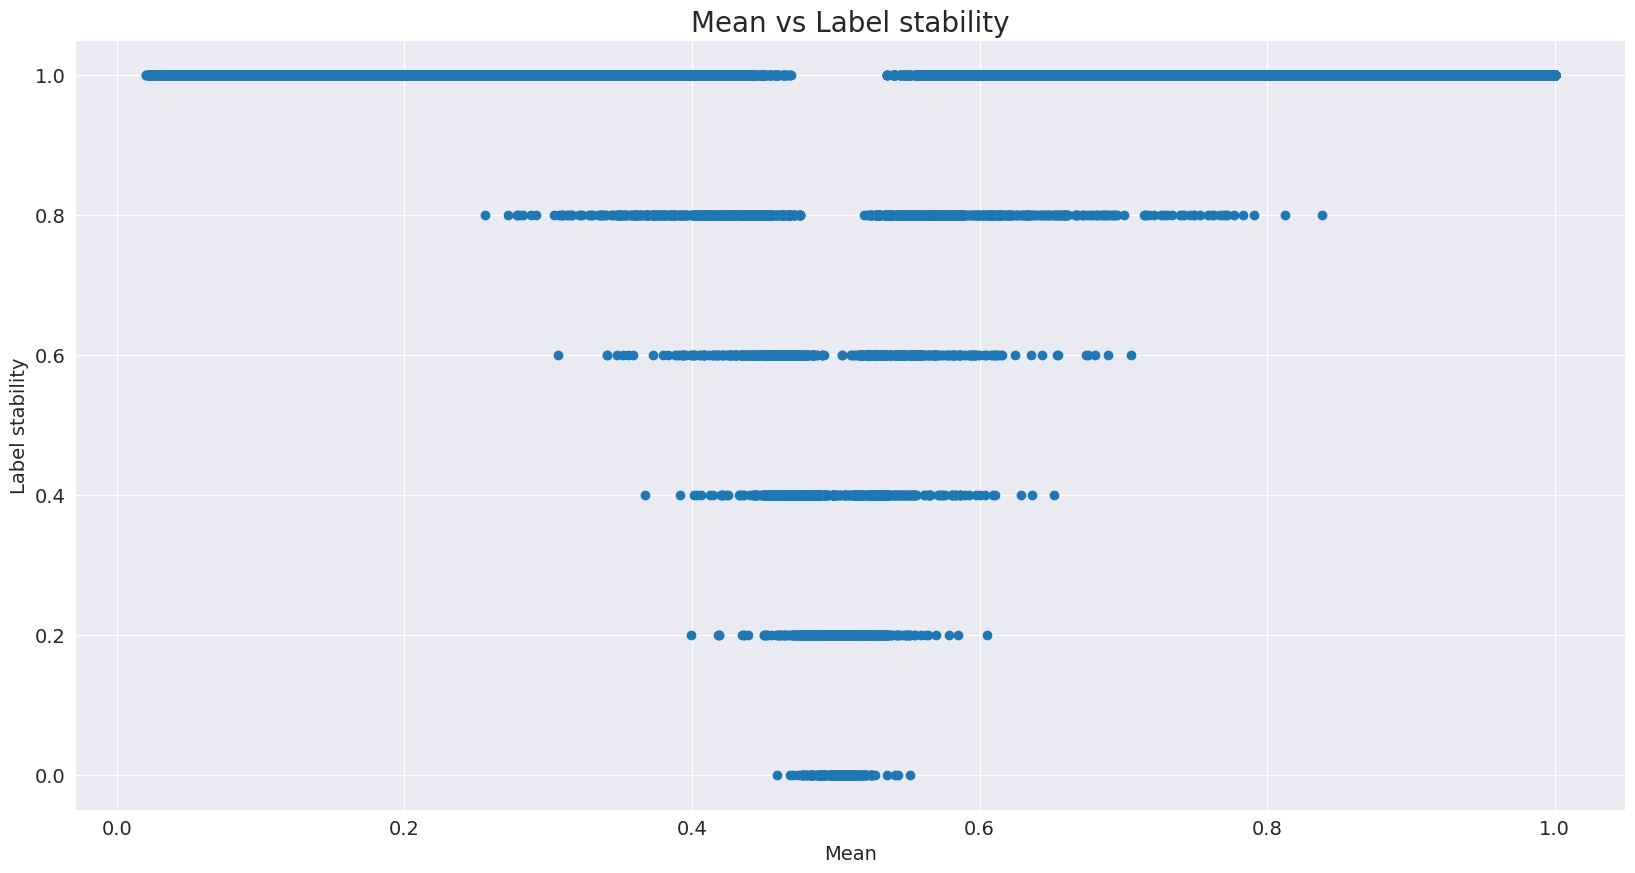

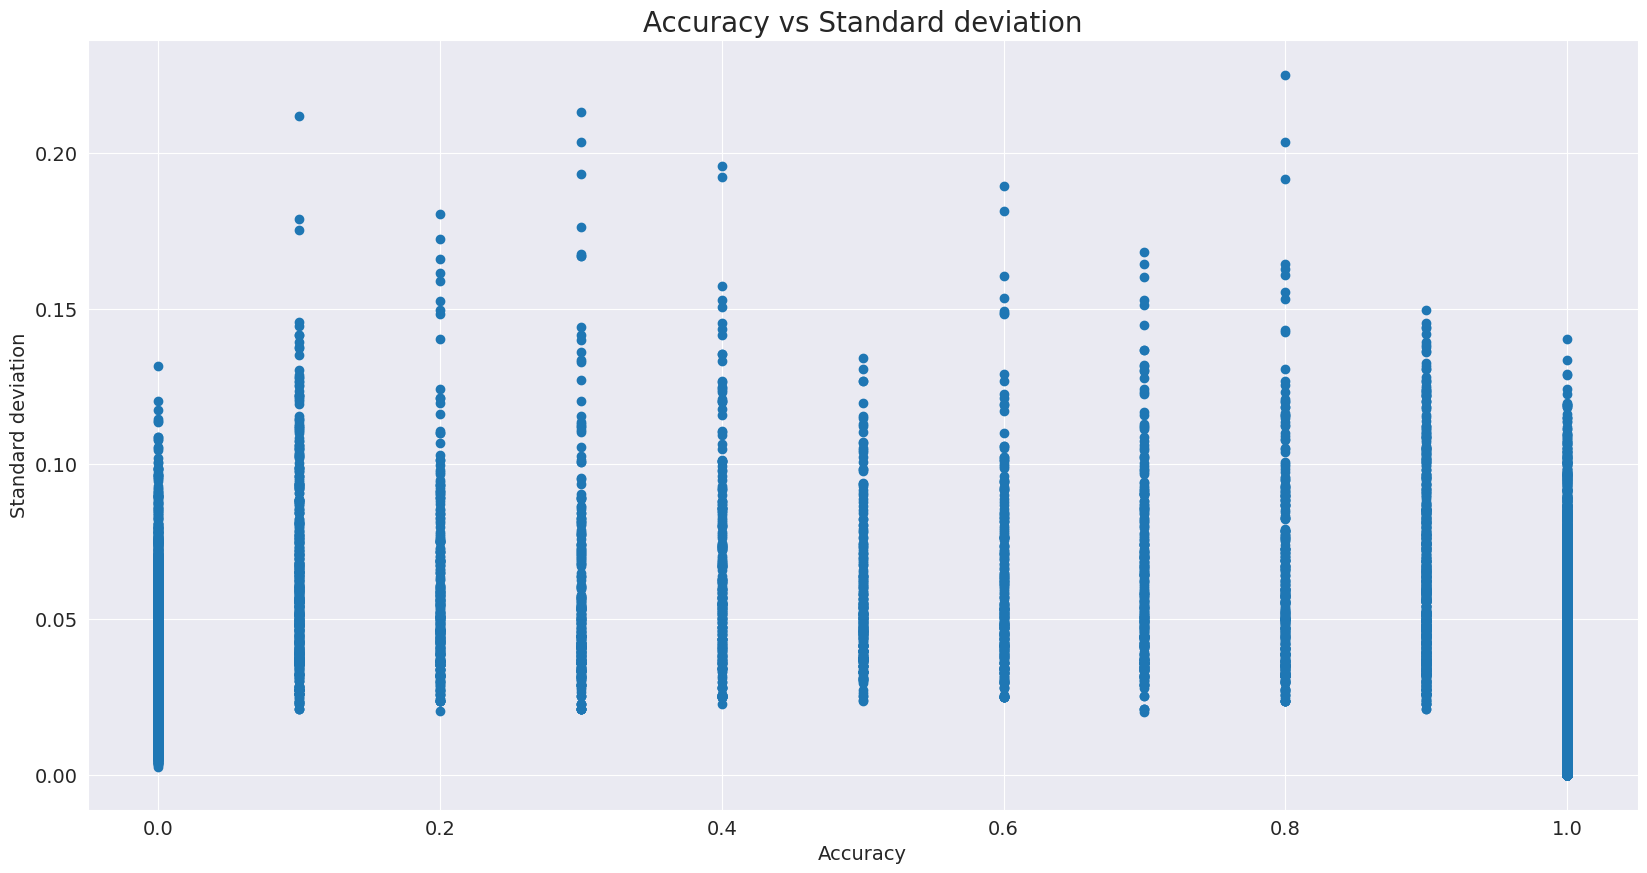

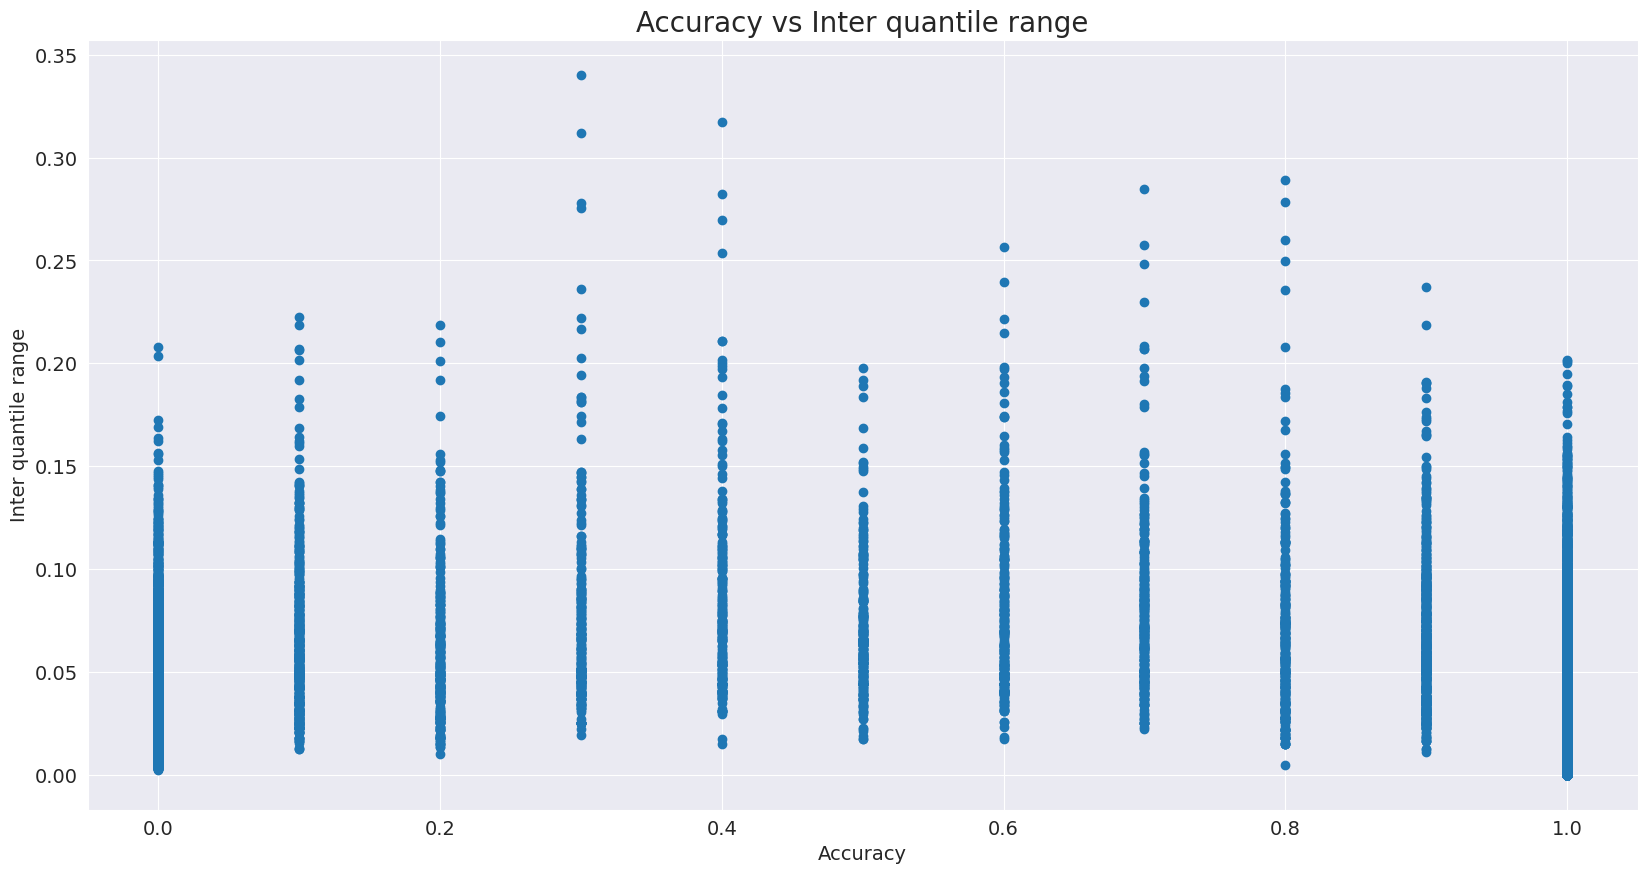

############################## Fairness metrics ##############################

#################### Accuracy ####################
              Race       Sex  Race_Sex
adv       0.828980  0.849916  0.851263
disadv    0.825279  0.808871  0.826271
Accuracy  0.003701  0.041045  0.024992

#################### Disparate_Impact ####################
                      Race       Sex  Race_Sex
adv               0.512952  0.518386  0.529555
disadv            0.454358  0.493614  0.468413
Disparate_Impact  0.885770  0.952213  0.884540

#################### Equal_Opportunity ####################
                       Race       Sex  Race_Sex
adv                0.862468  0.877544  0.878636
disadv             0.836816  0.844176  0.837599
Equal_Opportunity  0.025652  0.033368  0.041037

#################### Statistical_Parity_Difference ####################
                                   Race       Sex  Race_Sex
adv                            1.087520  1.062789  1.053041
disadv             

In [26]:
quantify_uncertainty(TARGET_COLUMN, y_data, imputed_data_dict, imputation_technique='impute-by-median')

### Impute-by-median-trimmed technique

X_train_imputed.shape:  (118179, 74)
X_val_imputed.shape:  (39394, 74)
X_test_imputed.shape:  (39394, 74)


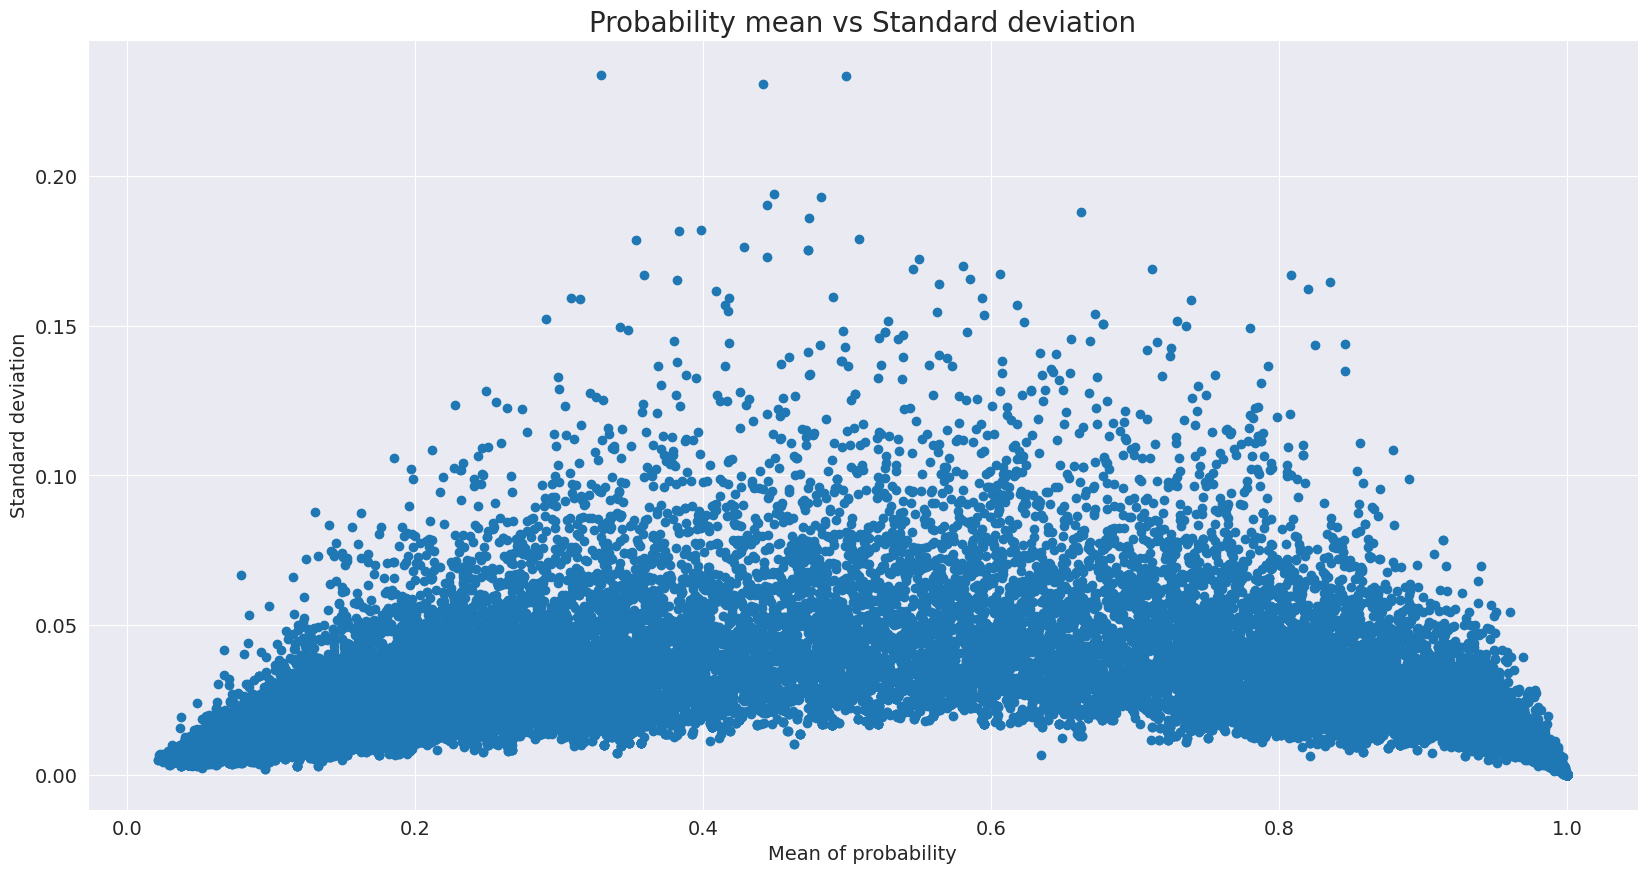

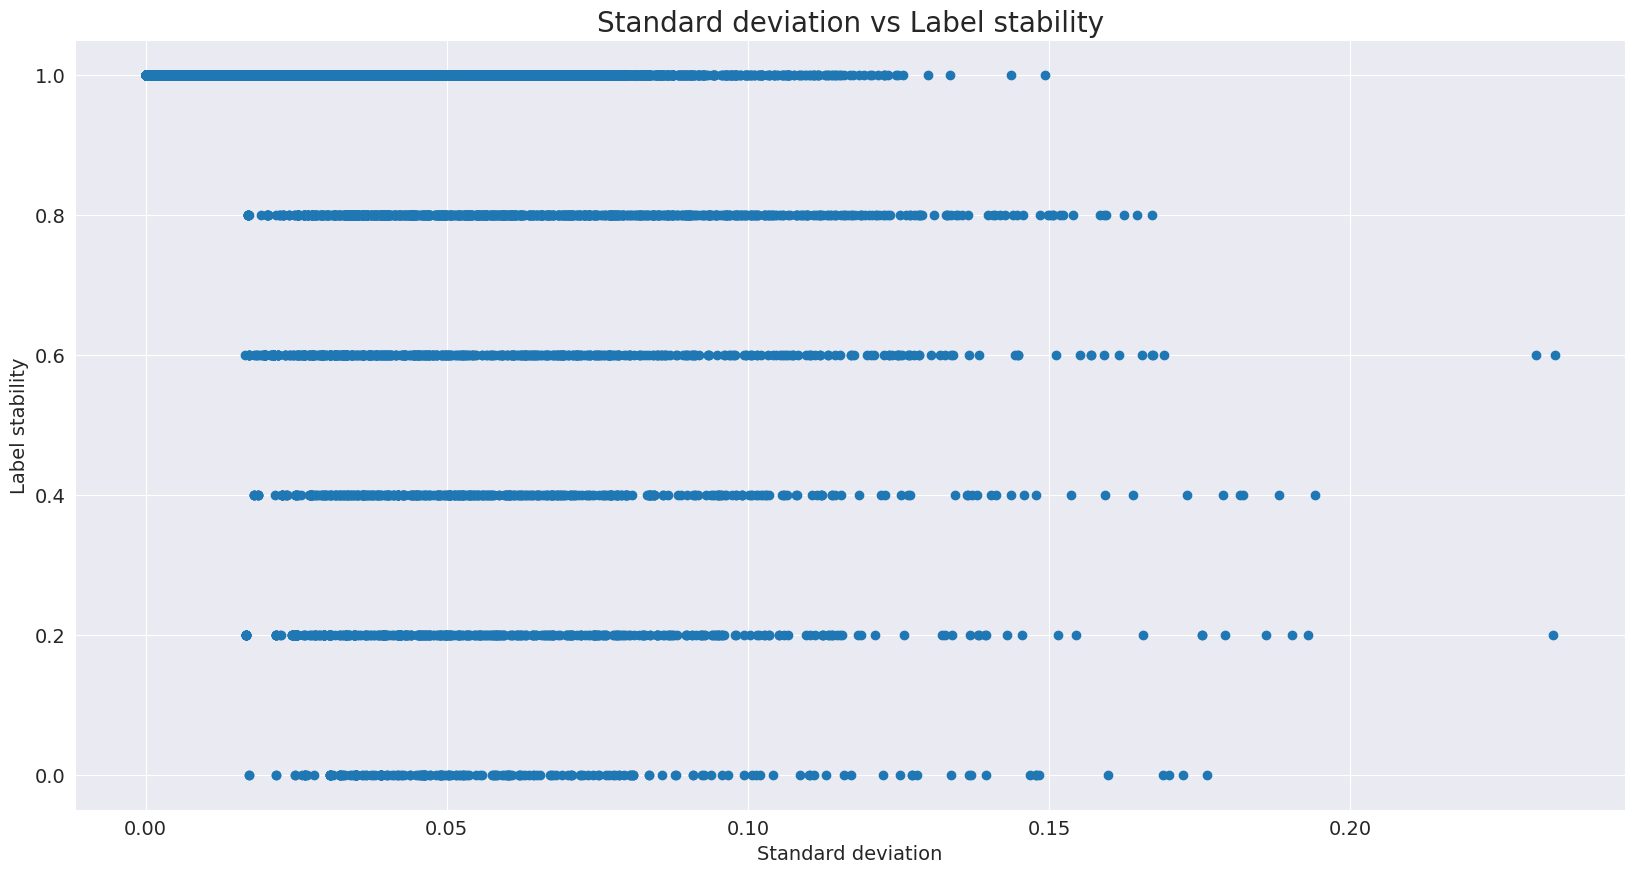

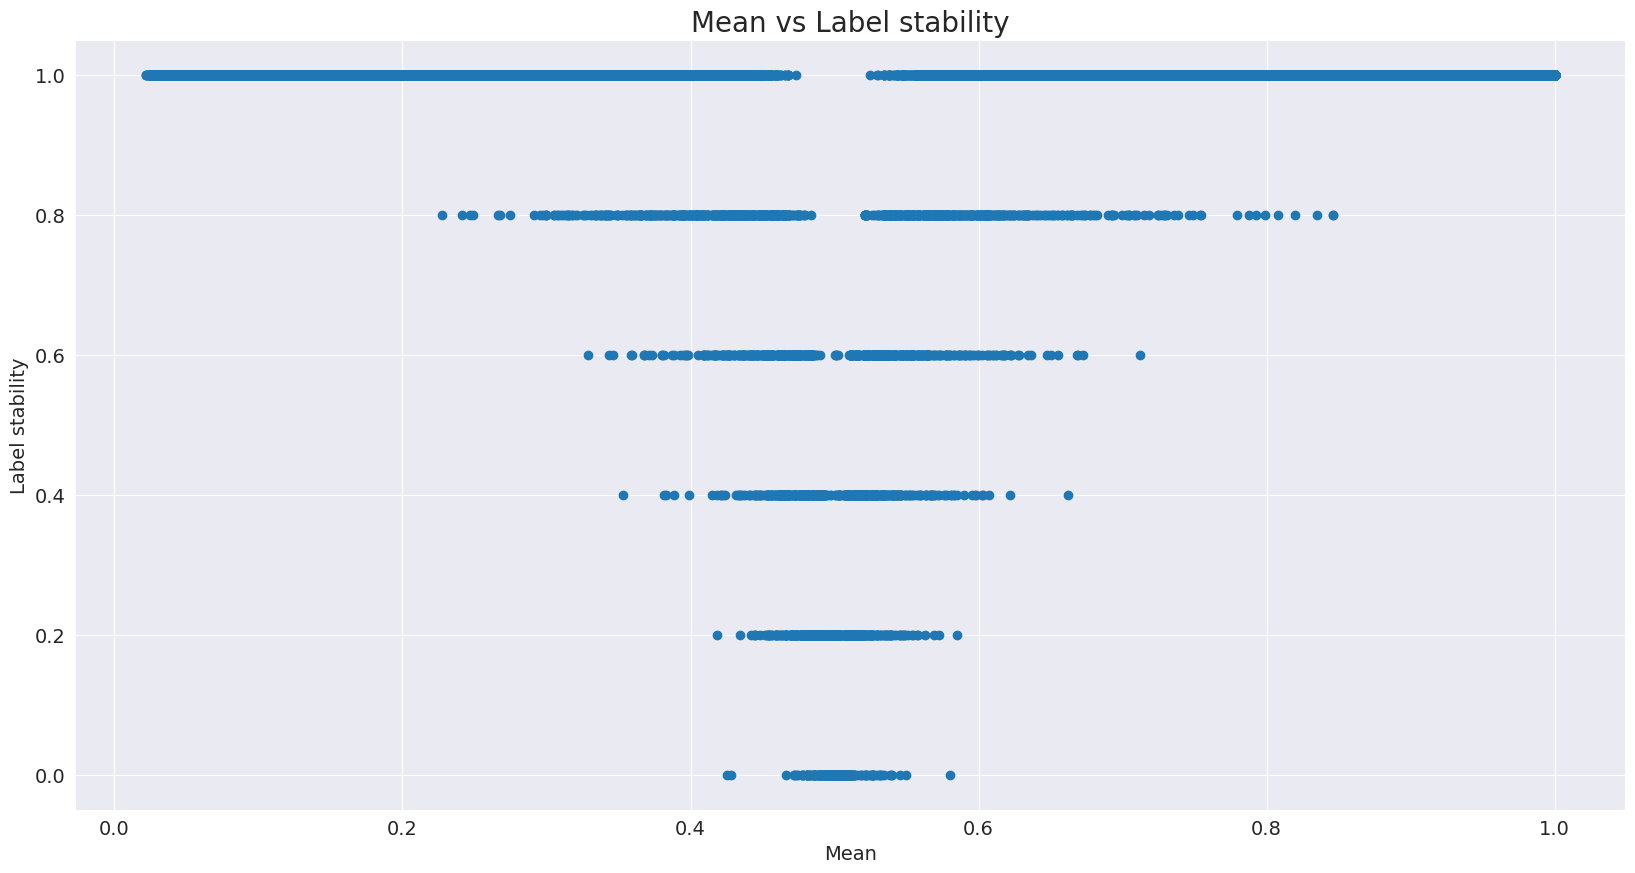

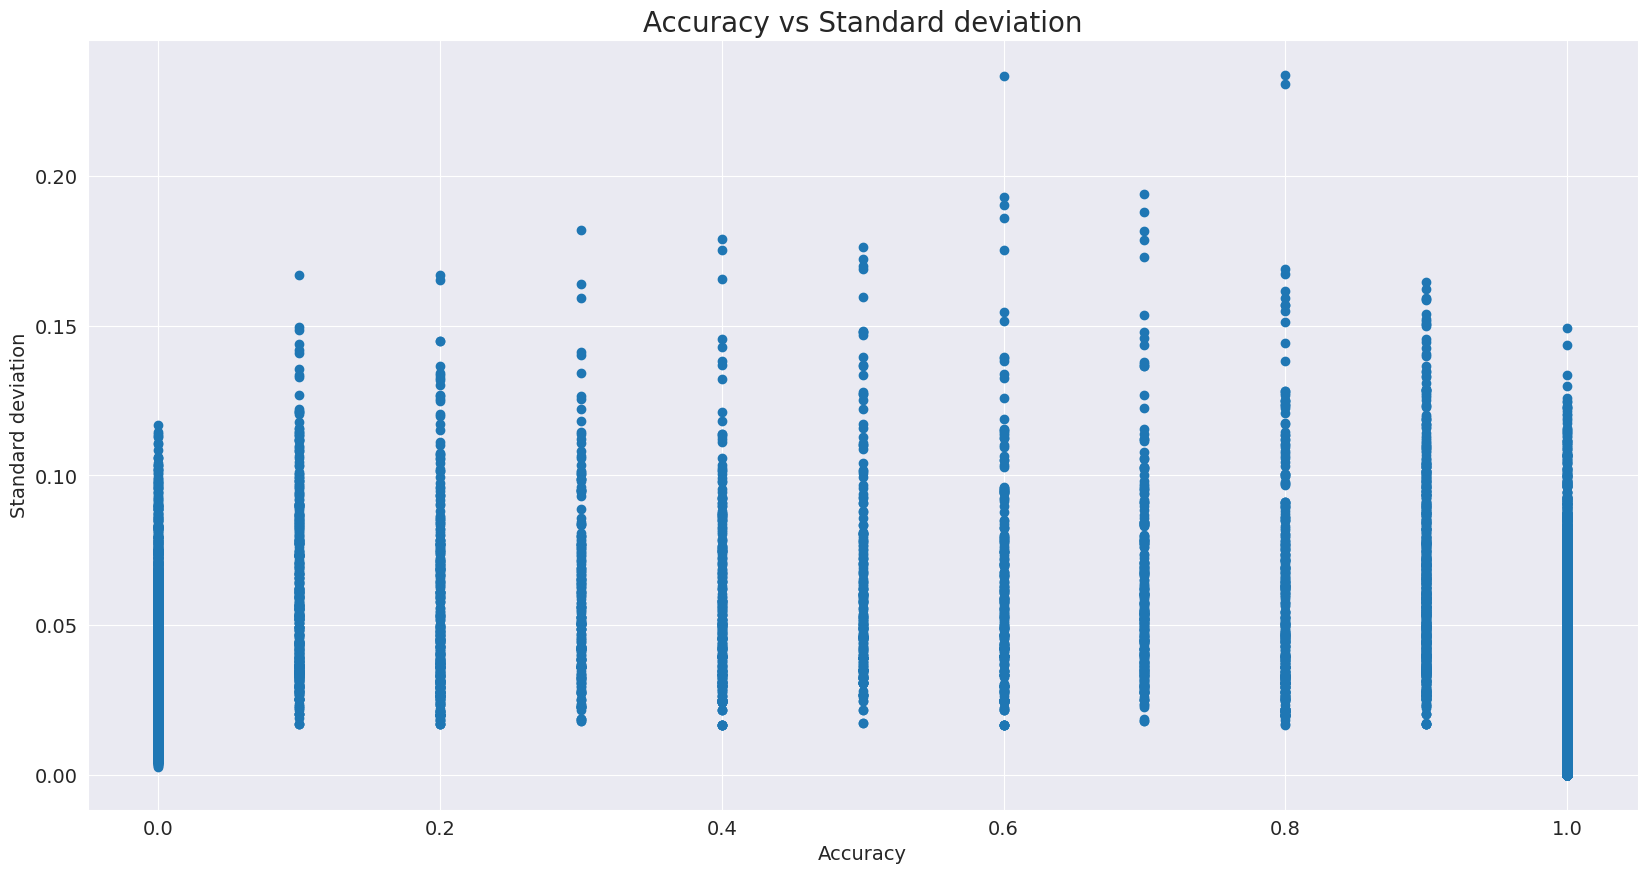

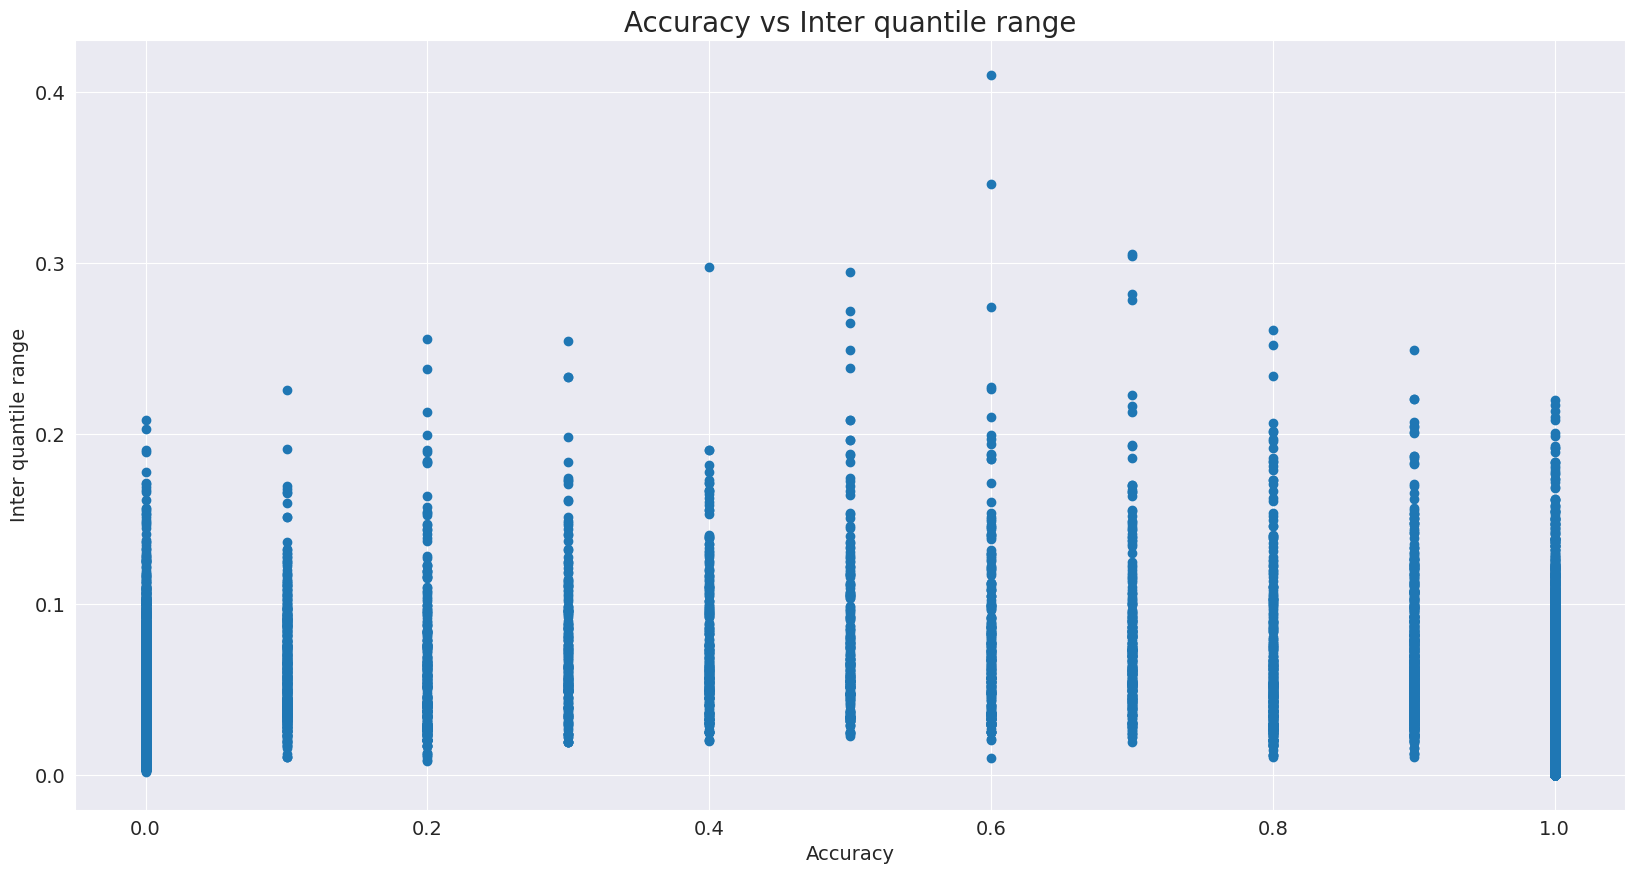

############################## Fairness metrics ##############################

#################### Accuracy ####################
              Race       Sex  Race_Sex
adv       0.829559  0.849968  0.852150
disadv    0.825279  0.809215  0.828197
Accuracy  0.004280  0.040753  0.023953

#################### Disparate_Impact ####################
                      Race       Sex  Race_Sex
adv               0.511577  0.517073  0.529703
disadv            0.454358  0.493172  0.471880
Disparate_Impact  0.888150  0.953777  0.890839

#################### Equal_Opportunity ####################
                       Race       Sex  Race_Sex
adv                0.861625  0.876252  0.879665
disadv             0.836816  0.844064  0.843778
Equal_Opportunity  0.024809  0.032188  0.035887

#################### Statistical_Parity_Difference ####################
                                   Race       Sex  Race_Sex
adv                            1.084605  1.060097  1.053335
disadv             

In [27]:
quantify_uncertainty(TARGET_COLUMN, y_data, imputed_data_dict, imputation_technique='impute-by-median-trimmed')

### Impute-by-median-conditional_SEX technique

X_train_imputed.shape:  (118179, 74)
X_val_imputed.shape:  (39394, 74)
X_test_imputed.shape:  (39394, 74)


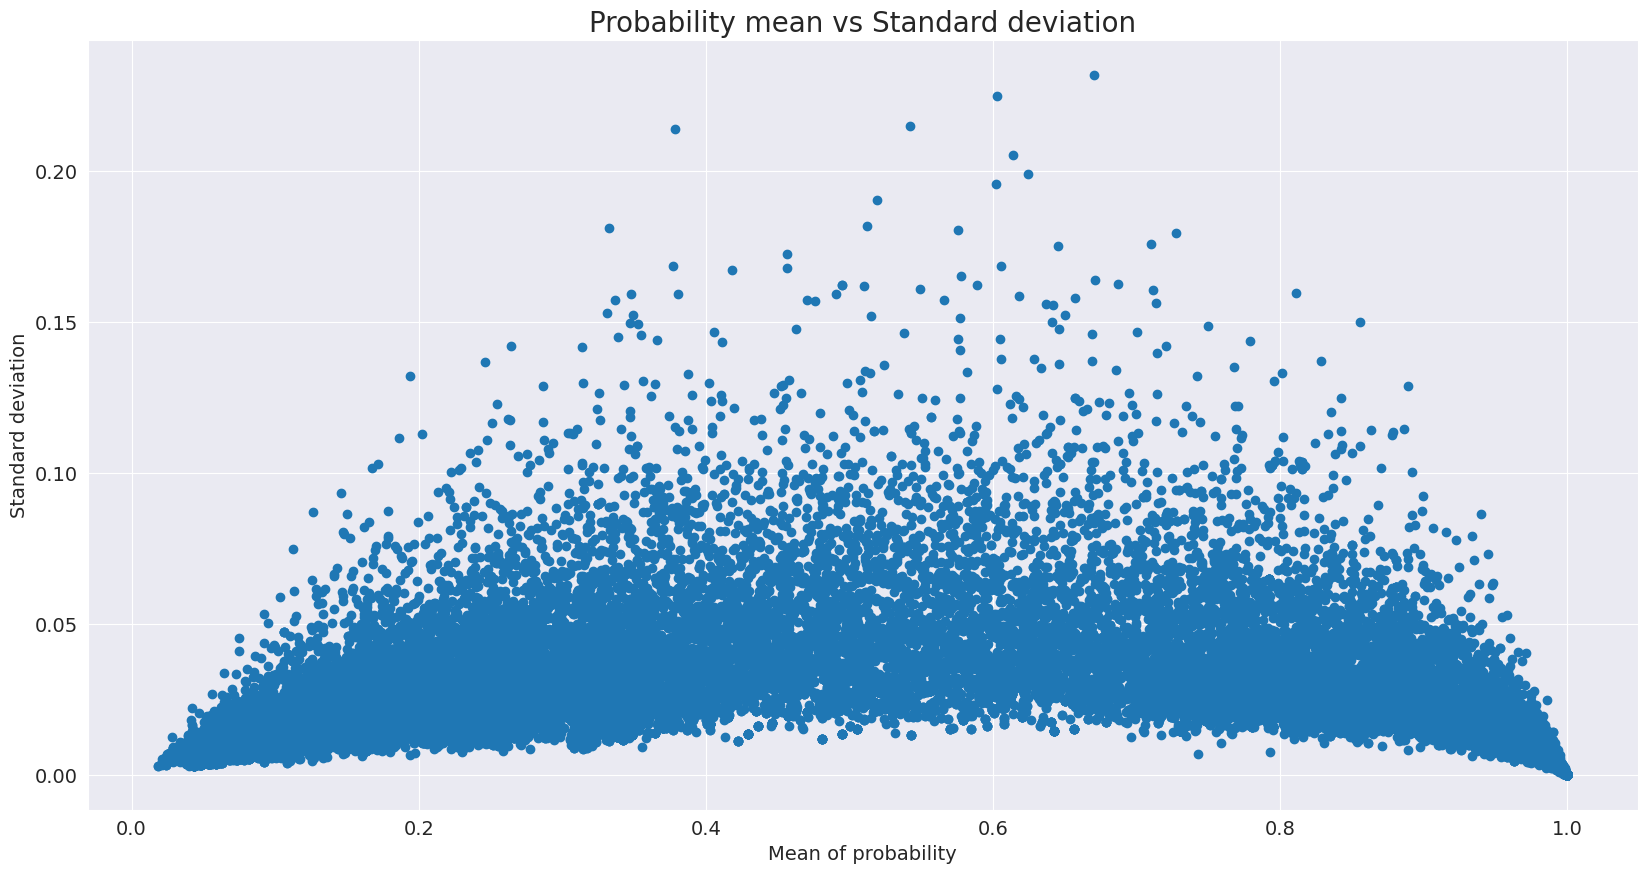

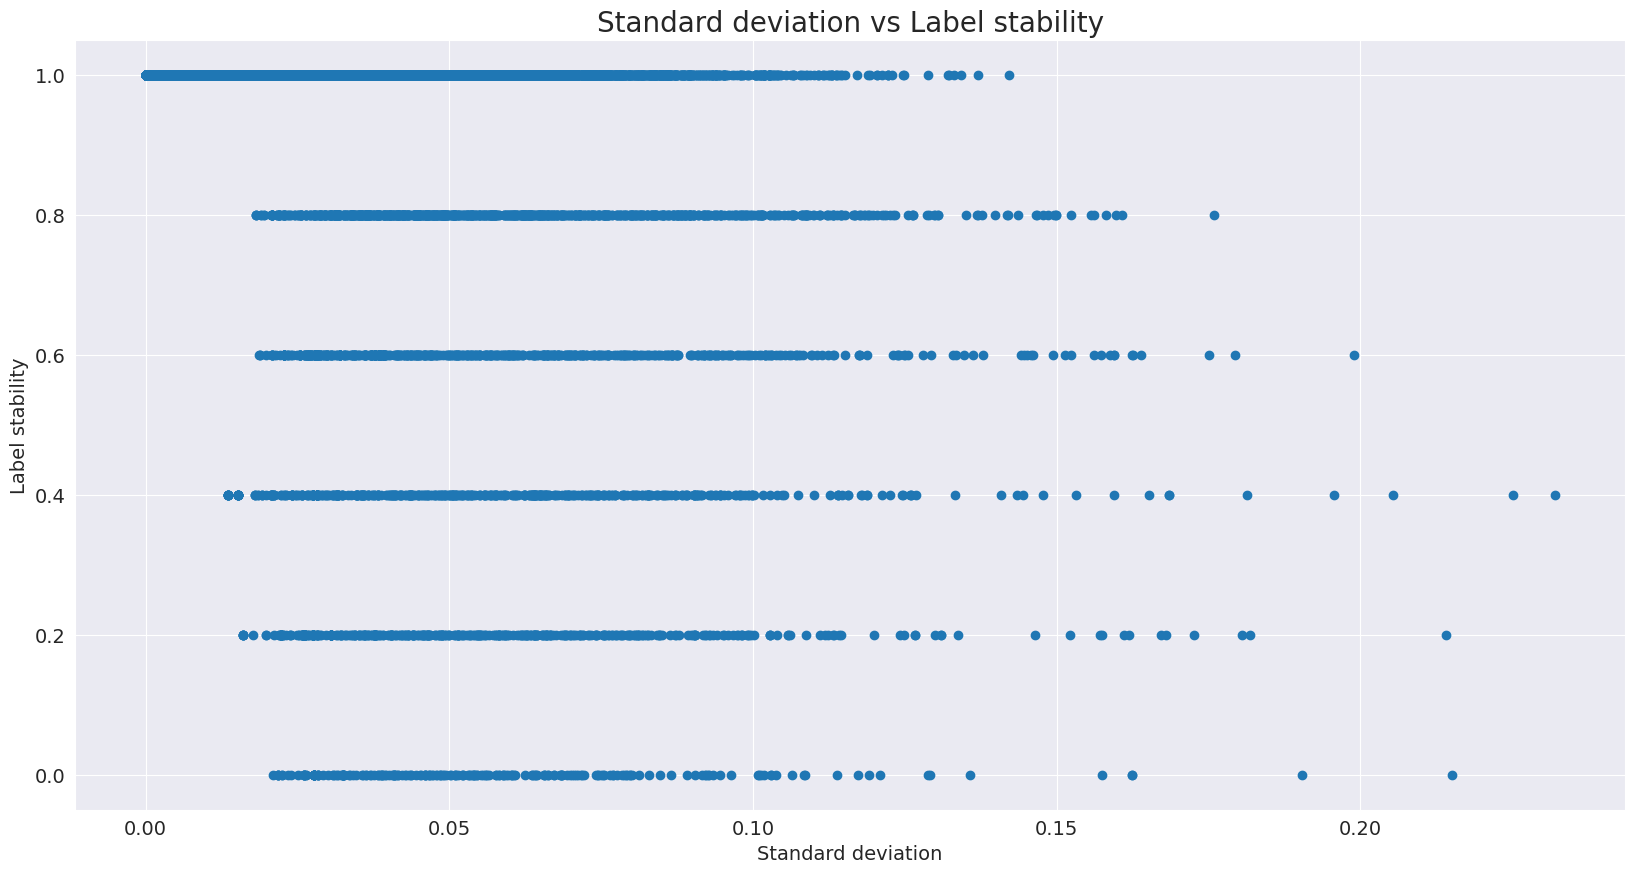

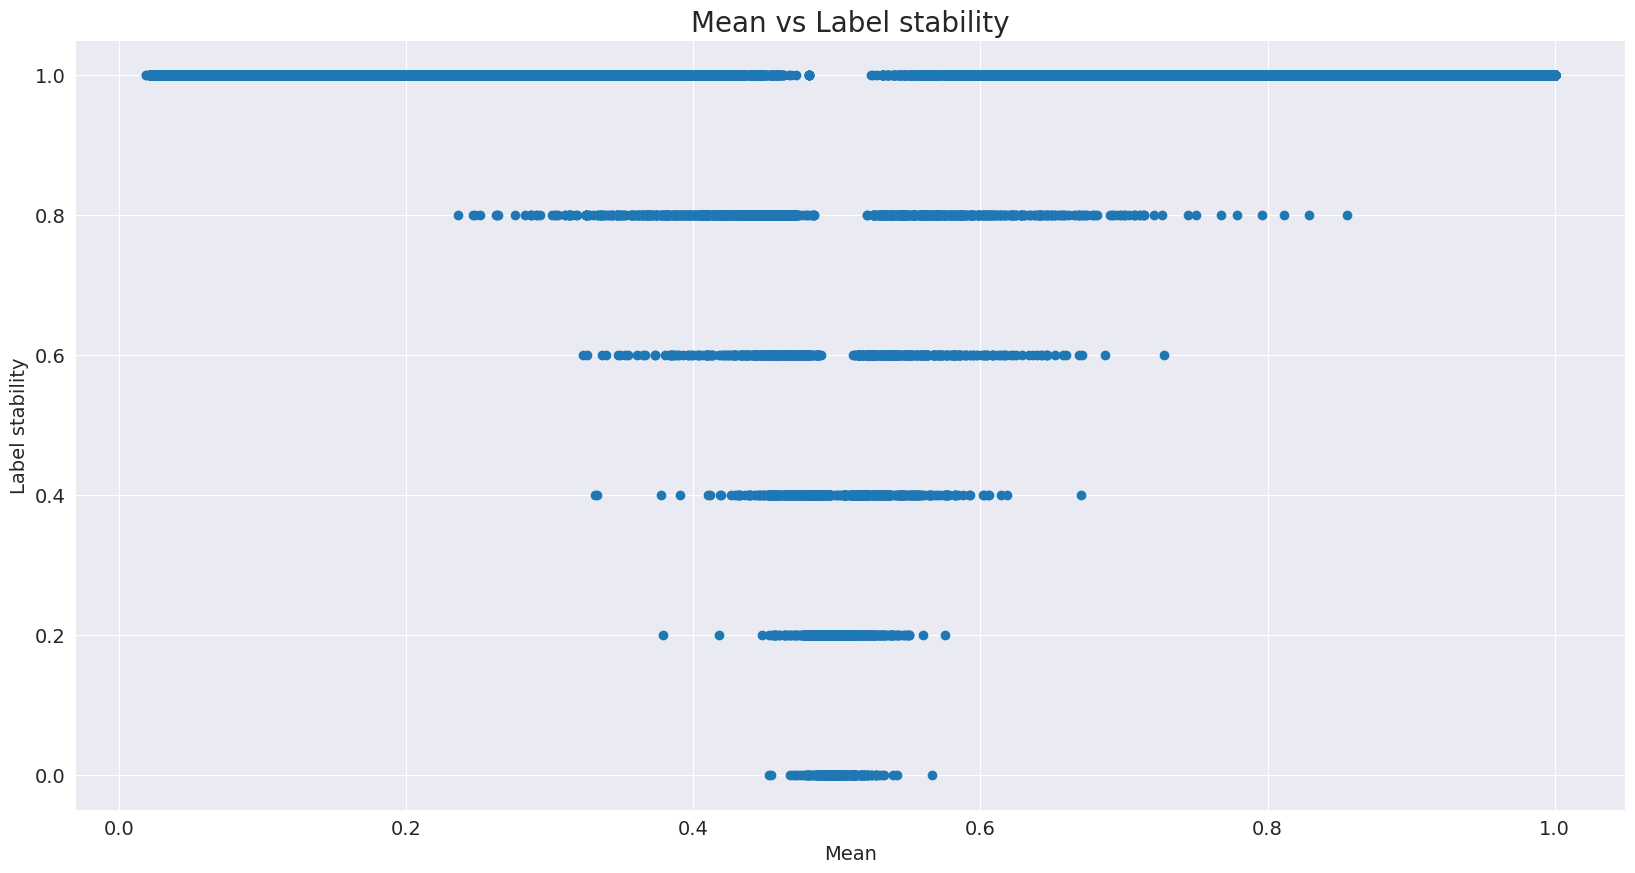

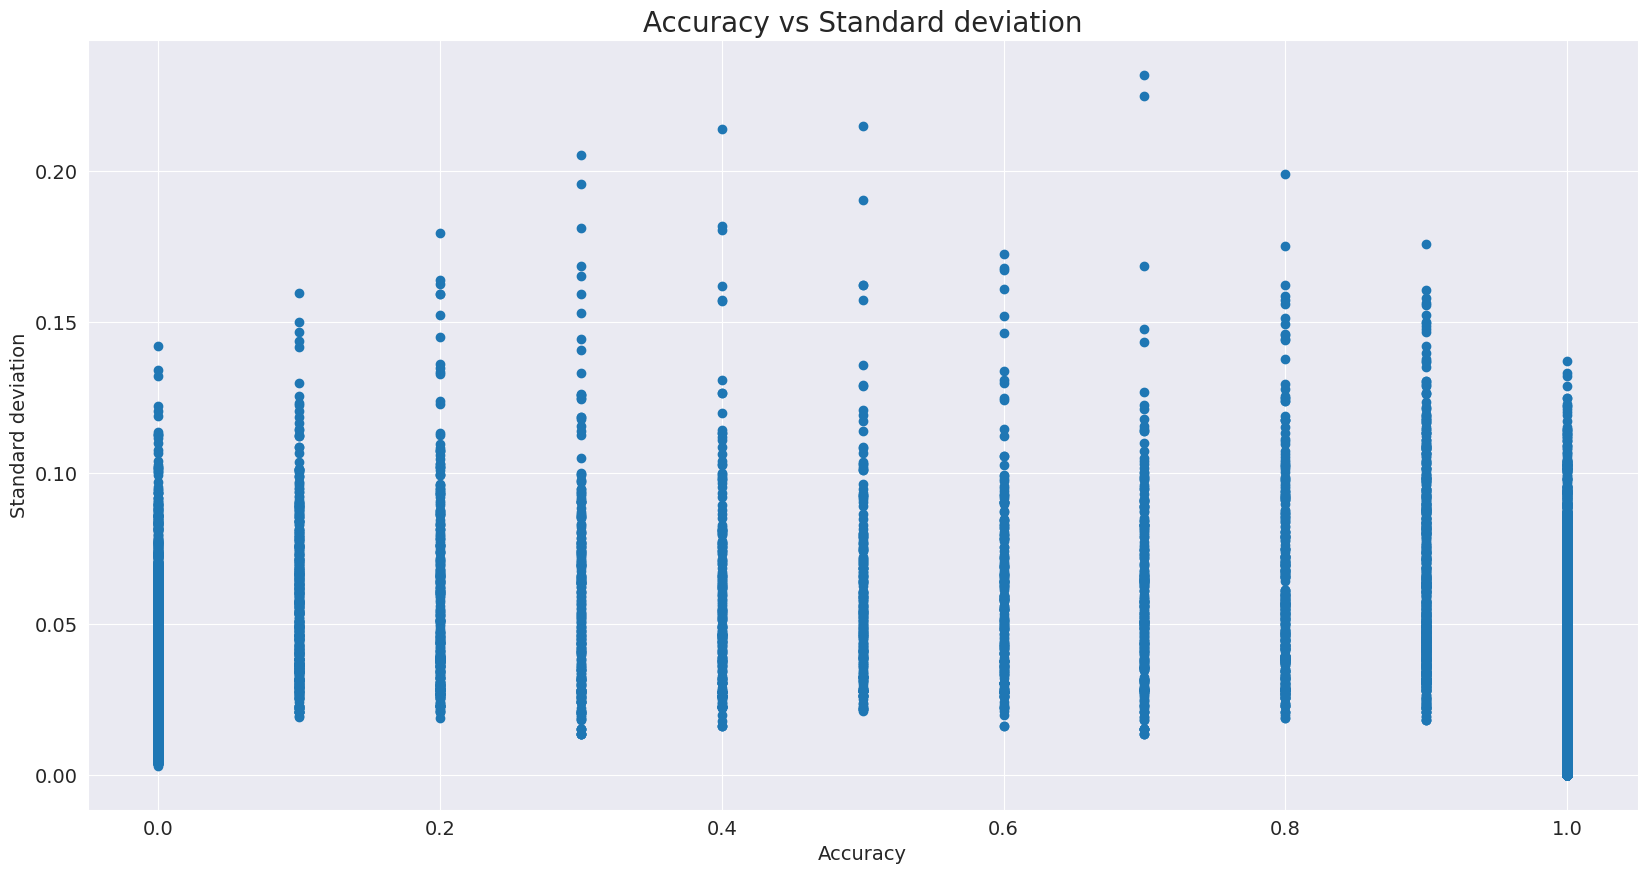

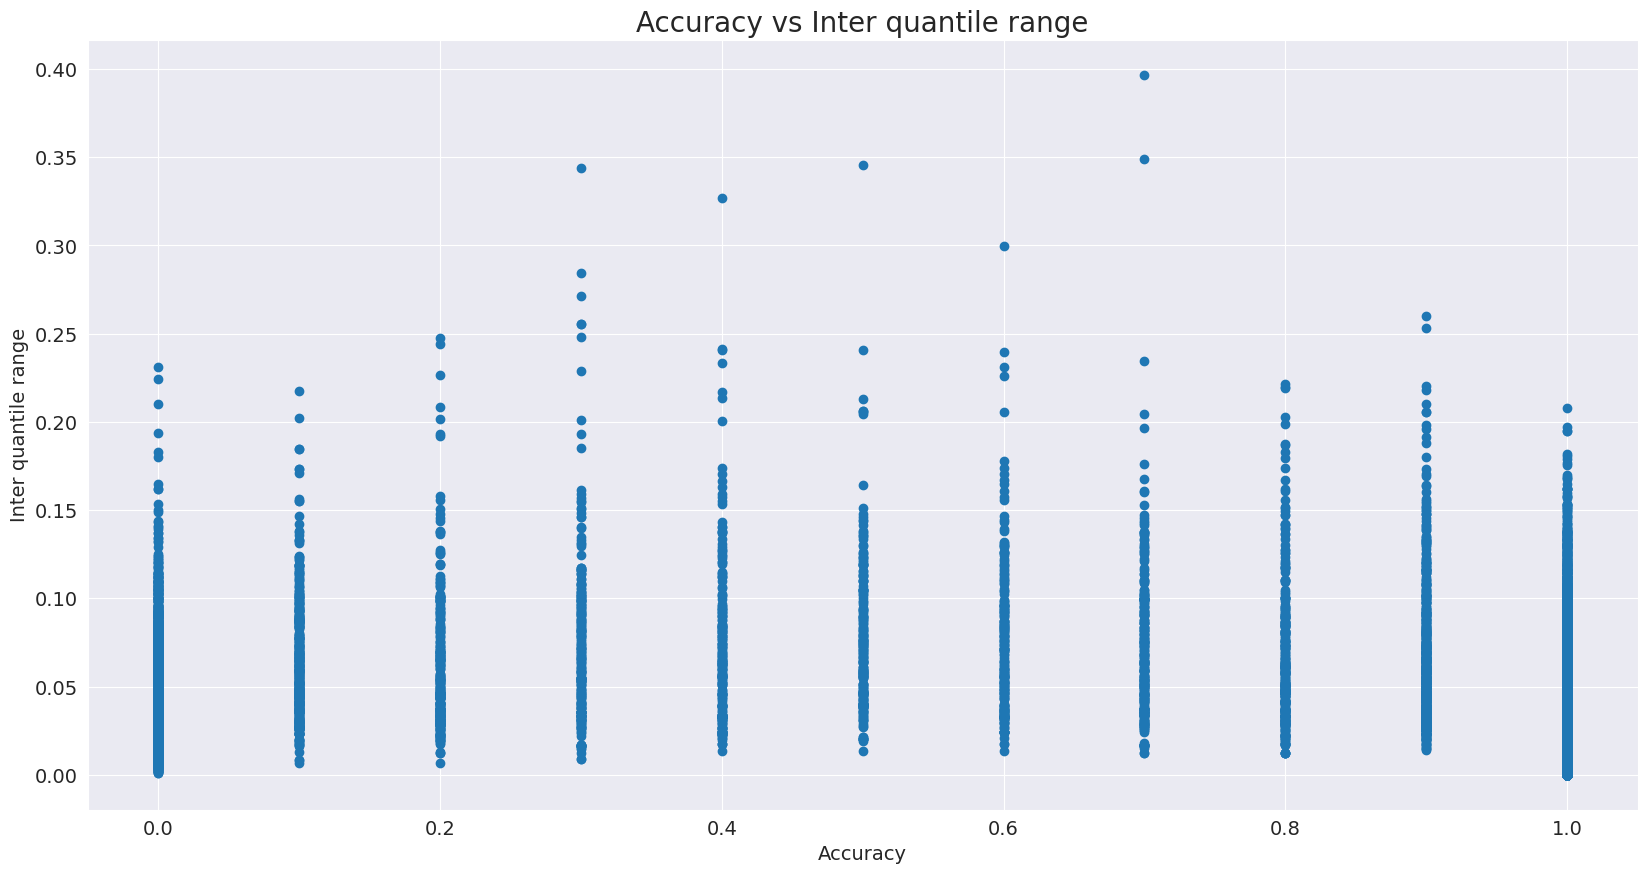

############################## Fairness metrics ##############################

#################### Accuracy ####################
              Race       Sex  Race_Sex
adv       0.829197  0.850074  0.852002
disadv    0.824040  0.808724  0.826271
Accuracy  0.005157  0.041350  0.025731

#################### Disparate_Impact ####################
                      Race       Sex  Race_Sex
adv               0.514182  0.518334  0.529999
disadv            0.454358  0.497397  0.470724
Disparate_Impact  0.883651  0.959607  0.888161

#################### Equal_Opportunity ####################
                       Race       Sex  Race_Sex
adv                0.864002  0.877652  0.879812
disadv             0.835323  0.848312  0.840247
Equal_Opportunity  0.028679  0.029340  0.039565

#################### Statistical_Parity_Difference ####################
                                   Race       Sex  Race_Sex
adv                            1.090128  1.062682  1.053923
disadv             

In [28]:
quantify_uncertainty(TARGET_COLUMN, y_data, imputed_data_dict, imputation_technique='impute-by-median-conditional_SEX')

### Impute-by-median-conditional_RAC1P technique

X_train_imputed.shape:  (118179, 74)
X_val_imputed.shape:  (39394, 74)
X_test_imputed.shape:  (39394, 74)


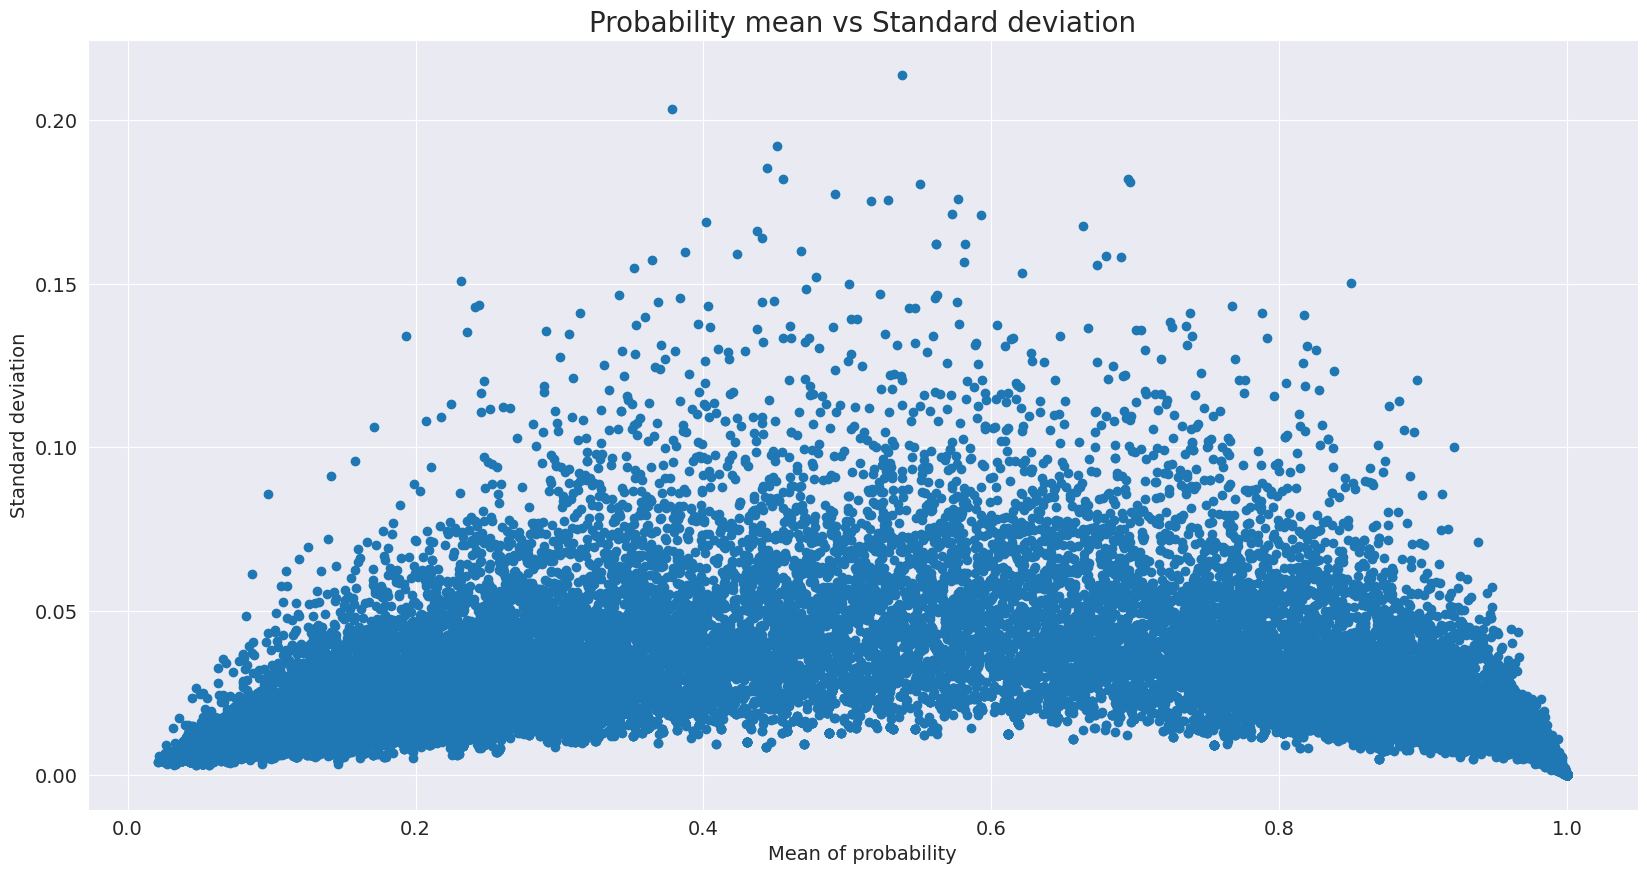

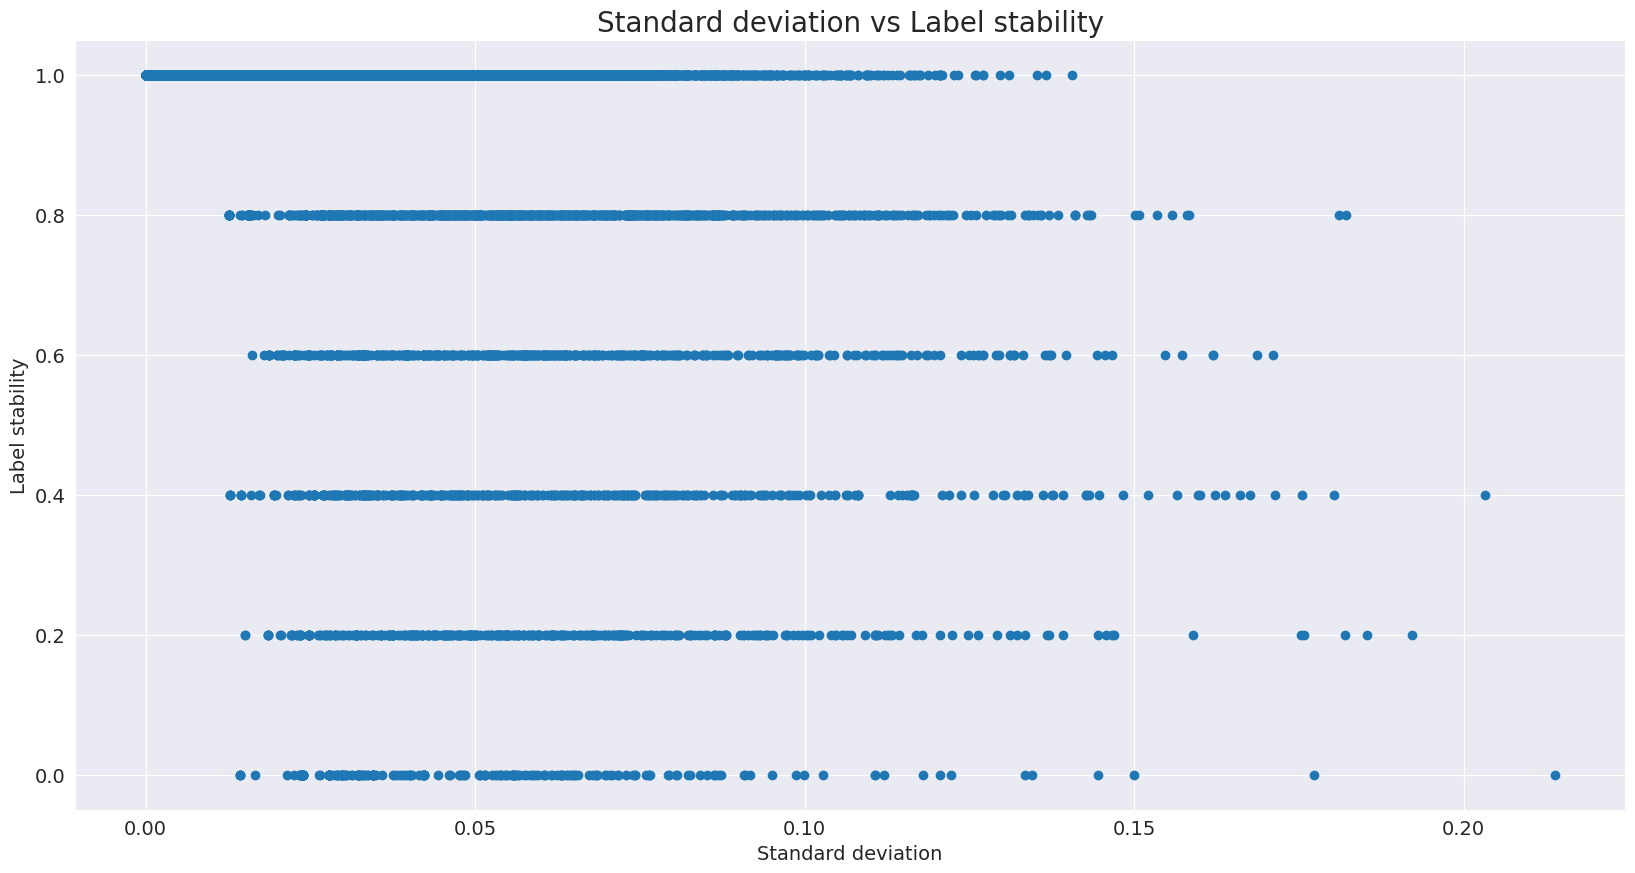

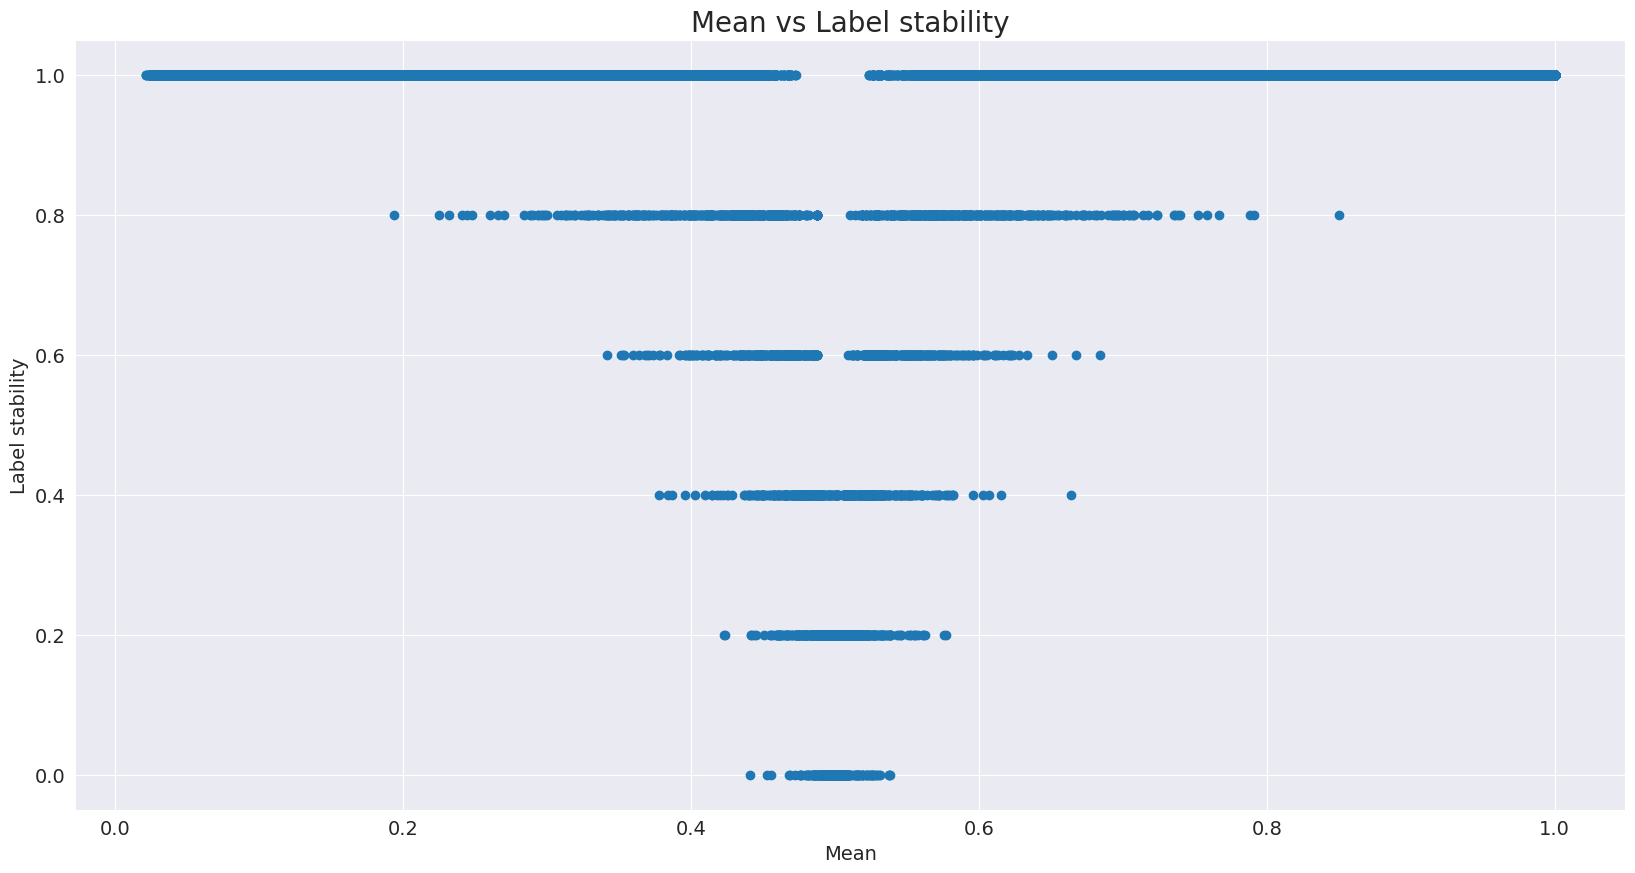

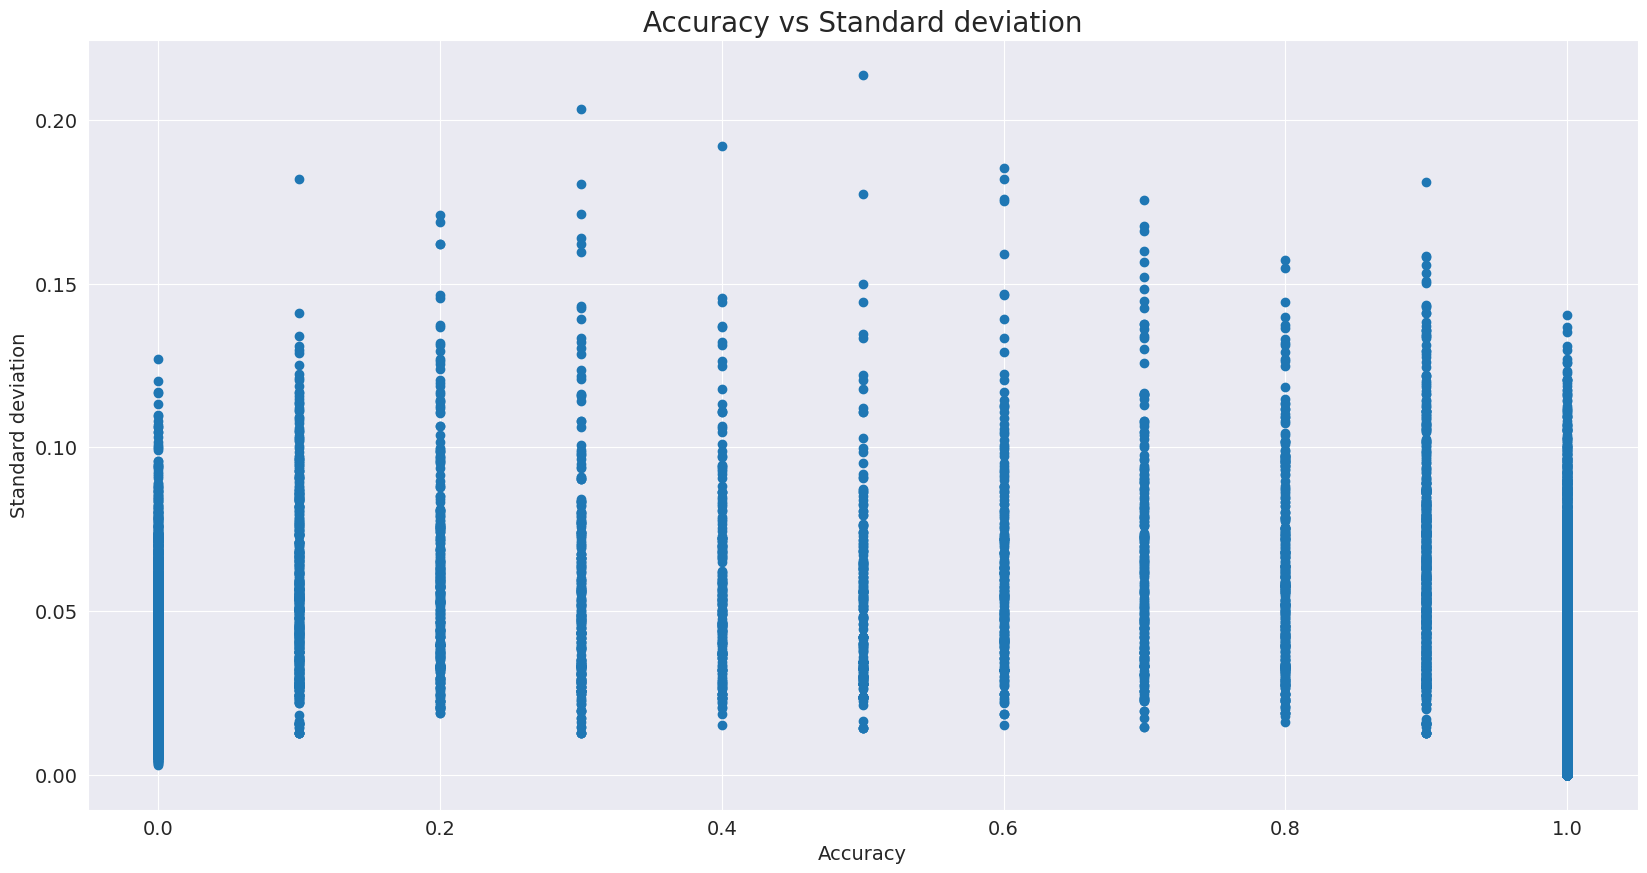

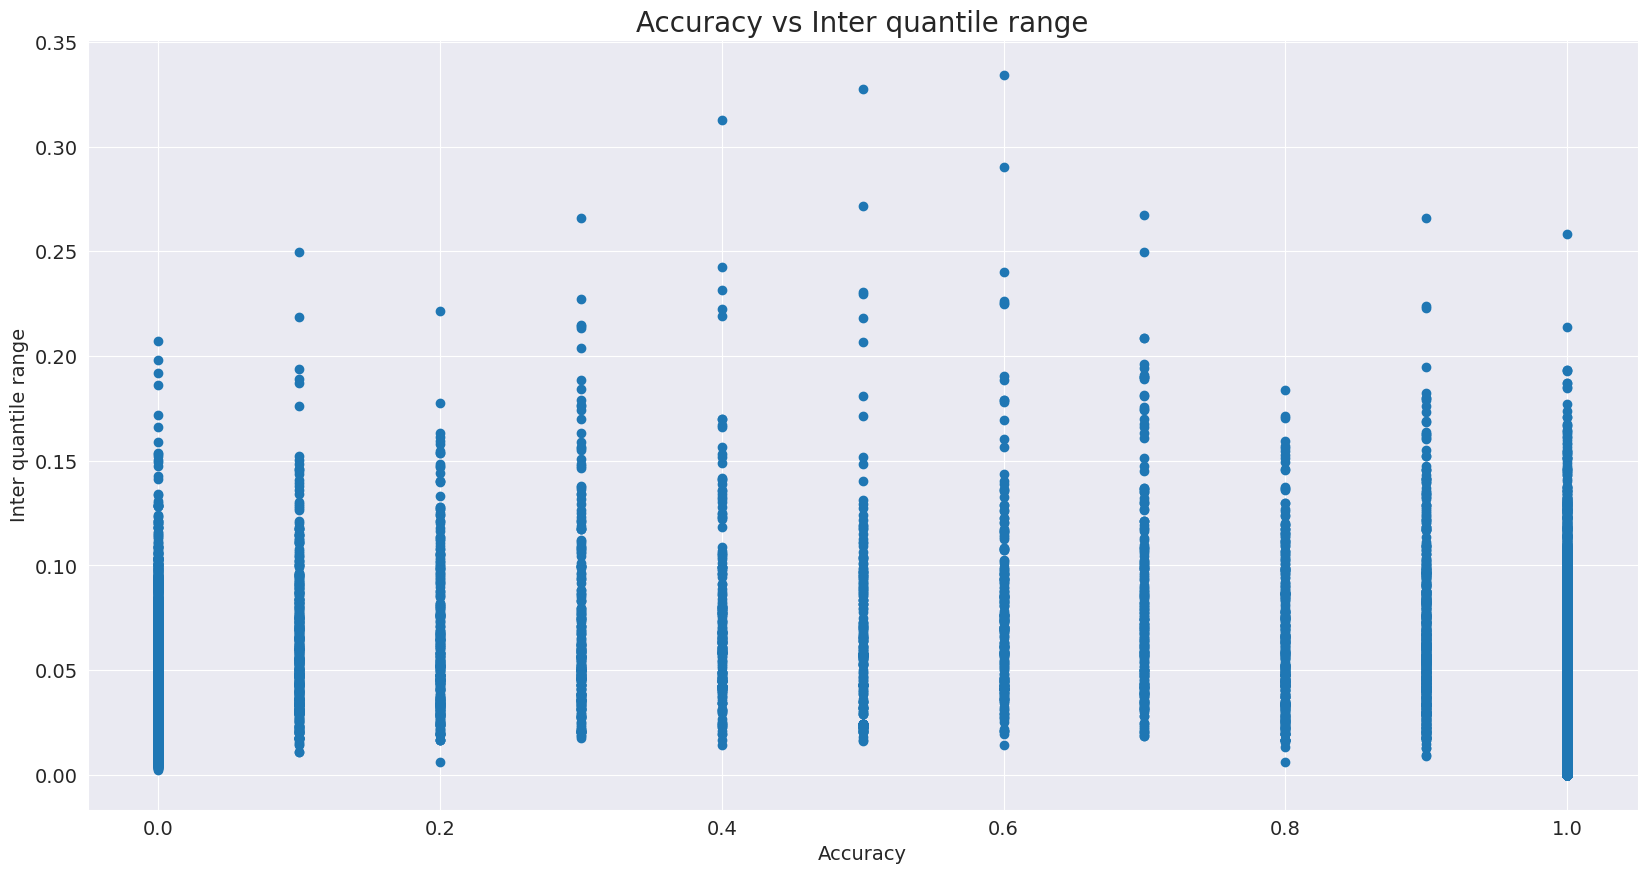

############################## Fairness metrics ##############################

#################### Accuracy ####################
              Race       Sex  Race_Sex
adv       0.829016  0.849706  0.851781
disadv    0.821974  0.808478  0.824730
Accuracy  0.007042  0.041228  0.027050

#################### Disparate_Impact ####################
                      Race       Sex  Race_Sex
adv               0.514001  0.518806  0.531846
disadv            0.454358  0.495284  0.469954
Disparate_Impact  0.883962  0.954661  0.883628

#################### Equal_Opportunity ####################
                       Race       Sex  Race_Sex
adv                0.863619  0.877760  0.881428
disadv             0.832836  0.845629  0.837599
Equal_Opportunity  0.030783  0.032130  0.043829

#################### Statistical_Parity_Difference ####################
                                   Race       Sex  Race_Sex
adv                            1.089745  1.063651  1.057596
disadv             

In [29]:
quantify_uncertainty(TARGET_COLUMN, y_data, imputed_data_dict, imputation_technique='impute-by-median-conditional_RAC1P')

## Display result plots

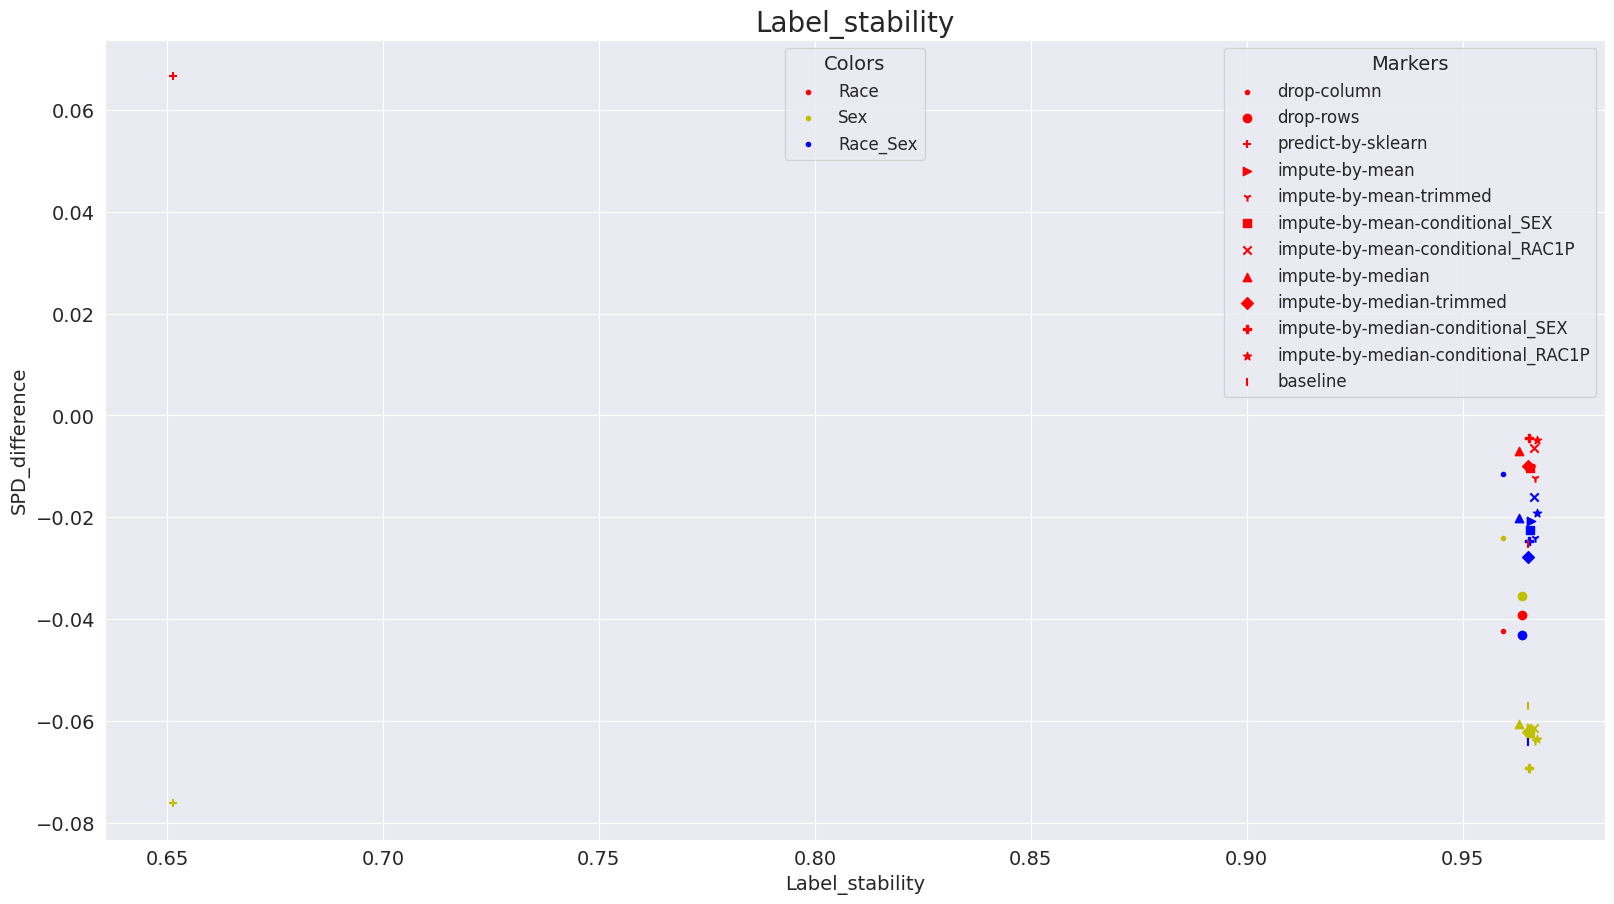

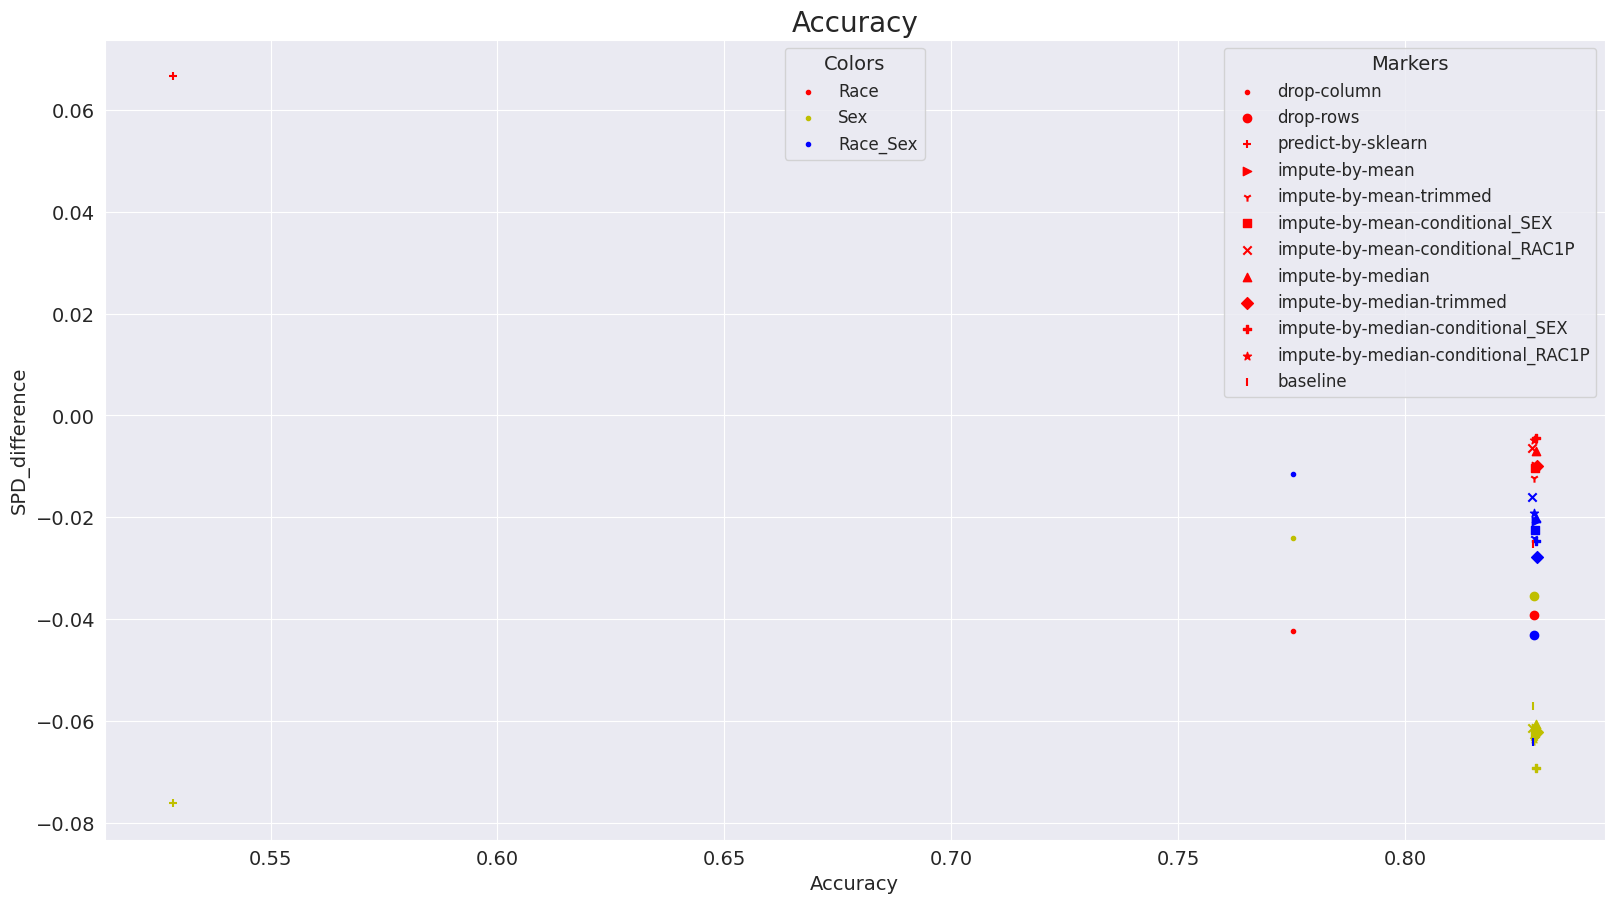

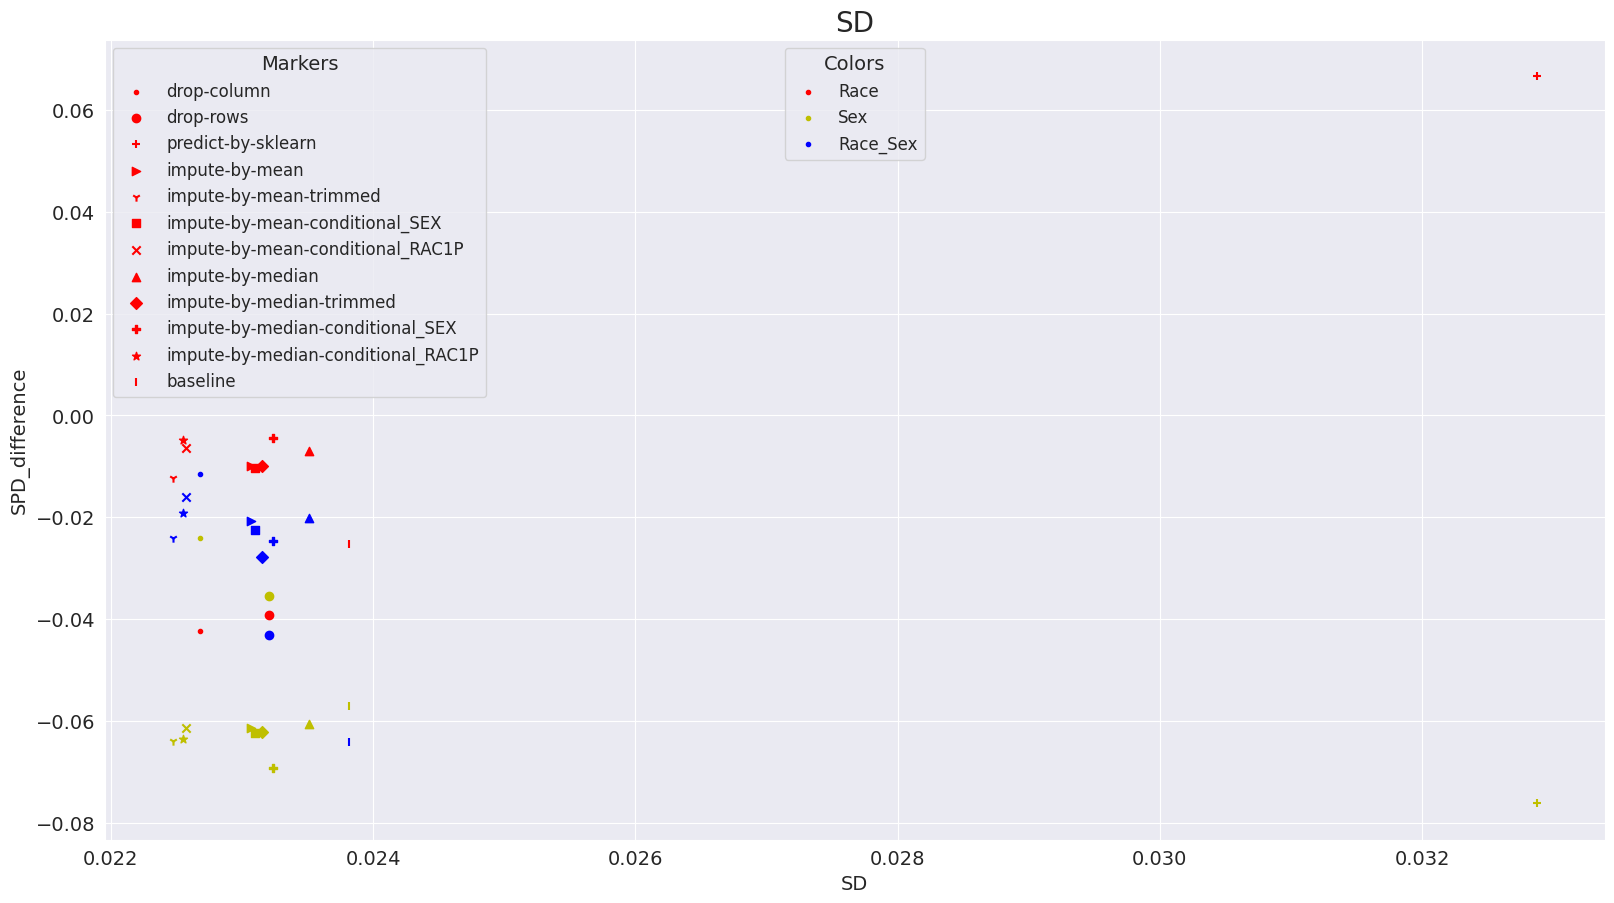

In [32]:
# TODO: make markers larger
#   make subplots by groups (RACE, SEX, RACE_SEX)
display_result_plots(TARGET_COLUMN, imputation_techniques)